## Inverse Problem

This notebook is a simple example of how to solve an inverse problem using at3d. It assumes that we have run the 'SimulateRadiances' notebook and saved the result.

In [1]:
#imports
import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
import warnings
np.random.seed(1)


### Load Measurements

Here we load the synthetic measurements and also all of the inputs to the solver. We will use several of these inputs to perform 'inverse crimes' whereby we fix some aspects of the problem perfectly as in the forward simulation. When using real world measurements no such short cuts are necessary.

* First, we have to look at the measurements and select a region of interest and define our `rte_grid`. 
* Then we have to model the sensor sub-pixel geometry.
* We need to analyze whether the grid and sensor geometry are consistent. The SpaceCarver is useful for this. If not then we may need to change resolution of `rte_grid` to match the resolution of the measurements etc.
* We need to decide how to represent the surface, which is currently fixed.
* We need to decide how to represent the atmosphere.
    * What scattering species are we modelling? What are their optical models? 
    * Which quantities will be unknowns and which are fixed?
    * What will be the abstract state that we will reconstruct? For this we need to set the mapping between the abstract state and the RTE solver.
* Now that we are organized we need to initialize our state vector of unknowns. The method for this initialization may itself be quite involved as starting nearer the answer is better. This typically goes hand in hand with the selection of any fixed variables.
* Lastly we perform the optimization.

In this tutorial we will reconstruct only the `extinction` and we will use forward quantities from the ground truth synthetic measurements for simplicity.

### Checks

In [2]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesSmallRico.nc')

In [3]:
# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 0*2e-3)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, bcflag=3)
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [4]:

# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e8)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
              #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}

mie_mono_tables = OrderedDict()
for wavelength in [.66]:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='mie_tables',
        verbose=False
    )

optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    at3d.size_distribution.gamma,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

In [5]:
# set the generator for the unknown scatterer using ground truth optical properties
# and unknown extinction.
# GridToOpticalProperties holds the fixed optical properties and forms a full set of optical properties
# when it is called with extinction as the argument.

optical_properties = solvers[0.66].medium['cloud'].copy(deep=True)
optical_properties = optical_properties.drop_vars('extinction')

true_geo_extinct = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)


%matplotlib inline
def plot(optimizer):
    py.figure()
    fig, axs = py.subplots(1, 2)
    axs[0].plot(solvers_reconstruct[0.66].medium['cloud'].density.data.ravel(), 
            true_geo_extinct.ravel(),'x')
    axs[0].plot([0,130],[0,130])
    axs[1].plot(solvers_reconstruct[0.66].medium['cloud'].reff.data.ravel(), 
            solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
    axs[1].plot([0,30],[0,30])
    axs[1].axvline(x = np.nanmean(solvers[0.66].medium['cloud'].reff.data.ravel()), color = 'r', linestyle='--')
    py.show()
    return {'None': None}
callback = at3d.callback.CallbackFn(plot)


In [6]:
solvers_reconstruct = at3d.containers.SolversDict()

# We are using the ground_truth rte_grid.
grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, optical_properties
)
def get_loss(reff_diff):
    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
        density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        reff=(None, at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)))
    )
    # now we form state_gen which updates the solvers with an input_state.

    state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                            unknown_scatterers, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    # get bounds automatically.
    min_bounds, max_bounds = state_gen.transform_bounds()
    # transform initial physical state to abstract state. 
    initial_gridded_extinction = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    initial_gridded_reff = solvers[0.66].medium['cloud'].reff.data + reff_diff
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))
    objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
        state_gen.project_gradient_to_state,
            parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bounds, max_bounds=max_bounds)
    # solvers_reconstruct[0.66].medium['cloud'].reff.data = solvers[0.66].medium['cloud'].reff.data + reff_diff
    return objective_function(x0)[0]

In [7]:
solvers_reconstruct = at3d.containers.SolversDict()
def get_loss_uniform(reff_diff):
    # We are using the ground_truth rte_grid.
    grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, optical_properties
    )

    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
        density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        reff=(None, at3d.transforms.StateToGridUniform(mask=carved_volume.mask.data)))
    )
    # now we form state_gen which updates the solvers with an input_state.

    state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                            unknown_scatterers, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    # get bounds automatically.
    min_bounds, max_bounds = state_gen.transform_bounds()
    # transform initial physical state to abstract state. 
    initial_gridded_extinction = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    initial_gridded_reff = solvers[0.66].medium['cloud'].reff.data*0 + solvers[0.66].medium['cloud'].reff.data.ravel().mean() + reff_diff
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))
    objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
        state_gen.project_gradient_to_state,
            parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bounds, max_bounds=max_bounds)
    # solvers_reconstruct[0.66].medium['cloud'].reff.data = solvers[0.66].medium['cloud'].reff.data + reff_diff
    return objective_function(x0)[0]

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968     9.00  0.035   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28351     M =           10

At X0     28350 variables are exactly at the bounds

At iterate    0    f=  5.91438D+05    |proj g|=  1.25719D+01
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.650  0.219E+00    31968   203.00  0.793   [Radiance 0.660 micron]
     2  -1.284  0.228E+00    31968   203.00  0.793   [Radiance 0.660 micron]
     3  -1.822  0.226E+00    31968   203.00  0.793   [Radiance 0.660 micron]
     4  -2.191  0.150E+00    32354   203.64  0.795   [Radiance 0.660 micron]
     5  -2.804  0.835E-01    32862   204.29  0.798   [Radiance 0.660 micron]
     

<Figure size 640x480 with 0 Axes>

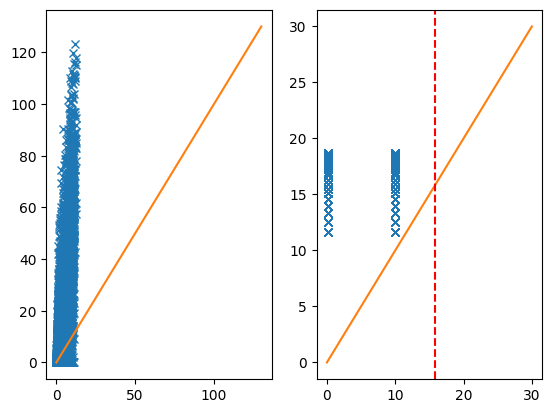

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.667  0.175E+00    31968   191.12  0.747   [Radiance 0.660 micron]
     2  -1.241  0.174E+00    31968   191.12  0.747   [Radiance 0.660 micron]
     3  -1.801  0.169E+00    31968   191.12  0.747   [Radiance 0.660 micron]
     4  -2.148  0.124E+00    32095   191.38  0.748   [Radiance 0.660 micron]
     5  -2.799  0.754E-01    32381   191.88  0.750   [Radiance 0.660 micron]
     6  -2.705  0.406E-01    33223   193.12  0.754   [Radiance 0.660 micron]
     7  -2.843  0.314E-01    34077   194.50  0.760   [Radiance 0.660 micron]
     8  -3.248  0.300E-01    34206   194.69  0.761   [Radiance 0.660 micron]
     9  -3.924  0.300E-01    34206   194.69  0.761   [Radiance 0.660 micron]
    10  -4.503  0.300E-01    34206   194.69  0.761   [Radiance 0.660 micron]
 ! Iterations:     10     Final Criterion:  0.000031   [Radiance 0.660 micron]

At iterate    2    f=  1.97320D+05    |proj g|=  4.46920D+00


<Figure size 640x480 with 0 Axes>

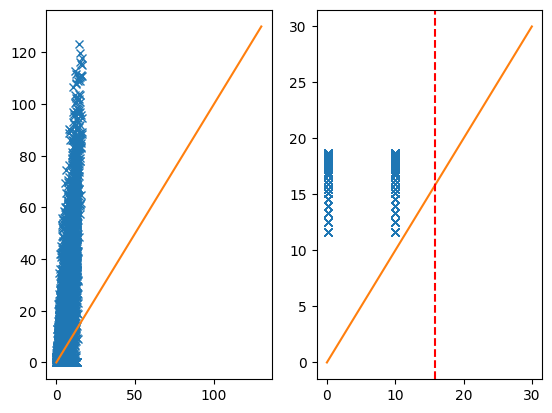

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.687  0.349E+00    31968   162.90  0.636   [Radiance 0.660 micron]
     2  -1.218  0.346E+00    31968   162.90  0.636   [Radiance 0.660 micron]
     3  -1.770  0.342E+00    31968   162.90  0.636   [Radiance 0.660 micron]
     4  -2.118  0.222E+00    32036   163.10  0.637   [Radiance 0.660 micron]
     5  -2.645  0.113E+00    32204   163.59  0.639   [Radiance 0.660 micron]
     6  -2.866  0.526E-01    32778   164.99  0.645   [Radiance 0.660 micron]
     7  -2.831  0.302E-01    33894   167.62  0.655   [Radiance 0.660 micron]
     8  -3.494  0.299E-01    33914   167.67  0.655   [Radiance 0.660 micron]
     9  -3.892  0.299E-01    33914   167.67  0.655   [Radiance 0.660 micron]
    10  -4.173  0.299E-01    33914   167.67  0.655   [Radiance 0.660 micron]
 ! Iterations:     10     Final Criterion:  0.000067   [Radiance 0.660 micron]

At iterate    3    f=  1.38478D+05    |proj g|=  4.01669D+00


<Figure size 640x480 with 0 Axes>

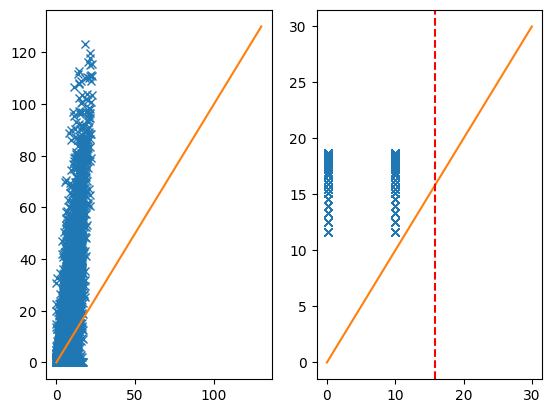

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.692  0.320E+00    31968   151.17  0.590   [Radiance 0.660 micron]
     2  -1.215  0.322E+00    31968   151.17  0.590   [Radiance 0.660 micron]
     3  -1.748  0.320E+00    31968   151.17  0.590   [Radiance 0.660 micron]
     4  -2.094  0.213E+00    32093   151.58  0.592   [Radiance 0.660 micron]
     5  -2.587  0.110E+00    32231   152.01  0.594   [Radiance 0.660 micron]
     6  -2.807  0.551E-01    32817   153.59  0.600   [Radiance 0.660 micron]
     7  -2.837  0.326E-01    33989   156.70  0.612   [Radiance 0.660 micron]
     8  -3.197  0.300E-01    34306   157.48  0.615   [Radiance 0.660 micron]
     9  -3.673  0.300E-01    34306   157.48  0.615   [Radiance 0.660 micron]
    10  -3.953  0.300E-01    34306   157.48  0.615   [Radiance 0.660 micron]
    11  -4.571  0.300E-01    34306   157.48  0.615   [Radiance 0.660 micron]
 ! Iterations:     11     Final Criterion:  0.000027   [Radiance 0.660 micron]


<Figure size 640x480 with 0 Axes>

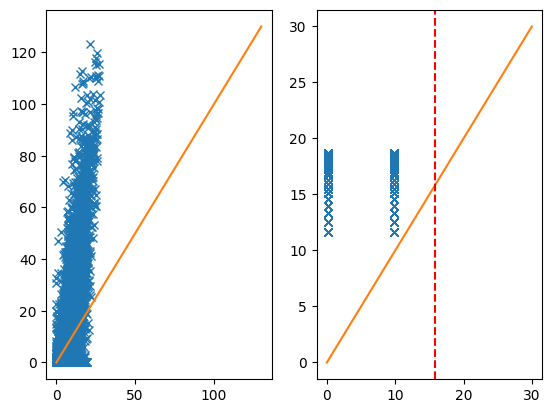

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.697  0.316E+00    31968   138.76  0.542   [Radiance 0.660 micron]
     2  -1.214  0.329E+00    31968   138.76  0.542   [Radiance 0.660 micron]
     3  -1.730  0.326E+00    31968   138.76  0.542   [Radiance 0.660 micron]
     4  -2.073  0.220E+00    32027   138.97  0.543   [Radiance 0.660 micron]
     5  -2.565  0.115E+00    32214   139.65  0.546   [Radiance 0.660 micron]
     6  -2.783  0.570E-01    32717   141.11  0.551   [Radiance 0.660 micron]
     7  -2.771  0.337E-01    34203   145.57  0.569   [Radiance 0.660 micron]
     8  -3.086  0.300E-01    34850   147.37  0.576   [Radiance 0.660 micron]
     9  -3.570  0.300E-01    34850   147.37  0.576   [Radiance 0.660 micron]
    10  -3.859  0.300E-01    34850   147.37  0.576   [Radiance 0.660 micron]
    11  -4.382  0.300E-01    34850   147.37  0.576   [Radiance 0.660 micron]
 ! Iterations:     11     Final Criterion:  0.000042   [Radiance 0.660 micron]


<Figure size 640x480 with 0 Axes>

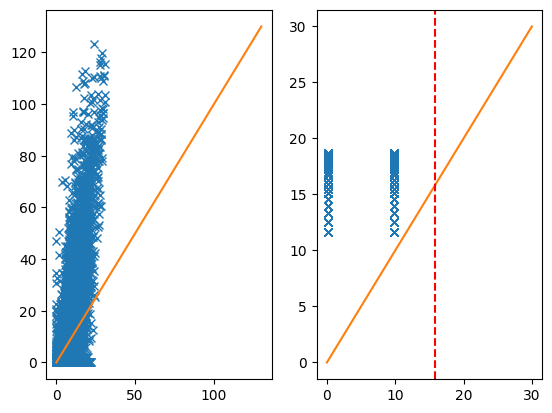

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.697  0.301E+00    31968   126.17  0.493   [Radiance 0.660 micron]
     2  -1.214  0.301E+00    31968   126.17  0.493   [Radiance 0.660 micron]
     3  -1.709  0.298E+00    31968   126.17  0.493   [Radiance 0.660 micron]
     4  -2.047  0.202E+00    31986   126.25  0.493   [Radiance 0.660 micron]
     5  -2.539  0.112E+00    32168   126.96  0.496   [Radiance 0.660 micron]
     6  -2.732  0.574E-01    32721   128.65  0.503   [Radiance 0.660 micron]
     7  -2.694  0.354E-01    34417   134.14  0.524   [Radiance 0.660 micron]
     8  -2.943  0.300E-01    35552   137.78  0.538   [Radiance 0.660 micron]
     9  -3.427  0.300E-01    35561   137.80  0.538   [Radiance 0.660 micron]
    10  -3.742  0.300E-01    35561   137.80  0.538   [Radiance 0.660 micron]
    11  -4.138  0.300E-01    35561   137.80  0.538   [Radiance 0.660 micron]
 ! Iterations:     11     Final Criterion:  0.000073   [Radiance 0.660 micron]


<Figure size 640x480 with 0 Axes>

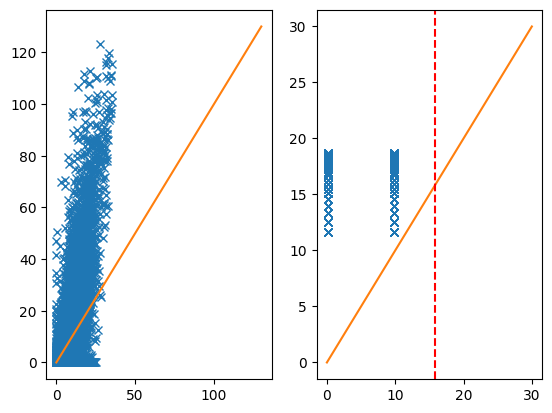

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.690  0.239E+00    31968   114.06  0.446   [Radiance 0.660 micron]
     2  -1.214  0.220E+00    31968   114.06  0.446   [Radiance 0.660 micron]
     3  -1.684  0.218E+00    31968   114.06  0.446   [Radiance 0.660 micron]
     4  -2.013  0.162E+00    32025   114.31  0.447   [Radiance 0.660 micron]
     5  -2.503  0.975E-01    32231   115.05  0.449   [Radiance 0.660 micron]
     6  -2.647  0.547E-01    33052   118.07  0.461   [Radiance 0.660 micron]
     7  -2.619  0.374E-01    34816   124.54  0.486   [Radiance 0.660 micron]
     8  -2.895  0.314E-01    36117   128.75  0.503   [Radiance 0.660 micron]
     9  -3.201  0.300E-01    36519   130.05  0.508   [Radiance 0.660 micron]
    10  -3.595  0.300E-01    36519   130.05  0.508   [Radiance 0.660 micron]
    11  -3.834  0.300E-01    36519   130.05  0.508   [Radiance 0.660 micron]
    12  -4.044  0.300E-01    36519   130.05  0.508   [Radiance 0.660 micron]
 !

<Figure size 640x480 with 0 Axes>

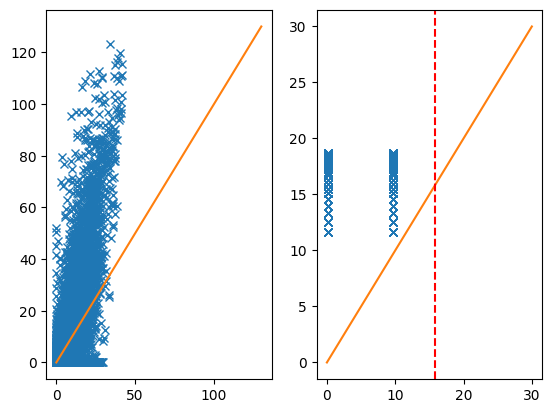

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.685  0.221E+00    31968   105.77  0.413   [Radiance 0.660 micron]
     2  -1.219  0.227E+00    31968   105.77  0.413   [Radiance 0.660 micron]
     3  -1.660  0.228E+00    31968   105.77  0.413   [Radiance 0.660 micron]
     4  -1.976  0.168E+00    32042   106.12  0.415   [Radiance 0.660 micron]
     5  -2.469  0.102E+00    32295   107.14  0.419   [Radiance 0.660 micron]
     6  -2.561  0.575E-01    33459   111.74  0.436   [Radiance 0.660 micron]
     7  -2.554  0.405E-01    35451   119.25  0.466   [Radiance 0.660 micron]
     8  -2.878  0.341E-01    36785   123.83  0.484   [Radiance 0.660 micron]
     9  -2.949  0.300E-01    38210   128.45  0.502   [Radiance 0.660 micron]
    10  -3.348  0.300E-01    38227   128.51  0.502   [Radiance 0.660 micron]
    11  -3.603  0.300E-01    38227   128.51  0.502   [Radiance 0.660 micron]
    12  -3.790  0.300E-01    38227   128.51  0.502   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

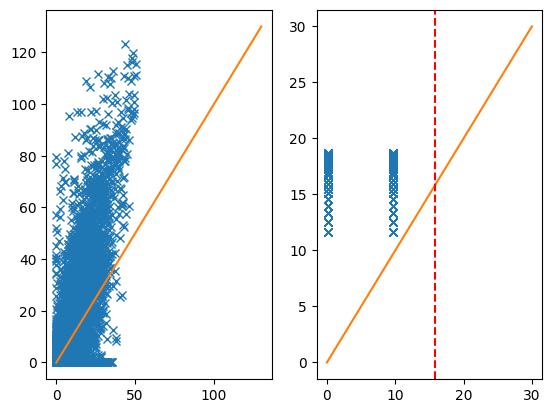

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.679  0.223E+00    31968   106.33  0.415   [Radiance 0.660 micron]
     2  -1.222  0.250E+00    31968   106.33  0.415   [Radiance 0.660 micron]
     3  -1.645  0.259E+00    31968   106.33  0.415   [Radiance 0.660 micron]
     4  -1.952  0.185E+00    32045   106.69  0.417   [Radiance 0.660 micron]
     5  -2.452  0.111E+00    32315   107.78  0.421   [Radiance 0.660 micron]
     6  -2.507  0.607E-01    33775   113.56  0.444   [Radiance 0.660 micron]
     7  -2.506  0.431E-01    35913   121.42  0.474   [Radiance 0.660 micron]
     8  -2.810  0.364E-01    37548   126.80  0.495   [Radiance 0.660 micron]
     9  -2.833  0.300E-01    40098   134.43  0.525   [Radiance 0.660 micron]
    10  -3.199  0.300E-01    40132   134.52  0.525   [Radiance 0.660 micron]
    11  -3.451  0.300E-01    40132   134.52  0.525   [Radiance 0.660 micron]
    12  -3.625  0.300E-01    40132   134.52  0.525   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

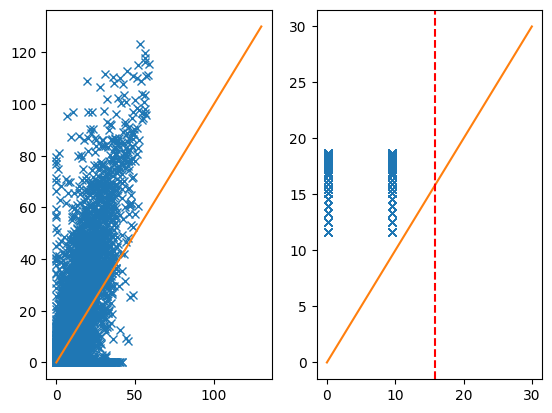

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.682  0.238E+00    31968   106.43  0.416   [Radiance 0.660 micron]
     2  -1.231  0.267E+00    31968   106.43  0.416   [Radiance 0.660 micron]
     3  -1.640  0.278E+00    31968   106.43  0.416   [Radiance 0.660 micron]
     4  -1.938  0.196E+00    32065   106.88  0.418   [Radiance 0.660 micron]
     5  -2.438  0.116E+00    32357   108.08  0.422   [Radiance 0.660 micron]
     6  -2.476  0.629E-01    34037   114.59  0.448   [Radiance 0.660 micron]
     7  -2.500  0.449E-01    36332   122.86  0.480   [Radiance 0.660 micron]
     8  -2.755  0.373E-01    38345   129.28  0.505   [Radiance 0.660 micron]
     9  -2.777  0.300E-01    41686   138.76  0.542   [Radiance 0.660 micron]
    10  -3.109  0.300E-01    41759   138.96  0.543   [Radiance 0.660 micron]
    11  -3.364  0.303E-01    41759   138.96  0.543   [Radiance 0.660 micron]
    12  -3.530  0.303E-01    41759   138.96  0.543   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

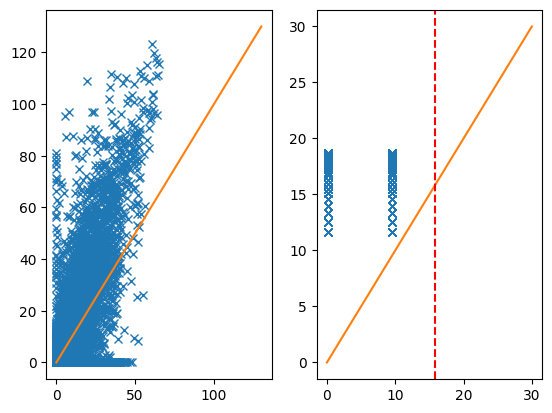

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.682  0.247E+00    31968   110.46  0.432   [Radiance 0.660 micron]
     2  -1.235  0.277E+00    31968   110.46  0.432   [Radiance 0.660 micron]
     3  -1.638  0.288E+00    31968   110.46  0.432   [Radiance 0.660 micron]
     4  -1.930  0.202E+00    32081   110.98  0.434   [Radiance 0.660 micron]
     5  -2.430  0.120E+00    32420   112.29  0.439   [Radiance 0.660 micron]
     6  -2.466  0.642E-01    34256   119.18  0.466   [Radiance 0.660 micron]
     7  -2.502  0.458E-01    36795   127.93  0.500   [Radiance 0.660 micron]
     8  -2.722  0.376E-01    39080   134.74  0.526   [Radiance 0.660 micron]
     9  -2.753  0.300E-01    42729   144.38  0.564   [Radiance 0.660 micron]
    10  -3.083  0.300E-01    42810   144.59  0.565   [Radiance 0.660 micron]
    11  -3.312  0.300E-01    42810   144.59  0.565   [Radiance 0.660 micron]
    12  -3.468  0.300E-01    42810   144.59  0.565   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

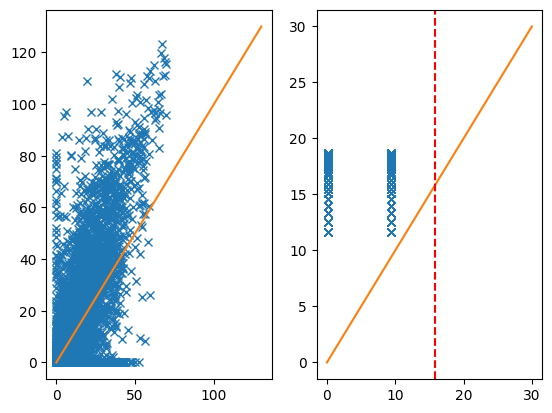

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.682  0.254E+00    31968   110.63  0.432   [Radiance 0.660 micron]
     2  -1.239  0.284E+00    31968   110.63  0.432   [Radiance 0.660 micron]
     3  -1.637  0.296E+00    31968   110.63  0.432   [Radiance 0.660 micron]
     4  -1.923  0.206E+00    32088   111.18  0.434   [Radiance 0.660 micron]
     5  -2.422  0.123E+00    32484   112.73  0.440   [Radiance 0.660 micron]
     6  -2.447  0.653E-01    34480   120.17  0.469   [Radiance 0.660 micron]
     7  -2.505  0.468E-01    37224   129.43  0.506   [Radiance 0.660 micron]
     8  -2.673  0.380E-01    39870   137.26  0.536   [Radiance 0.660 micron]
     9  -2.738  0.302E-01    43743   147.03  0.574   [Radiance 0.660 micron]
    10  -3.035  0.300E-01    43976   147.56  0.576   [Radiance 0.660 micron]
    11  -3.268  0.303E-01    43976   147.56  0.576   [Radiance 0.660 micron]
    12  -3.424  0.303E-01    43976   147.56  0.576   [Radiance 0.660 micron]
  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.682  0.244E+00    31968   115.59  0.452   [Radiance 0.660 micron]
     2  -1.237  0.273E+00    31968   115.59  0.452   [Radiance 0.660 micron]
     3  -1.643  0.285E+00    31968   115.59  0.452   [Radiance 0.660 micron]
     4  -1.935  0.200E+00    32081   116.08  0.453   [Radiance 0.660 micron]
     5  -2.436  0.118E+00    32443   117.43  0.459   [Radiance 0.660 micron]
     6  -2.463  0.635E-01    34356   124.38  0.486   [Radiance 0.660 micron]
     7  -2.529  0.456E-01    36845   132.69  0.518   [Radiance 0.660 micron]
     8  -2.703  0.368E-01    39395   140.08  0.547   [Radiance 0.660 micron]
     9  -2.773  0.300E-01    42760   148.63  0.581   [Radiance 0.660 micron]
    10  -3.099  0.300E-01    42820   148.77  0.581   [Radiance 0.660 micron]
    11  -3.319  0.301E-01    42820   148.77  0.581   [Radiance 0.660 micron]
    12  -3.475  0.301E-01    42820   148.77  0.581   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

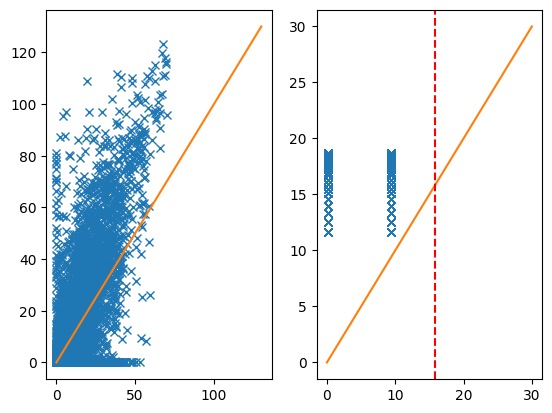

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.689  0.235E+00    31968   100.51  0.393   [Radiance 0.660 micron]
     2  -1.244  0.264E+00    31968   100.51  0.393   [Radiance 0.660 micron]
     3  -1.649  0.276E+00    31968   100.51  0.393   [Radiance 0.660 micron]
     4  -1.940  0.192E+00    32098   101.13  0.395   [Radiance 0.660 micron]
     5  -2.431  0.115E+00    32519   102.90  0.402   [Radiance 0.660 micron]
     6  -2.463  0.628E-01    34469   110.69  0.432   [Radiance 0.660 micron]
     7  -2.513  0.453E-01    37119   120.28  0.470   [Radiance 0.660 micron]
     8  -2.696  0.371E-01    39625   128.29  0.501   [Radiance 0.660 micron]
     9  -2.769  0.300E-01    42969   137.42  0.537   [Radiance 0.660 micron]
    10  -3.080  0.300E-01    43023   137.56  0.537   [Radiance 0.660 micron]
    11  -3.302  0.300E-01    43023   137.56  0.537   [Radiance 0.660 micron]
    12  -3.460  0.300E-01    43023   137.56  0.537   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

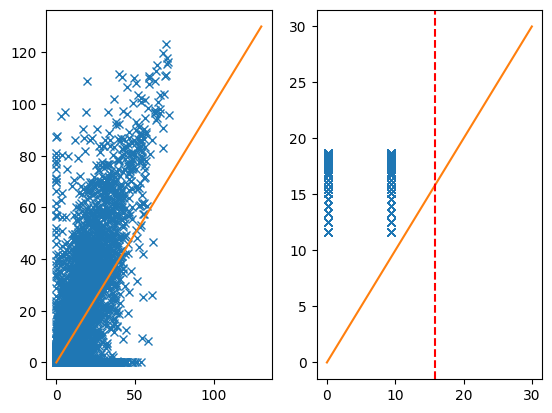

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.679  0.250E+00    31968   107.64  0.420   [Radiance 0.660 micron]
     2  -1.241  0.271E+00    31968   107.64  0.420   [Radiance 0.660 micron]
     3  -1.654  0.275E+00    31968   107.64  0.420   [Radiance 0.660 micron]
     4  -1.947  0.196E+00    32092   108.20  0.423   [Radiance 0.660 micron]
     5  -2.443  0.116E+00    32542   109.96  0.430   [Radiance 0.660 micron]
     6  -2.461  0.626E-01    34653   117.93  0.461   [Radiance 0.660 micron]
     7  -2.519  0.453E-01    37505   127.64  0.499   [Radiance 0.660 micron]
     8  -2.678  0.370E-01    40075   135.15  0.528   [Radiance 0.660 micron]
     9  -2.744  0.300E-01    43656   144.13  0.563   [Radiance 0.660 micron]
    10  -3.072  0.300E-01    43714   144.23  0.563   [Radiance 0.660 micron]
    11  -3.301  0.301E-01    43714   144.23  0.563   [Radiance 0.660 micron]
    12  -3.460  0.301E-01    43714   144.23  0.563   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

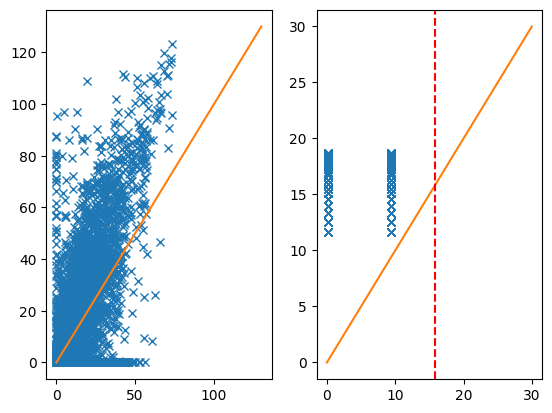

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.686  0.257E+00    31968    99.30  0.388   [Radiance 0.660 micron]
     2  -1.248  0.278E+00    31968    99.30  0.388   [Radiance 0.660 micron]
     3  -1.660  0.282E+00    31968    99.30  0.388   [Radiance 0.660 micron]
     4  -1.954  0.198E+00    32092    99.89  0.390   [Radiance 0.660 micron]
     5  -2.444  0.117E+00    32561   101.83  0.398   [Radiance 0.660 micron]
     6  -2.448  0.628E-01    34882   111.18  0.434   [Radiance 0.660 micron]
     7  -2.480  0.458E-01    37918   121.92  0.476   [Radiance 0.660 micron]
     8  -2.675  0.383E-01    40255   128.87  0.503   [Radiance 0.660 micron]
     9  -2.717  0.303E-01    44288   139.40  0.545   [Radiance 0.660 micron]
    10  -3.032  0.300E-01    44545   140.02  0.547   [Radiance 0.660 micron]
    11  -3.289  0.303E-01    44545   140.02  0.547   [Radiance 0.660 micron]
    12  -3.454  0.303E-01    44545   140.02  0.547   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

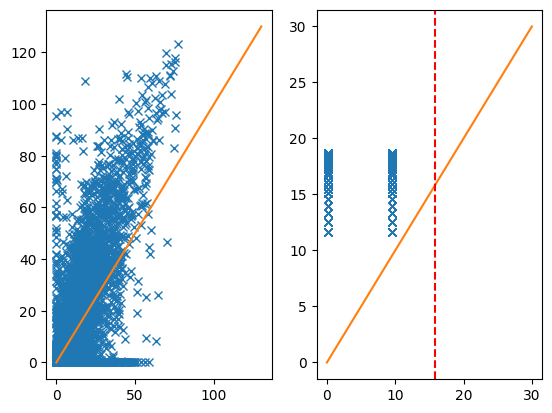

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.689  0.263E+00    31968    98.07  0.383   [Radiance 0.660 micron]
     2  -1.253  0.284E+00    31968    98.07  0.383   [Radiance 0.660 micron]
     3  -1.665  0.286E+00    31968    98.07  0.383   [Radiance 0.660 micron]
     4  -1.957  0.201E+00    32108    98.75  0.386   [Radiance 0.660 micron]
     5  -2.437  0.118E+00    32597   100.76  0.394   [Radiance 0.660 micron]
     6  -2.441  0.634E-01    35135   111.00  0.434   [Radiance 0.660 micron]
     7  -2.481  0.463E-01    38197   121.74  0.476   [Radiance 0.660 micron]
     8  -2.653  0.385E-01    40594   128.79  0.503   [Radiance 0.660 micron]
     9  -2.708  0.309E-01    44735   139.33  0.544   [Radiance 0.660 micron]
    10  -2.969  0.300E-01    45419   140.91  0.550   [Radiance 0.660 micron]
    11  -3.227  0.300E-01    45454   141.00  0.551   [Radiance 0.660 micron]
    12  -3.431  0.300E-01    45454   141.00  0.551   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

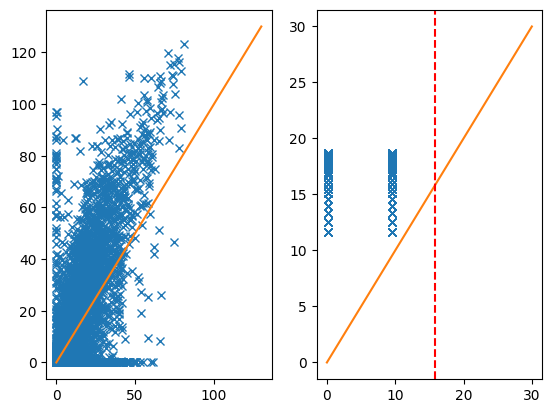

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.691  0.282E+00    31968    96.55  0.377   [Radiance 0.660 micron]
     2  -1.256  0.305E+00    31968    96.55  0.377   [Radiance 0.660 micron]
     3  -1.667  0.306E+00    31968    96.55  0.377   [Radiance 0.660 micron]
     4  -1.960  0.211E+00    32095    97.16  0.380   [Radiance 0.660 micron]
     5  -2.437  0.123E+00    32549    99.13  0.387   [Radiance 0.660 micron]
     6  -2.434  0.648E-01    35156   109.70  0.429   [Radiance 0.660 micron]
     7  -2.469  0.472E-01    38307   120.78  0.472   [Radiance 0.660 micron]
     8  -2.637  0.392E-01    40699   127.98  0.500   [Radiance 0.660 micron]
     9  -2.696  0.314E-01    44801   138.39  0.541   [Radiance 0.660 micron]
    10  -2.919  0.300E-01    45941   140.96  0.551   [Radiance 0.660 micron]
    11  -3.203  0.300E-01    45985   141.05  0.551   [Radiance 0.660 micron]
    12  -3.402  0.301E-01    45985   141.05  0.551   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

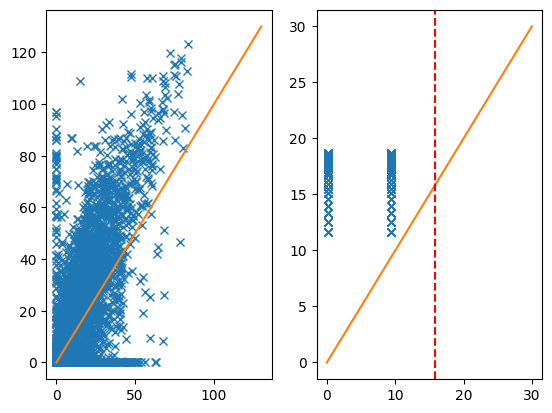

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.698  0.316E+00    31968    93.23  0.364   [Radiance 0.660 micron]
     2  -1.262  0.340E+00    31968    93.23  0.364   [Radiance 0.660 micron]
     3  -1.671  0.342E+00    31968    93.23  0.364   [Radiance 0.660 micron]
     4  -1.962  0.232E+00    32065    93.69  0.366   [Radiance 0.660 micron]
     5  -2.434  0.131E+00    32511    95.69  0.374   [Radiance 0.660 micron]
     6  -2.429  0.672E-01    35160   106.56  0.416   [Radiance 0.660 micron]
     7  -2.451  0.484E-01    38353   118.08  0.461   [Radiance 0.660 micron]
     8  -2.604  0.403E-01    40794   125.48  0.490   [Radiance 0.660 micron]
     9  -2.697  0.326E-01    44809   135.96  0.531   [Radiance 0.660 micron]
    10  -2.860  0.300E-01    46882   140.75  0.550   [Radiance 0.660 micron]
    11  -3.136  0.300E-01    46955   140.88  0.550   [Radiance 0.660 micron]
    12  -3.371  0.300E-01    46955   140.88  0.550   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

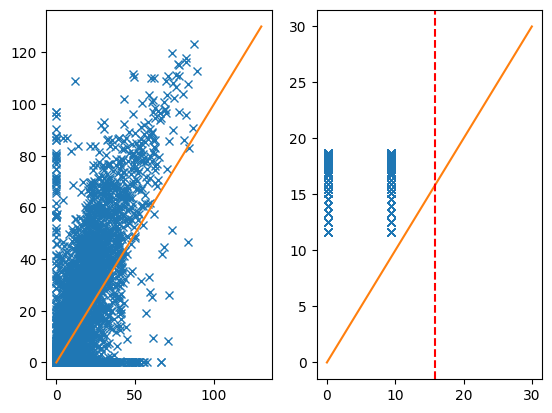

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.701  0.327E+00    31968    94.69  0.370   [Radiance 0.660 micron]
     2  -1.267  0.356E+00    31968    94.69  0.370   [Radiance 0.660 micron]
     3  -1.673  0.363E+00    31968    94.69  0.370   [Radiance 0.660 micron]
     4  -1.961  0.236E+00    32071    95.18  0.372   [Radiance 0.660 micron]
     5  -2.423  0.134E+00    32542    97.24  0.380   [Radiance 0.660 micron]
     6  -2.423  0.687E-01    35218   108.16  0.423   [Radiance 0.660 micron]
     7  -2.455  0.492E-01    38468   119.68  0.467   [Radiance 0.660 micron]
     8  -2.588  0.406E-01    41104   127.53  0.498   [Radiance 0.660 micron]
     9  -2.688  0.331E-01    45085   137.76  0.538   [Radiance 0.660 micron]
    10  -2.829  0.300E-01    47550   143.27  0.560   [Radiance 0.660 micron]
    11  -3.105  0.300E-01    47645   143.44  0.560   [Radiance 0.660 micron]
    12  -3.349  0.300E-01    47645   143.44  0.560   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

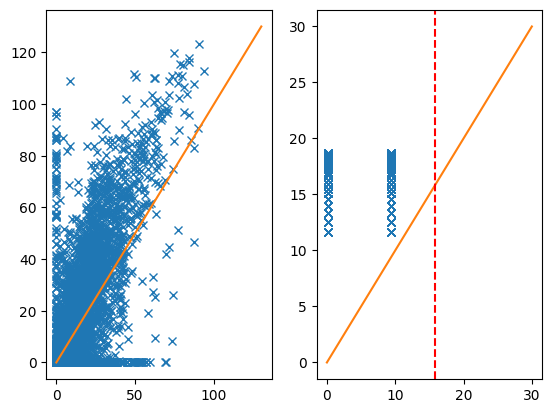

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.704  0.344E+00    31968    91.57  0.358   [Radiance 0.660 micron]
     2  -1.269  0.381E+00    31968    91.57  0.358   [Radiance 0.660 micron]
     3  -1.672  0.390E+00    31968    91.57  0.358   [Radiance 0.660 micron]
     4  -1.960  0.254E+00    32052    91.97  0.359   [Radiance 0.660 micron]
     5  -2.423  0.140E+00    32515    94.08  0.368   [Radiance 0.660 micron]
     6  -2.407  0.704E-01    35270   105.55  0.412   [Radiance 0.660 micron]
     7  -2.436  0.506E-01    38399   116.83  0.456   [Radiance 0.660 micron]
     8  -2.584  0.419E-01    41071   125.02  0.488   [Radiance 0.660 micron]
     9  -2.669  0.337E-01    45249   135.90  0.531   [Radiance 0.660 micron]
    10  -2.807  0.300E-01    48134   142.51  0.557   [Radiance 0.660 micron]
    11  -3.091  0.300E-01    48218   142.67  0.557   [Radiance 0.660 micron]
    12  -3.321  0.302E-01    48218   142.67  0.557   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

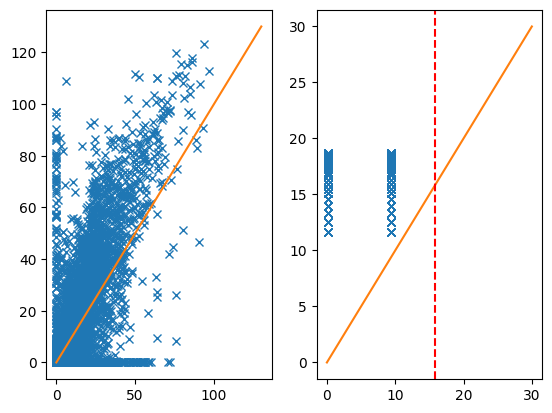

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.705  0.359E+00    31968    90.41  0.353   [Radiance 0.660 micron]
     2  -1.271  0.397E+00    31968    90.41  0.353   [Radiance 0.660 micron]
     3  -1.670  0.407E+00    31968    90.41  0.353   [Radiance 0.660 micron]
     4  -1.957  0.263E+00    32045    90.79  0.355   [Radiance 0.660 micron]
     5  -2.414  0.143E+00    32506    92.89  0.363   [Radiance 0.660 micron]
     6  -2.393  0.720E-01    35270   104.45  0.408   [Radiance 0.660 micron]
     7  -2.431  0.519E-01    38374   115.66  0.452   [Radiance 0.660 micron]
     8  -2.569  0.426E-01    41186   124.31  0.486   [Radiance 0.660 micron]
     9  -2.652  0.344E-01    45357   135.28  0.528   [Radiance 0.660 micron]
    10  -2.769  0.300E-01    49016   143.33  0.560   [Radiance 0.660 micron]
    11  -3.046  0.300E-01    49158   143.57  0.561   [Radiance 0.660 micron]
    12  -3.299  0.300E-01    49158   143.57  0.561   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

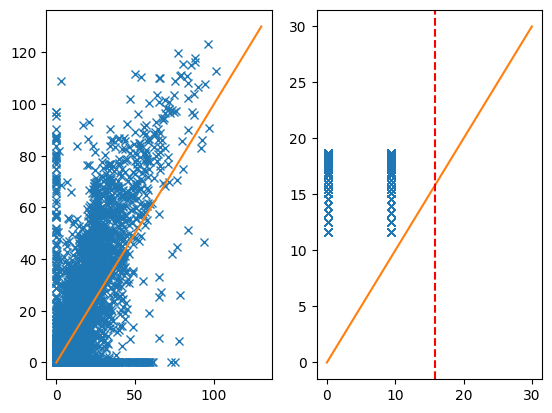

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.706  0.371E+00    31968    90.94  0.355   [Radiance 0.660 micron]
     2  -1.273  0.409E+00    31968    90.94  0.355   [Radiance 0.660 micron]
     3  -1.670  0.420E+00    31968    90.94  0.355   [Radiance 0.660 micron]
     4  -1.955  0.270E+00    32046    91.32  0.357   [Radiance 0.660 micron]
     5  -2.405  0.146E+00    32510    93.41  0.365   [Radiance 0.660 micron]
     6  -2.383  0.734E-01    35313   105.13  0.411   [Radiance 0.660 micron]
     7  -2.427  0.529E-01    38452   116.35  0.454   [Radiance 0.660 micron]
     8  -2.562  0.432E-01    41345   125.09  0.489   [Radiance 0.660 micron]
     9  -2.638  0.348E-01    45522   136.01  0.531   [Radiance 0.660 micron]
    10  -2.750  0.300E-01    49595   144.83  0.566   [Radiance 0.660 micron]
    11  -3.037  0.300E-01    49761   145.13  0.567   [Radiance 0.660 micron]
    12  -3.281  0.301E-01    49761   145.13  0.567   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

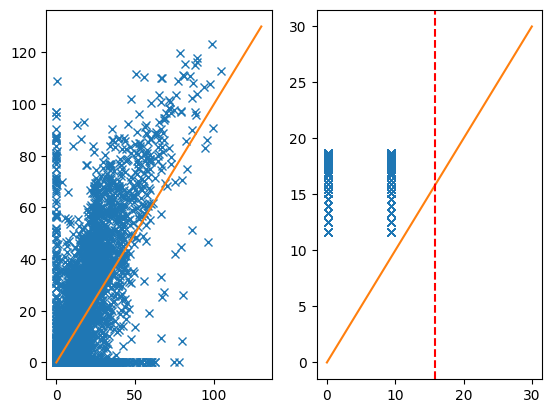

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.706  0.384E+00    31968    89.86  0.351   [Radiance 0.660 micron]
     2  -1.274  0.423E+00    31968    89.86  0.351   [Radiance 0.660 micron]
     3  -1.668  0.435E+00    31968    89.86  0.351   [Radiance 0.660 micron]
     4  -1.951  0.274E+00    32049    90.26  0.353   [Radiance 0.660 micron]
     5  -2.395  0.150E+00    32509    92.37  0.361   [Radiance 0.660 micron]
     6  -2.373  0.750E-01    35332   104.25  0.407   [Radiance 0.660 micron]
     7  -2.413  0.540E-01    38513   115.60  0.452   [Radiance 0.660 micron]
     8  -2.559  0.443E-01    41390   124.40  0.486   [Radiance 0.660 micron]
     9  -2.633  0.353E-01    45857   135.98  0.531   [Radiance 0.660 micron]
    10  -2.708  0.300E-01    50332   145.61  0.569   [Radiance 0.660 micron]
    11  -3.020  0.300E-01    50507   145.91  0.570   [Radiance 0.660 micron]
    12  -3.253  0.301E-01    50507   145.91  0.570   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

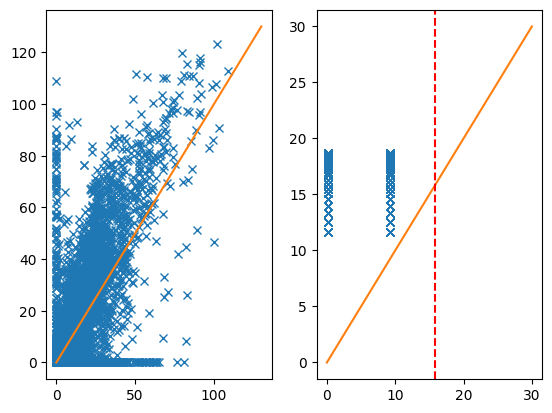

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.706  0.394E+00    31968    94.08  0.367   [Radiance 0.660 micron]
     2  -1.277  0.433E+00    31968    94.08  0.367   [Radiance 0.660 micron]
     3  -1.668  0.447E+00    31968    94.08  0.367   [Radiance 0.660 micron]
     4  -1.950  0.280E+00    32046    94.45  0.369   [Radiance 0.660 micron]
     5  -2.390  0.152E+00    32523    96.62  0.377   [Radiance 0.660 micron]
     6  -2.366  0.760E-01    35371   108.29  0.423   [Radiance 0.660 micron]
     7  -2.410  0.548E-01    38573   119.42  0.466   [Radiance 0.660 micron]
     8  -2.552  0.447E-01    41593   128.51  0.502   [Radiance 0.660 micron]
     9  -2.620  0.357E-01    46181   139.93  0.547   [Radiance 0.660 micron]
    10  -2.694  0.301E-01    51060   149.95  0.586   [Radiance 0.660 micron]
    11  -3.005  0.300E-01    51257   150.28  0.587   [Radiance 0.660 micron]
    12  -3.235  0.300E-01    51257   150.28  0.587   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

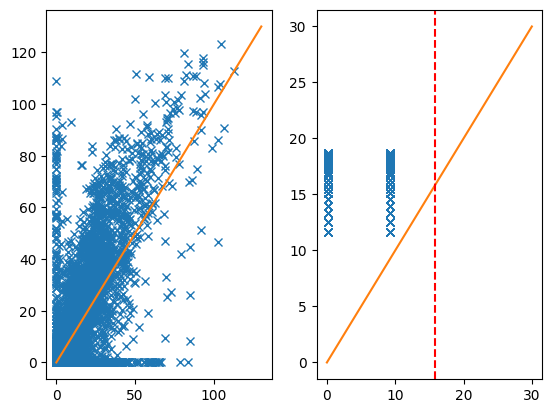

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.708  0.402E+00    31968    93.84  0.367   [Radiance 0.660 micron]
     2  -1.280  0.442E+00    31968    93.84  0.367   [Radiance 0.660 micron]
     3  -1.668  0.457E+00    31968    93.84  0.367   [Radiance 0.660 micron]
     4  -1.948  0.285E+00    32046    94.22  0.368   [Radiance 0.660 micron]
     5  -2.386  0.154E+00    32540    96.49  0.377   [Radiance 0.660 micron]
     6  -2.357  0.768E-01    35451   108.42  0.424   [Radiance 0.660 micron]
     7  -2.403  0.556E-01    38699   119.64  0.467   [Radiance 0.660 micron]
     8  -2.538  0.454E-01    41735   128.64  0.503   [Radiance 0.660 micron]
     9  -2.616  0.364E-01    46339   140.11  0.547   [Radiance 0.660 micron]
    10  -2.674  0.305E-01    51524   150.67  0.589   [Radiance 0.660 micron]
    11  -2.959  0.300E-01    52082   151.65  0.592   [Radiance 0.660 micron]
    12  -3.187  0.300E-01    52124   151.70  0.593   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

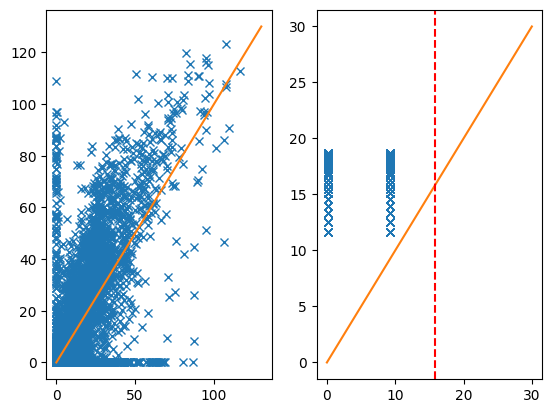

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.708  0.406E+00    31968    99.31  0.388   [Radiance 0.660 micron]
     2  -1.281  0.446E+00    31968    99.31  0.388   [Radiance 0.660 micron]
     3  -1.669  0.461E+00    31968    99.31  0.388   [Radiance 0.660 micron]
     4  -1.949  0.289E+00    32045    99.68  0.389   [Radiance 0.660 micron]
     5  -2.387  0.155E+00    32541   101.91  0.398   [Radiance 0.660 micron]
     6  -2.355  0.768E-01    35517   113.73  0.444   [Radiance 0.660 micron]
     7  -2.403  0.557E-01    38820   124.76  0.487   [Radiance 0.660 micron]
     8  -2.536  0.455E-01    41940   133.78  0.523   [Radiance 0.660 micron]
     9  -2.607  0.365E-01    46660   145.01  0.566   [Radiance 0.660 micron]
    10  -2.673  0.307E-01    51687   154.86  0.605   [Radiance 0.660 micron]
    11  -2.936  0.300E-01    52637   156.52  0.611   [Radiance 0.660 micron]
    12  -3.167  0.300E-01    52709   156.63  0.612   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

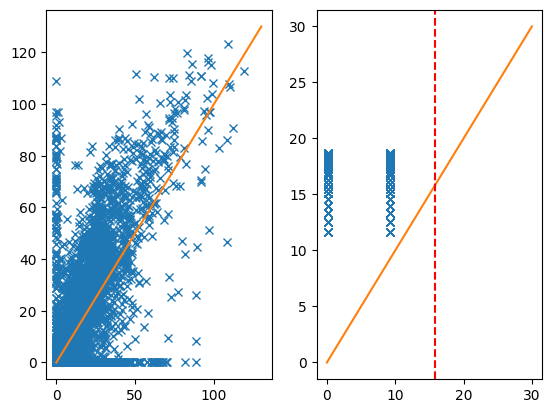

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.709  0.414E+00    31968    96.46  0.377   [Radiance 0.660 micron]
     2  -1.284  0.453E+00    31968    96.46  0.377   [Radiance 0.660 micron]
     3  -1.670  0.469E+00    31968    96.46  0.377   [Radiance 0.660 micron]
     4  -1.946  0.293E+00    32051    96.86  0.378   [Radiance 0.660 micron]
     5  -2.380  0.157E+00    32576    99.24  0.388   [Radiance 0.660 micron]
     6  -2.339  0.779E-01    35678   111.68  0.436   [Radiance 0.660 micron]
     7  -2.389  0.569E-01    38915   122.56  0.479   [Radiance 0.660 micron]
     8  -2.523  0.466E-01    42191   132.05  0.516   [Radiance 0.660 micron]
     9  -2.595  0.374E-01    46874   143.40  0.560   [Radiance 0.660 micron]
    10  -2.653  0.314E-01    52063   153.41  0.599   [Radiance 0.660 micron]
    11  -2.887  0.300E-01    53695   156.23  0.610   [Radiance 0.660 micron]
    12  -3.140  0.300E-01    53786   156.36  0.611   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

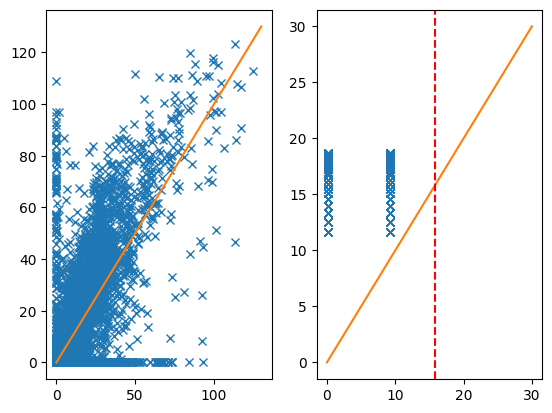

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.706  0.417E+00    31968   101.12  0.395   [Radiance 0.660 micron]
     2  -1.282  0.456E+00    31968   101.12  0.395   [Radiance 0.660 micron]
     3  -1.669  0.472E+00    31968   101.12  0.395   [Radiance 0.660 micron]
     4  -1.944  0.294E+00    32066   101.57  0.397   [Radiance 0.660 micron]
     5  -2.373  0.158E+00    32596   103.92  0.406   [Radiance 0.660 micron]
     6  -2.337  0.786E-01    35698   115.97  0.453   [Radiance 0.660 micron]
     7  -2.387  0.574E-01    39037   126.94  0.496   [Radiance 0.660 micron]
     8  -2.517  0.468E-01    42455   136.46  0.533   [Radiance 0.660 micron]
     9  -2.586  0.377E-01    47304   147.73  0.577   [Radiance 0.660 micron]
    10  -2.667  0.318E-01    52261   157.00  0.613   [Radiance 0.660 micron]
    11  -2.861  0.300E-01    54329   160.34  0.626   [Radiance 0.660 micron]
    12  -3.097  0.300E-01    54418   160.46  0.627   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

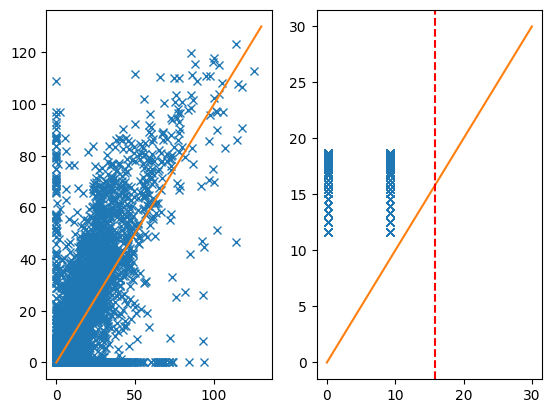

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.714  0.417E+00    31968    93.99  0.367   [Radiance 0.660 micron]
     2  -1.288  0.456E+00    31968    93.99  0.367   [Radiance 0.660 micron]
     3  -1.672  0.472E+00    31968    93.99  0.367   [Radiance 0.660 micron]
     4  -1.945  0.292E+00    32072    94.51  0.369   [Radiance 0.660 micron]
     5  -2.367  0.157E+00    32621    97.06  0.379   [Radiance 0.660 micron]
     6  -2.332  0.789E-01    35764   109.94  0.429   [Radiance 0.660 micron]
     7  -2.380  0.577E-01    39133   121.53  0.475   [Radiance 0.660 micron]
     8  -2.517  0.473E-01    42440   131.16  0.512   [Radiance 0.660 micron]
     9  -2.577  0.379E-01    47421   143.20  0.559   [Radiance 0.660 micron]
    10  -2.666  0.321E-01    52263   152.68  0.596   [Radiance 0.660 micron]
    11  -2.837  0.300E-01    54749   156.92  0.613   [Radiance 0.660 micron]
    12  -3.054  0.300E-01    54845   157.04  0.613   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

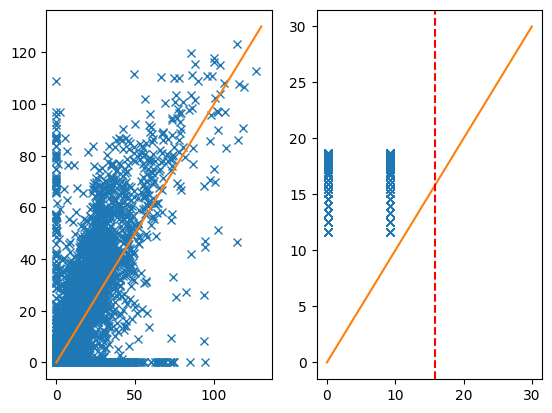

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.715  0.417E+00    31968    87.94  0.344   [Radiance 0.660 micron]
     2  -1.288  0.455E+00    31968    87.94  0.344   [Radiance 0.660 micron]
     3  -1.672  0.470E+00    31968    87.94  0.344   [Radiance 0.660 micron]
     4  -1.945  0.291E+00    32073    88.48  0.346   [Radiance 0.660 micron]
     5  -2.364  0.156E+00    32632    91.19  0.356   [Radiance 0.660 micron]
     6  -2.329  0.791E-01    35786   104.49  0.408   [Radiance 0.660 micron]
     7  -2.374  0.579E-01    39161   116.59  0.455   [Radiance 0.660 micron]
     8  -2.524  0.476E-01    42348   126.12  0.493   [Radiance 0.660 micron]
     9  -2.573  0.378E-01    47566   139.18  0.544   [Radiance 0.660 micron]
    10  -2.656  0.322E-01    52315   148.69  0.581   [Radiance 0.660 micron]
    11  -2.838  0.300E-01    54851   153.27  0.599   [Radiance 0.660 micron]
    12  -3.063  0.300E-01    54955   153.40  0.599   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

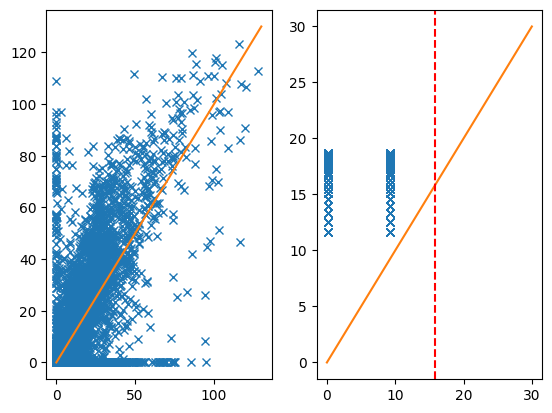

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.717  0.417E+00    31968    85.21  0.333   [Radiance 0.660 micron]
     2  -1.289  0.454E+00    31968    85.21  0.333   [Radiance 0.660 micron]
     3  -1.673  0.469E+00    31968    85.21  0.333   [Radiance 0.660 micron]
     4  -1.947  0.289E+00    32075    85.78  0.335   [Radiance 0.660 micron]
     5  -2.363  0.156E+00    32620    88.46  0.346   [Radiance 0.660 micron]
     6  -2.335  0.790E-01    35704   101.71  0.397   [Radiance 0.660 micron]
     7  -2.376  0.575E-01    39132   114.24  0.446   [Radiance 0.660 micron]
     8  -2.527  0.474E-01    42239   123.73  0.483   [Radiance 0.660 micron]
     9  -2.560  0.376E-01    47449   137.05  0.535   [Radiance 0.660 micron]
    10  -2.679  0.325E-01    51743   145.99  0.570   [Radiance 0.660 micron]
    11  -2.822  0.300E-01    54543   151.10  0.590   [Radiance 0.660 micron]
    12  -3.062  0.300E-01    54623   151.21  0.591   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

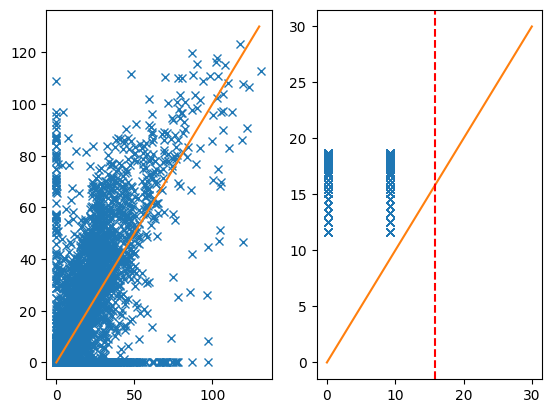

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.702  0.417E+00    31968   109.76  0.429   [Radiance 0.660 micron]
     2  -1.282  0.454E+00    31968   109.76  0.429   [Radiance 0.660 micron]
     3  -1.672  0.469E+00    31968   109.76  0.429   [Radiance 0.660 micron]
     4  -1.947  0.292E+00    32070   110.23  0.431   [Radiance 0.660 micron]
     5  -2.372  0.157E+00    32590   112.42  0.439   [Radiance 0.660 micron]
     6  -2.342  0.784E-01    35663   123.77  0.483   [Radiance 0.660 micron]
     7  -2.383  0.570E-01    39185   134.75  0.526   [Radiance 0.660 micron]
     8  -2.532  0.468E-01    42255   142.74  0.558   [Radiance 0.660 micron]
     9  -2.566  0.372E-01    47448   154.13  0.602   [Radiance 0.660 micron]
    10  -2.681  0.321E-01    51765   161.81  0.632   [Radiance 0.660 micron]
    11  -2.851  0.300E-01    54156   165.51  0.647   [Radiance 0.660 micron]
    12  -3.072  0.300E-01    54244   165.63  0.647   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

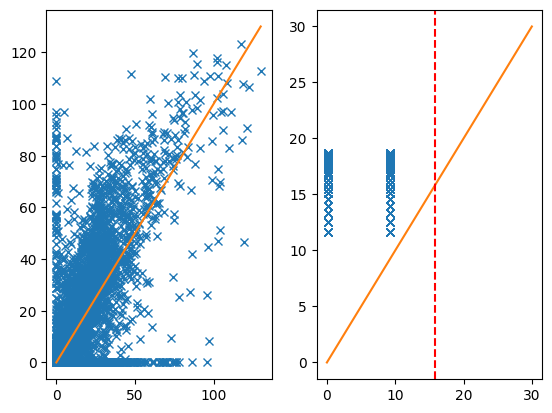

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.704  0.417E+00    31968   112.10  0.438   [Radiance 0.660 micron]
     2  -1.283  0.454E+00    31968   112.10  0.438   [Radiance 0.660 micron]
     3  -1.673  0.469E+00    31968   112.10  0.438   [Radiance 0.660 micron]
     4  -1.949  0.292E+00    32070   112.56  0.440   [Radiance 0.660 micron]
     5  -2.375  0.156E+00    32591   114.72  0.448   [Radiance 0.660 micron]
     6  -2.347  0.781E-01    35644   125.83  0.492   [Radiance 0.660 micron]
     7  -2.389  0.566E-01    39158   136.68  0.534   [Radiance 0.660 micron]
     8  -2.543  0.464E-01    42274   144.71  0.565   [Radiance 0.660 micron]
     9  -2.568  0.367E-01    47636   156.23  0.610   [Radiance 0.660 micron]
    10  -2.700  0.319E-01    51687   163.37  0.638   [Radiance 0.660 micron]
    11  -2.848  0.300E-01    53783   166.66  0.651   [Radiance 0.660 micron]
    12  -3.090  0.300E-01    53862   166.77  0.651   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

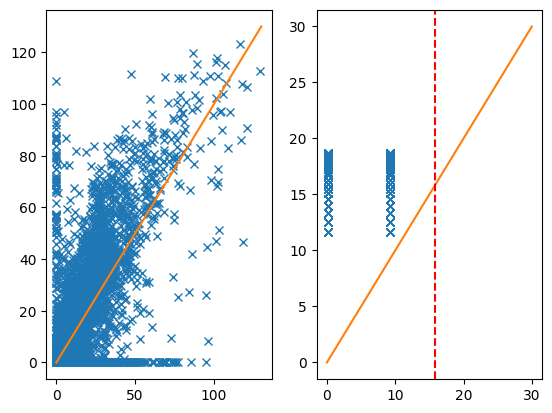

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.706  0.417E+00    31968   104.27  0.407   [Radiance 0.660 micron]
     2  -1.282  0.455E+00    31968   104.27  0.407   [Radiance 0.660 micron]
     3  -1.673  0.469E+00    31968   104.27  0.407   [Radiance 0.660 micron]
     4  -1.950  0.294E+00    32059   104.70  0.409   [Radiance 0.660 micron]
     5  -2.378  0.156E+00    32567   106.93  0.418   [Radiance 0.660 micron]
     6  -2.350  0.779E-01    35497   118.22  0.462   [Radiance 0.660 micron]
     7  -2.388  0.564E-01    38934   129.47  0.506   [Radiance 0.660 micron]
     8  -2.545  0.464E-01    42002   137.97  0.539   [Radiance 0.660 micron]
     9  -2.578  0.366E-01    47147   149.84  0.585   [Radiance 0.660 micron]
    10  -2.693  0.315E-01    51322   157.73  0.616   [Radiance 0.660 micron]
    11  -2.884  0.300E-01    52900   160.37  0.626   [Radiance 0.660 micron]
    12  -3.159  0.300E-01    52961   160.45  0.627   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

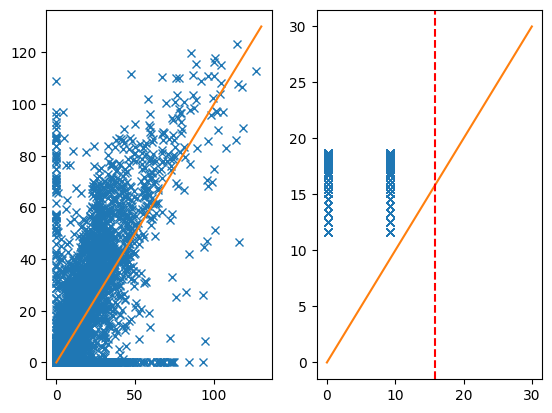

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.708  0.418E+00    31968   101.63  0.397   [Radiance 0.660 micron]
     2  -1.282  0.456E+00    31968   101.63  0.397   [Radiance 0.660 micron]
     3  -1.672  0.471E+00    31968   101.63  0.397   [Radiance 0.660 micron]
     4  -1.951  0.293E+00    32059   102.07  0.399   [Radiance 0.660 micron]
     5  -2.376  0.156E+00    32559   104.29  0.407   [Radiance 0.660 micron]
     6  -2.352  0.782E-01    35438   115.58  0.451   [Radiance 0.660 micron]
     7  -2.388  0.564E-01    38934   127.25  0.497   [Radiance 0.660 micron]
     8  -2.542  0.464E-01    41979   135.79  0.530   [Radiance 0.660 micron]
     9  -2.580  0.367E-01    46983   147.55  0.576   [Radiance 0.660 micron]
    10  -2.687  0.315E-01    51252   155.72  0.608   [Radiance 0.660 micron]
    11  -2.867  0.300E-01    52841   158.38  0.619   [Radiance 0.660 micron]
    12  -3.156  0.300E-01    52899   158.47  0.619   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

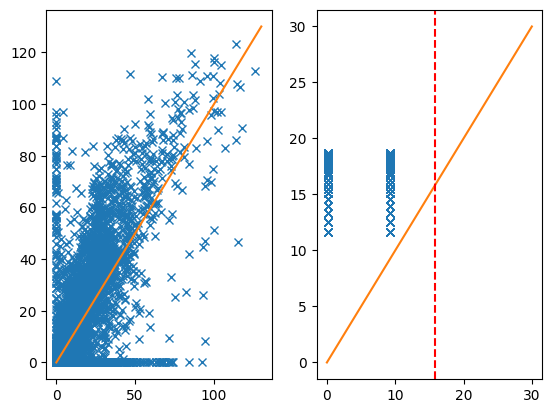

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.711  0.420E+00    31968    98.12  0.383   [Radiance 0.660 micron]
     2  -1.284  0.459E+00    31968    98.12  0.383   [Radiance 0.660 micron]
     3  -1.673  0.474E+00    31968    98.12  0.383   [Radiance 0.660 micron]
     4  -1.951  0.293E+00    32063    98.58  0.385   [Radiance 0.660 micron]
     5  -2.370  0.157E+00    32565   100.88  0.394   [Radiance 0.660 micron]
     6  -2.346  0.787E-01    35483   112.54  0.440   [Radiance 0.660 micron]
     7  -2.385  0.569E-01    38899   124.21  0.485   [Radiance 0.660 micron]
     8  -2.541  0.468E-01    41987   133.07  0.520   [Radiance 0.660 micron]
     9  -2.573  0.369E-01    47057   145.24  0.567   [Radiance 0.660 micron]
    10  -2.685  0.318E-01    51286   153.48  0.600   [Radiance 0.660 micron]
    11  -2.864  0.300E-01    53173   156.77  0.612   [Radiance 0.660 micron]
    12  -3.145  0.300E-01    53240   156.85  0.613   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

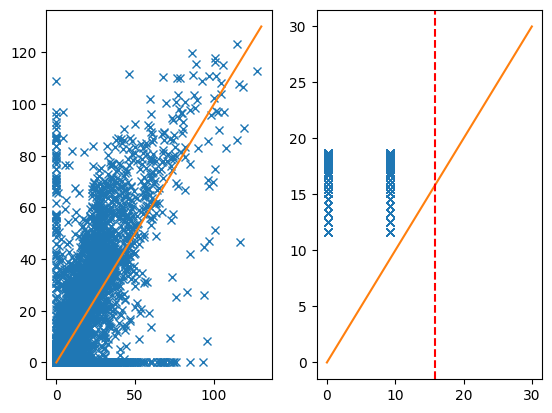

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.713  0.424E+00    31968    97.11  0.379   [Radiance 0.660 micron]
     2  -1.287  0.462E+00    31968    97.11  0.379   [Radiance 0.660 micron]
     3  -1.674  0.478E+00    31968    97.11  0.379   [Radiance 0.660 micron]
     4  -1.950  0.296E+00    32064    97.58  0.381   [Radiance 0.660 micron]
     5  -2.361  0.158E+00    32606   100.06  0.391   [Radiance 0.660 micron]
     6  -2.333  0.795E-01    35553   111.84  0.437   [Radiance 0.660 micron]
     7  -2.382  0.579E-01    38919   123.45  0.482   [Radiance 0.660 micron]
     8  -2.519  0.473E-01    42139   132.67  0.518   [Radiance 0.660 micron]
     9  -2.572  0.378E-01    46991   144.41  0.564   [Radiance 0.660 micron]
    10  -2.663  0.322E-01    51512   153.23  0.599   [Radiance 0.660 micron]
    11  -2.820  0.300E-01    53971   157.44  0.615   [Radiance 0.660 micron]
    12  -3.080  0.300E-01    54083   157.60  0.616   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

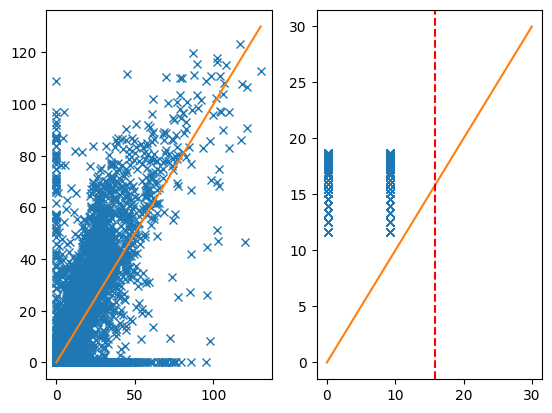

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.713  0.429E+00    31968   101.01  0.395   [Radiance 0.660 micron]
     2  -1.289  0.467E+00    31968   101.01  0.395   [Radiance 0.660 micron]
     3  -1.675  0.482E+00    31968   101.01  0.395   [Radiance 0.660 micron]
     4  -1.948  0.298E+00    32061   101.46  0.396   [Radiance 0.660 micron]
     5  -2.351  0.159E+00    32643   104.08  0.407   [Radiance 0.660 micron]
     6  -2.324  0.806E-01    35697   115.89  0.453   [Radiance 0.660 micron]
     7  -2.372  0.588E-01    39072   127.01  0.496   [Radiance 0.660 micron]
     8  -2.496  0.481E-01    42273   136.02  0.531   [Radiance 0.660 micron]
     9  -2.569  0.389E-01    47007   146.84  0.574   [Radiance 0.660 micron]
    10  -2.652  0.328E-01    51911   156.12  0.610   [Radiance 0.660 micron]
    11  -2.792  0.300E-01    55136   161.31  0.630   [Radiance 0.660 micron]
    12  -3.108  0.300E-01    55276   161.50  0.631   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

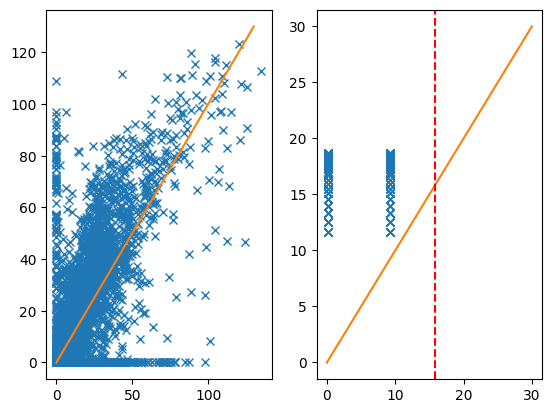

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.713  0.430E+00    31968    99.21  0.388   [Radiance 0.660 micron]
     2  -1.287  0.467E+00    31968    99.21  0.388   [Radiance 0.660 micron]
     3  -1.673  0.483E+00    31968    99.21  0.388   [Radiance 0.660 micron]
     4  -1.946  0.298E+00    32068    99.70  0.389   [Radiance 0.660 micron]
     5  -2.340  0.159E+00    32650   102.34  0.400   [Radiance 0.660 micron]
     6  -2.316  0.815E-01    35694   114.29  0.446   [Radiance 0.660 micron]
     7  -2.360  0.596E-01    39143   125.76  0.491   [Radiance 0.660 micron]
     8  -2.499  0.490E-01    42132   134.29  0.525   [Radiance 0.660 micron]
     9  -2.550  0.392E-01    47154   145.90  0.570   [Radiance 0.660 micron]
    10  -2.678  0.334E-01    51686   154.69  0.604   [Radiance 0.660 micron]
    11  -2.762  0.300E-01    55708   161.29  0.630   [Radiance 0.660 micron]
    12  -3.096  0.300E-01    55878   161.49  0.631   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

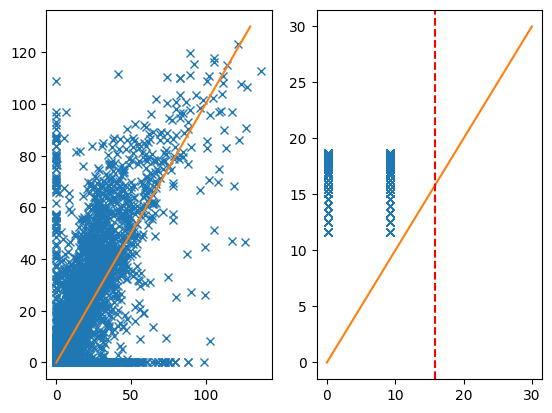

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.713  0.430E+00    31968   100.52  0.393   [Radiance 0.660 micron]
     2  -1.287  0.466E+00    31968   100.52  0.393   [Radiance 0.660 micron]
     3  -1.673  0.482E+00    31968   100.52  0.393   [Radiance 0.660 micron]
     4  -1.945  0.297E+00    32070   101.01  0.395   [Radiance 0.660 micron]
     5  -2.336  0.159E+00    32651   103.61  0.405   [Radiance 0.660 micron]
     6  -2.314  0.818E-01    35731   115.59  0.452   [Radiance 0.660 micron]
     7  -2.353  0.598E-01    39168   126.89  0.496   [Radiance 0.660 micron]
     8  -2.493  0.494E-01    42118   135.21  0.528   [Radiance 0.660 micron]
     9  -2.554  0.395E-01    47023   146.60  0.573   [Radiance 0.660 micron]
    10  -2.667  0.335E-01    51804   155.68  0.608   [Radiance 0.660 micron]
    11  -2.762  0.300E-01    56094   162.66  0.635   [Radiance 0.660 micron]
    12  -3.070  0.300E-01    56283   162.87  0.636   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

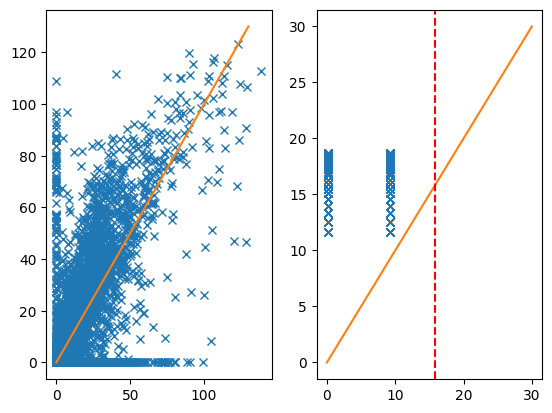

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.713  0.428E+00    31968    95.20  0.372   [Radiance 0.660 micron]
     2  -1.286  0.464E+00    31968    95.20  0.372   [Radiance 0.660 micron]
     3  -1.670  0.479E+00    31968    95.20  0.372   [Radiance 0.660 micron]
     4  -1.941  0.297E+00    32070    95.70  0.374   [Radiance 0.660 micron]
     5  -2.329  0.160E+00    32664    98.43  0.384   [Radiance 0.660 micron]
     6  -2.306  0.824E-01    35749   110.88  0.433   [Radiance 0.660 micron]
     7  -2.348  0.604E-01    39177   122.50  0.479   [Radiance 0.660 micron]
     8  -2.488  0.498E-01    42130   131.11  0.512   [Radiance 0.660 micron]
     9  -2.565  0.399E-01    46953   142.67  0.557   [Radiance 0.660 micron]
    10  -2.644  0.333E-01    52363   153.30  0.599   [Radiance 0.660 micron]
    11  -2.757  0.300E-01    56479   159.99  0.625   [Radiance 0.660 micron]
    12  -3.076  0.300E-01    56636   160.19  0.626   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

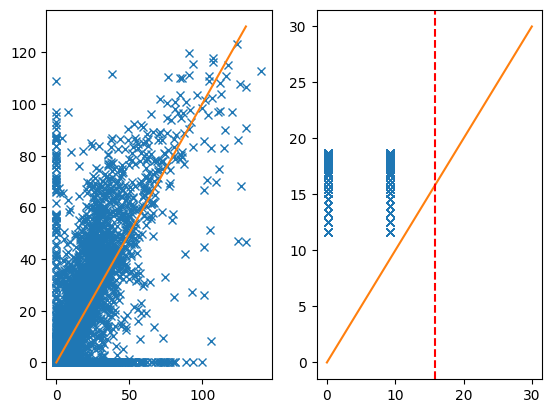

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.711  0.425E+00    31968    95.62  0.374   [Radiance 0.660 micron]
     2  -1.284  0.461E+00    31968    95.62  0.374   [Radiance 0.660 micron]
     3  -1.668  0.479E+00    31968    95.62  0.374   [Radiance 0.660 micron]
     4  -1.939  0.296E+00    32065    96.10  0.375   [Radiance 0.660 micron]
     5  -2.326  0.159E+00    32667    98.88  0.386   [Radiance 0.660 micron]
     6  -2.307  0.825E-01    35791   111.41  0.435   [Radiance 0.660 micron]
     7  -2.348  0.604E-01    39209   122.99  0.480   [Radiance 0.660 micron]
     8  -2.490  0.498E-01    42218   131.56  0.514   [Radiance 0.660 micron]
     9  -2.552  0.398E-01    47108   143.29  0.560   [Radiance 0.660 micron]
    10  -2.654  0.337E-01    52042   152.99  0.598   [Radiance 0.660 micron]
    11  -2.747  0.300E-01    56662   160.56  0.627   [Radiance 0.660 micron]
    12  -3.062  0.300E-01    56887   160.86  0.628   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

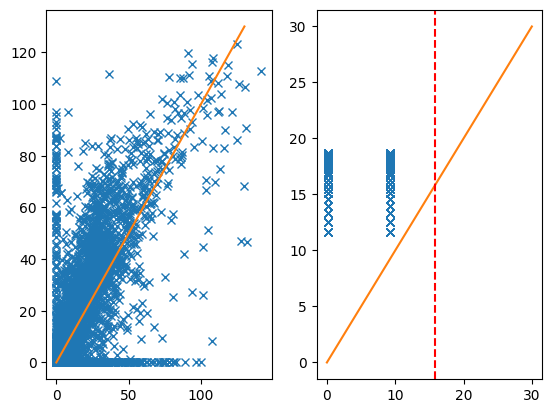

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.712  0.422E+00    31968    94.10  0.368   [Radiance 0.660 micron]
     2  -1.284  0.461E+00    31968    94.10  0.368   [Radiance 0.660 micron]
     3  -1.667  0.482E+00    31968    94.10  0.368   [Radiance 0.660 micron]
     4  -1.938  0.296E+00    32067    94.58  0.369   [Radiance 0.660 micron]
     5  -2.326  0.160E+00    32672    97.41  0.380   [Radiance 0.660 micron]
     6  -2.297  0.826E-01    35804   110.03  0.430   [Radiance 0.660 micron]
     7  -2.349  0.609E-01    39131   121.35  0.474   [Radiance 0.660 micron]
     8  -2.485  0.500E-01    42225   130.23  0.509   [Radiance 0.660 micron]
     9  -2.550  0.401E-01    47016   141.97  0.555   [Radiance 0.660 micron]
    10  -2.640  0.338E-01    52153   152.00  0.594   [Radiance 0.660 micron]
    11  -2.733  0.300E-01    56803   159.73  0.624   [Radiance 0.660 micron]
    12  -3.058  0.300E-01    56998   159.96  0.625   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

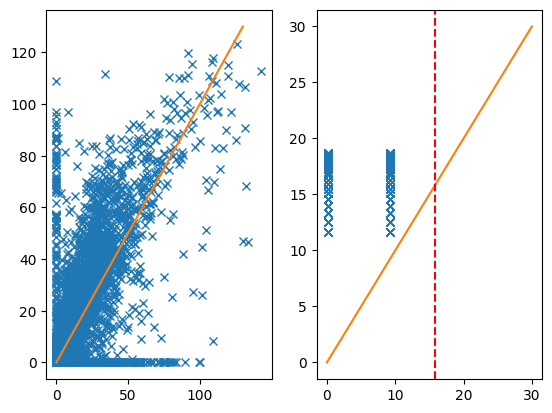

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.713  0.421E+00    31968    95.14  0.372   [Radiance 0.660 micron]
     2  -1.285  0.463E+00    31968    95.14  0.372   [Radiance 0.660 micron]
     3  -1.667  0.485E+00    31968    95.14  0.372   [Radiance 0.660 micron]
     4  -1.938  0.298E+00    32061    95.59  0.373   [Radiance 0.660 micron]
     5  -2.329  0.160E+00    32672    98.41  0.384   [Radiance 0.660 micron]
     6  -2.295  0.824E-01    35863   111.19  0.434   [Radiance 0.660 micron]
     7  -2.352  0.611E-01    39132   122.26  0.478   [Radiance 0.660 micron]
     8  -2.489  0.499E-01    42371   131.39  0.513   [Radiance 0.660 micron]
     9  -2.537  0.399E-01    47211   143.02  0.559   [Radiance 0.660 micron]
    10  -2.648  0.342E-01    52014   152.49  0.596   [Radiance 0.660 micron]
    11  -2.728  0.300E-01    56970   160.53  0.627   [Radiance 0.660 micron]
    12  -3.055  0.300E-01    57166   160.75  0.628   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

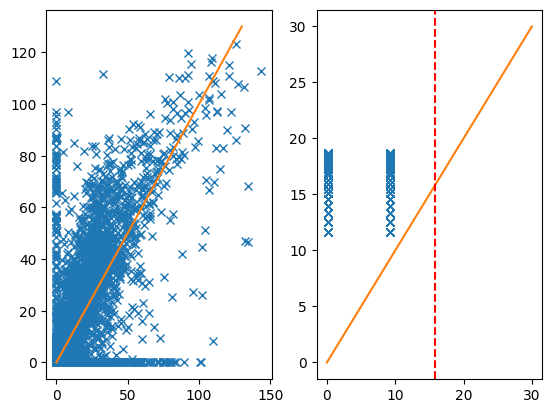

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.712  0.422E+00    31968    98.91  0.386   [Radiance 0.660 micron]
     2  -1.285  0.465E+00    31968    98.91  0.386   [Radiance 0.660 micron]
     3  -1.667  0.487E+00    31968    98.91  0.386   [Radiance 0.660 micron]
     4  -1.937  0.299E+00    32060    99.35  0.388   [Radiance 0.660 micron]
     5  -2.328  0.161E+00    32669   102.09  0.399   [Radiance 0.660 micron]
     6  -2.293  0.827E-01    35875   114.63  0.448   [Radiance 0.660 micron]
     7  -2.355  0.613E-01    39147   125.42  0.490   [Radiance 0.660 micron]
     8  -2.488  0.499E-01    42399   134.38  0.525   [Radiance 0.660 micron]
     9  -2.540  0.399E-01    47301   145.81  0.570   [Radiance 0.660 micron]
    10  -2.639  0.341E-01    52207   155.20  0.606   [Radiance 0.660 micron]
    11  -2.729  0.300E-01    57079   162.94  0.636   [Radiance 0.660 micron]
    12  -3.051  0.300E-01    57270   163.14  0.637   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

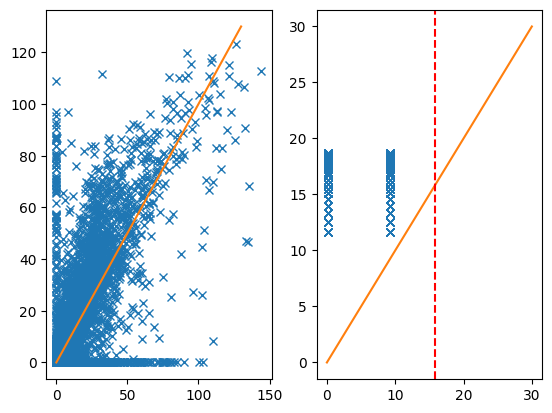

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.714  0.425E+00    31968    93.60  0.366   [Radiance 0.660 micron]
     2  -1.287  0.469E+00    31968    93.60  0.366   [Radiance 0.660 micron]
     3  -1.666  0.493E+00    31968    93.60  0.366   [Radiance 0.660 micron]
     4  -1.936  0.302E+00    32060    94.05  0.367   [Radiance 0.660 micron]
     5  -2.327  0.162E+00    32675    96.91  0.379   [Radiance 0.660 micron]
     6  -2.289  0.831E-01    35921   110.02  0.430   [Radiance 0.660 micron]
     7  -2.355  0.617E-01    39186   121.07  0.473   [Radiance 0.660 micron]
     8  -2.477  0.501E-01    42450   130.38  0.509   [Radiance 0.660 micron]
     9  -2.551  0.404E-01    47246   141.89  0.554   [Radiance 0.660 micron]
    10  -2.629  0.340E-01    52685   152.52  0.596   [Radiance 0.660 micron]
    11  -2.730  0.300E-01    57479   160.27  0.626   [Radiance 0.660 micron]
    12  -3.051  0.300E-01    57654   160.50  0.627   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

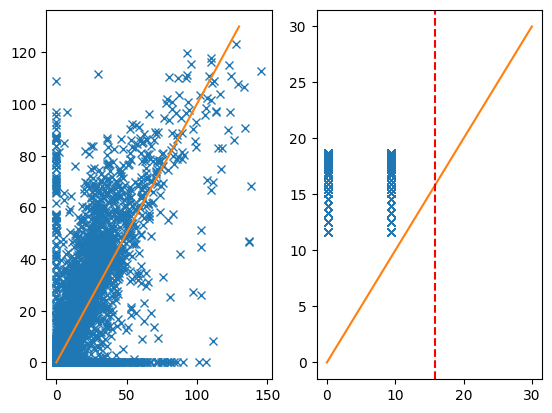

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.716  0.428E+00    31968    97.00  0.379   [Radiance 0.660 micron]
     2  -1.290  0.475E+00    31968    97.00  0.379   [Radiance 0.660 micron]
     3  -1.669  0.500E+00    31968    97.00  0.379   [Radiance 0.660 micron]
     4  -1.938  0.299E+00    32064    97.47  0.381   [Radiance 0.660 micron]
     5  -2.329  0.162E+00    32688   100.31  0.392   [Radiance 0.660 micron]
     6  -2.281  0.832E-01    36080   113.61  0.444   [Radiance 0.660 micron]
     7  -2.357  0.622E-01    39236   123.89  0.484   [Radiance 0.660 micron]
     8  -2.476  0.502E-01    42738   133.73  0.522   [Radiance 0.660 micron]
     9  -2.546  0.405E-01    47612   144.99  0.566   [Radiance 0.660 micron]
    10  -2.615  0.341E-01    52943   155.08  0.606   [Radiance 0.660 micron]
    11  -2.729  0.300E-01    58139   163.21  0.638   [Radiance 0.660 micron]
    12  -3.038  0.300E-01    58364   163.50  0.639   [Radiance 0.660 micron]
  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.715  0.425E+00    31968   104.76  0.409   [Radiance 0.660 micron]
     2  -1.289  0.469E+00    31968   104.76  0.409   [Radiance 0.660 micron]
     3  -1.669  0.493E+00    31968   104.76  0.409   [Radiance 0.660 micron]
     4  -1.939  0.297E+00    32062   105.20  0.411   [Radiance 0.660 micron]
     5  -2.330  0.161E+00    32679   107.86  0.421   [Radiance 0.660 micron]
     6  -2.290  0.827E-01    35977   120.28  0.470   [Radiance 0.660 micron]
     7  -2.358  0.615E-01    39202   130.42  0.509   [Radiance 0.660 micron]
     8  -2.478  0.498E-01    42519   139.25  0.544   [Radiance 0.660 micron]
     9  -2.553  0.403E-01    47328   150.00  0.586   [Radiance 0.660 micron]
    10  -2.633  0.338E-01    52806   159.92  0.625   [Radiance 0.660 micron]
    11  -2.735  0.300E-01    57442   166.95  0.652   [Radiance 0.660 micron]
    12  -3.047  0.300E-01    57636   167.20  0.653   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

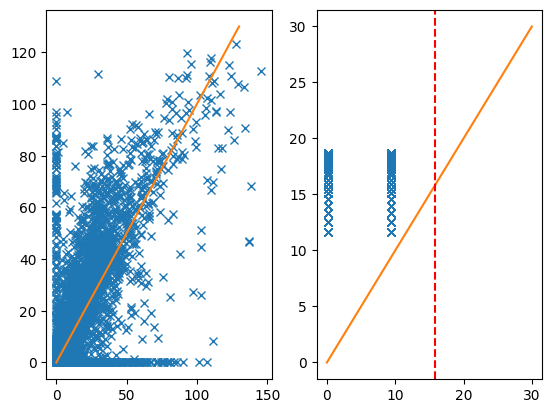

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.718  0.424E+00    31968    96.24  0.376   [Radiance 0.660 micron]
     2  -1.290  0.469E+00    31968    96.24  0.376   [Radiance 0.660 micron]
     3  -1.670  0.493E+00    31968    96.24  0.376   [Radiance 0.660 micron]
     4  -1.940  0.299E+00    32062    96.70  0.378   [Radiance 0.660 micron]
     5  -2.329  0.160E+00    32682    99.53  0.389   [Radiance 0.660 micron]
     6  -2.290  0.827E-01    35982   112.67  0.440   [Radiance 0.660 micron]
     7  -2.357  0.614E-01    39195   123.35  0.482   [Radiance 0.660 micron]
     8  -2.479  0.499E-01    42498   132.65  0.518   [Radiance 0.660 micron]
     9  -2.550  0.402E-01    47337   144.08  0.563   [Radiance 0.660 micron]
    10  -2.634  0.339E-01    52711   154.42  0.603   [Radiance 0.660 micron]
    11  -2.728  0.300E-01    57447   162.01  0.633   [Radiance 0.660 micron]
    12  -3.056  0.300E-01    57626   162.25  0.634   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

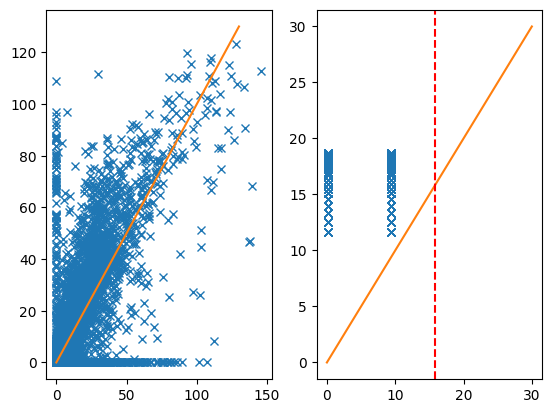

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.720  0.424E+00    31968   100.63  0.393   [Radiance 0.660 micron]
     2  -1.294  0.470E+00    31968   100.63  0.393   [Radiance 0.660 micron]
     3  -1.673  0.494E+00    31968   100.63  0.393   [Radiance 0.660 micron]
     4  -1.942  0.296E+00    32064   101.09  0.395   [Radiance 0.660 micron]
     5  -2.332  0.160E+00    32691   103.87  0.406   [Radiance 0.660 micron]
     6  -2.291  0.823E-01    36048   116.82  0.456   [Radiance 0.660 micron]
     7  -2.361  0.613E-01    39207   127.06  0.496   [Radiance 0.660 micron]
     8  -2.481  0.496E-01    42597   136.27  0.532   [Radiance 0.660 micron]
     9  -2.538  0.401E-01    47449   147.38  0.576   [Radiance 0.660 micron]
    10  -2.644  0.342E-01    52318   156.48  0.611   [Radiance 0.660 micron]
    11  -2.728  0.300E-01    57415   164.53  0.643   [Radiance 0.660 micron]
    12  -3.052  0.300E-01    57611   164.78  0.644   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

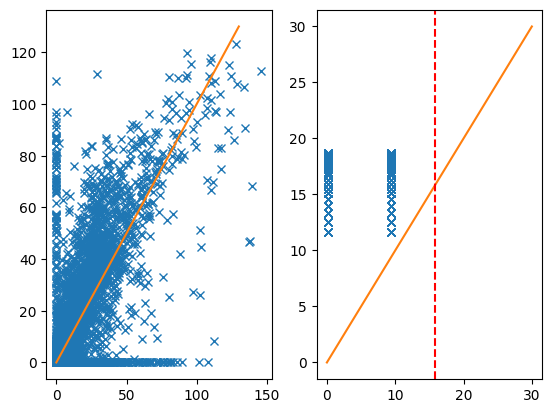

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.721  0.425E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     2  -1.294  0.471E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     3  -1.673  0.495E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     4  -1.942  0.299E+00    32062    99.27  0.388   [Radiance 0.660 micron]
     5  -2.334  0.160E+00    32699   102.16  0.399   [Radiance 0.660 micron]
     6  -2.287  0.822E-01    36078   115.25  0.450   [Radiance 0.660 micron]
     7  -2.364  0.615E-01    39166   125.41  0.490   [Radiance 0.660 micron]
     8  -2.474  0.496E-01    42650   134.93  0.527   [Radiance 0.660 micron]
     9  -2.550  0.403E-01    47292   145.66  0.569   [Radiance 0.660 micron]
    10  -2.622  0.339E-01    52584   155.73  0.608   [Radiance 0.660 micron]
    11  -2.740  0.300E-01    57433   163.43  0.638   [Radiance 0.660 micron]
    12  -3.049  0.300E-01    57629   163.69  0.639   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

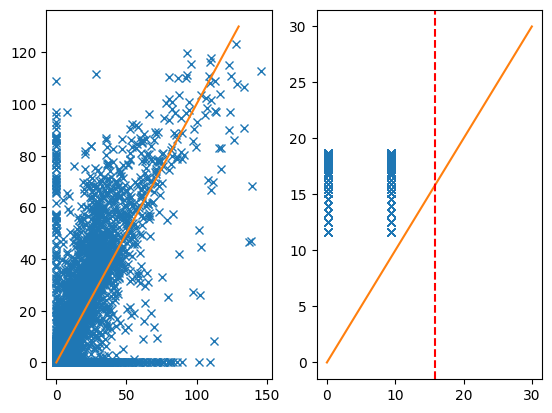


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28351     50     74  57654     0 15758   4.687D-01   5.413D+03
  F =   5413.3638908870507     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [8]:
solvers_reconstruct = at3d.containers.SolversDict()
# We are using the ground_truth rte_grid.
grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, optical_properties
)

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e9)
sensors.add_uncertainty_model('MSPI', uncertainty)

# UnknownScatterers is a container for all of the unknown variables.
# Each unknown_scatterer also records the transforms from the abstract state vector
# to the gridded data in physical coordinates.
unknown_scatterers = at3d.containers.UnknownScatterers(
    at3d.medium.UnknownScatterer(grid_to_optical_properties,
    density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
    reff=(None, at3d.transforms.StateToGridUniform(mask=carved_volume.mask.data)))
)
# now we form state_gen which updates the solvers with an input_state.

state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                        unknown_scatterers, surfaces,
                                        numerical_parameters, sources, background_optical_scatterers,
                                        num_stokes)
# get bounds automatically.
min_bounds, max_bounds = state_gen.transform_bounds()
# transform initial physical state to abstract state. 
initial_gridded_extinction = solvers[0.66].medium['cloud'].density.data*0
initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
initial_gridded_reff = solvers[0.66].medium['cloud'].reff.data*0 + 10
initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
            state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))
objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
    sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
    state_gen.project_gradient_to_state,
        parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bounds, max_bounds=max_bounds)
optimizer = at3d.optimize.Optimizer(objective_function,callback_fn=callback, options={'maxiter': 100, 'maxls': 10, 'disp': True, 'gtol': 1e-16, 'ftol': 1e-8})
warnings.filterwarnings('ignore')
optimizer._options['maxiter'] = 50
result = optimizer.minimize(x0)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.719  0.421E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     2  -1.293  0.467E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     3  -1.675  0.491E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     4  -1.947  0.297E+00    32060    99.26  0.388   [Radiance 0.660 micron]
     5  -2.341  0.159E+00    32686   102.10  0.399   [Radiance 0.660 micron]
     6  -2.290  0.813E-01    35989   114.95  0.449   [Radiance 0.660 micron]
     7  -2.365  0.609E-01    39038   125.02  0.488   [Radiance 0.660 micron]
     8  -2.476  0.493E-01    42360   134.19  0.524   [Radiance 0.660 micron]
     9  -2.555  0.401E-01    46859   144.79  0.566   [Radiance 0.660 micron]
    10  -2.636  0.337E-01    52073   154.89  0.605   [Radiance 0.660 micron]
    11  -2.727  0.300E-01    56530   162.08  0.633   [Radiance 0.660 micron]
    12  -3.064  0.300E-01    56695   162.29  0.634   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

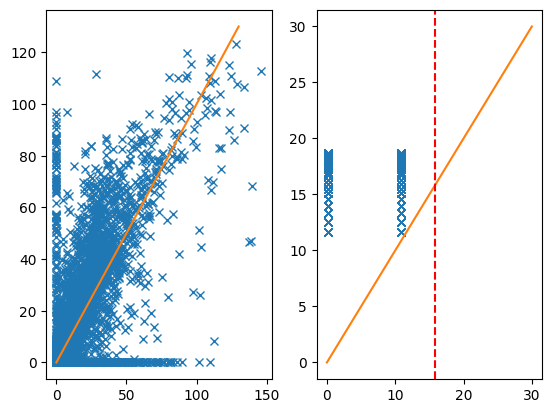

5470.588863739757
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.719  0.420E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     2  -1.293  0.466E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     3  -1.676  0.489E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     4  -1.949  0.294E+00    32060    99.26  0.388   [Radiance 0.660 micron]
     5  -2.344  0.158E+00    32683   102.09  0.399   [Radiance 0.660 micron]
     6  -2.293  0.808E-01    35934   114.76  0.448   [Radiance 0.660 micron]
     7  -2.364  0.606E-01    38972   124.82  0.488   [Radiance 0.660 micron]
     8  -2.482  0.492E-01    42193   133.81  0.523   [Radiance 0.660 micron]
     9  -2.554  0.399E-01    46712   144.50  0.564   [Radiance 0.660 micron]
    10  -2.640  0.336E-01    51764   154.37  0.603   [Radiance 0.660 micron]
    11  -2.732  0.300E-01    56044   161.35  0.630   [Radiance 0.660 micron]
    12  -3.069  0.300E-01    56188   161.52  0.631   [Radianc

<Figure size 640x480 with 0 Axes>

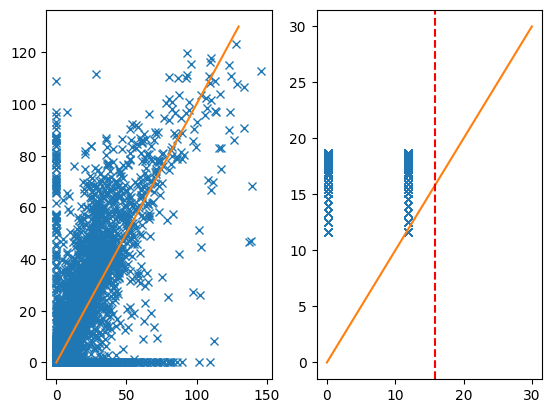

5765.702017867616
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.718  0.418E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     2  -1.292  0.464E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     3  -1.678  0.488E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     4  -1.951  0.292E+00    32060    99.26  0.388   [Radiance 0.660 micron]
     5  -2.347  0.157E+00    32678   102.06  0.399   [Radiance 0.660 micron]
     6  -2.295  0.804E-01    35898   114.63  0.448   [Radiance 0.660 micron]
     7  -2.362  0.603E-01    38898   124.58  0.487   [Radiance 0.660 micron]
     8  -2.487  0.491E-01    42044   133.49  0.521   [Radiance 0.660 micron]
     9  -2.551  0.397E-01    46571   144.22  0.563   [Radiance 0.660 micron]
    10  -2.642  0.336E-01    51435   153.79  0.601   [Radiance 0.660 micron]
    11  -2.736  0.300E-01    55571   160.66  0.628   [Radiance 0.660 micron]
    12  -3.067  0.300E-01    55730   160.86  0.628   [Radianc

<Figure size 640x480 with 0 Axes>

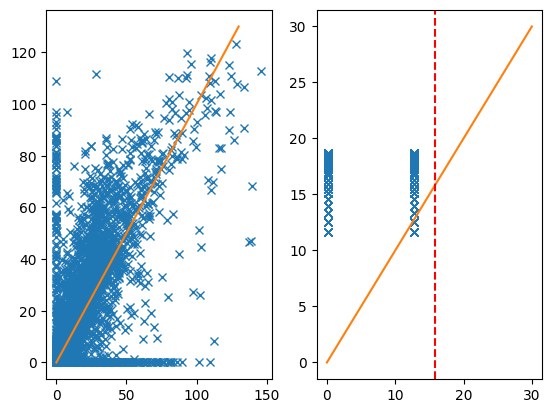

6174.905908545792
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.717  0.417E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     2  -1.292  0.463E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     3  -1.678  0.486E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     4  -1.953  0.290E+00    32060    99.26  0.388   [Radiance 0.660 micron]
     5  -2.350  0.157E+00    32668   102.01  0.398   [Radiance 0.660 micron]
     6  -2.297  0.800E-01    35853   114.46  0.447   [Radiance 0.660 micron]
     7  -2.362  0.600E-01    38859   124.45  0.486   [Radiance 0.660 micron]
     8  -2.492  0.490E-01    41947   133.23  0.520   [Radiance 0.660 micron]
     9  -2.549  0.394E-01    46500   144.05  0.563   [Radiance 0.660 micron]
    10  -2.649  0.336E-01    51187   153.34  0.599   [Radiance 0.660 micron]
    11  -2.733  0.300E-01    55328   160.28  0.626   [Radiance 0.660 micron]
    12  -3.069  0.300E-01    55483   160.48  0.627   [Radianc

<Figure size 640x480 with 0 Axes>

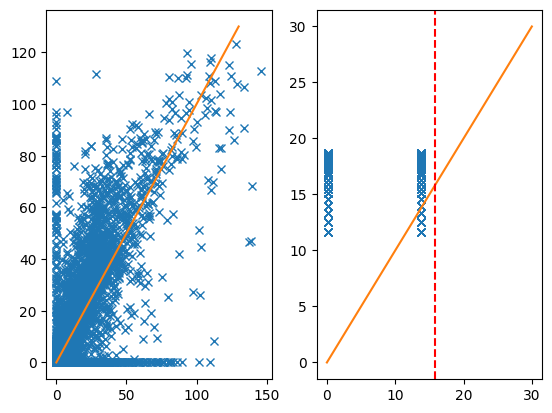

6653.218247204263
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.717  0.416E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     2  -1.292  0.461E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     3  -1.679  0.485E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     4  -1.955  0.289E+00    32060    99.26  0.388   [Radiance 0.660 micron]
     5  -2.352  0.156E+00    32662   101.99  0.398   [Radiance 0.660 micron]
     6  -2.298  0.798E-01    35821   114.34  0.447   [Radiance 0.660 micron]
     7  -2.363  0.599E-01    38809   124.30  0.486   [Radiance 0.660 micron]
     8  -2.492  0.489E-01    41892   133.08  0.520   [Radiance 0.660 micron]
     9  -2.556  0.394E-01    46372   143.78  0.562   [Radiance 0.660 micron]
    10  -2.646  0.334E-01    51174   153.31  0.599   [Radiance 0.660 micron]
    11  -2.745  0.300E-01    55015   159.80  0.624   [Radiance 0.660 micron]
    12  -3.072  0.300E-01    55166   160.01  0.625   [Radianc

<Figure size 640x480 with 0 Axes>

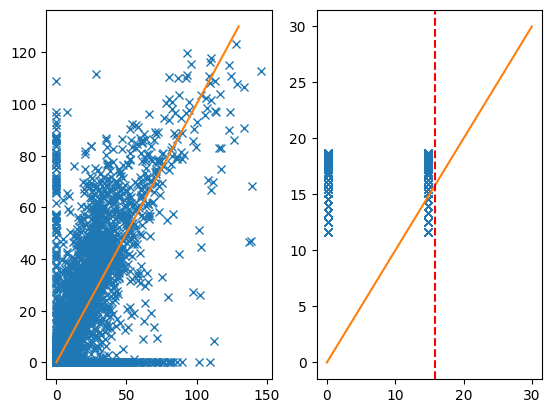

7162.470268528067
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.717  0.415E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     2  -1.291  0.460E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     3  -1.680  0.483E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     4  -1.956  0.287E+00    32060    99.26  0.388   [Radiance 0.660 micron]
     5  -2.355  0.156E+00    32649   101.95  0.398   [Radiance 0.660 micron]
     6  -2.302  0.795E-01    35784   114.20  0.446   [Radiance 0.660 micron]
     7  -2.361  0.595E-01    38803   124.28  0.485   [Radiance 0.660 micron]
     8  -2.494  0.489E-01    41788   132.80  0.519   [Radiance 0.660 micron]
     9  -2.558  0.393E-01    46265   143.59  0.561   [Radiance 0.660 micron]
    10  -2.644  0.333E-01    51062   153.10  0.598   [Radiance 0.660 micron]
    11  -2.748  0.300E-01    54824   159.48  0.623   [Radiance 0.660 micron]
    12  -3.072  0.300E-01    54989   159.73  0.624   [Radianc

<Figure size 640x480 with 0 Axes>

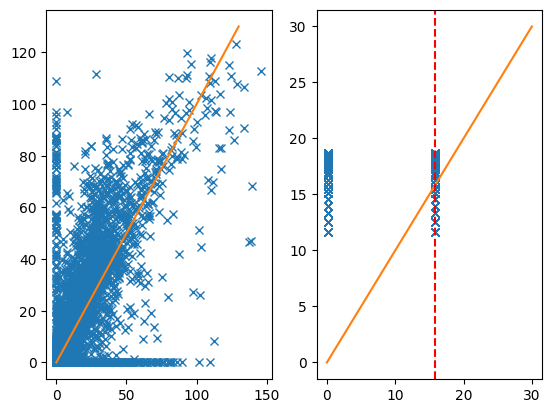

7691.757686599219
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.716  0.414E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     2  -1.291  0.459E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     3  -1.680  0.482E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     4  -1.957  0.286E+00    32060    99.26  0.388   [Radiance 0.660 micron]
     5  -2.356  0.155E+00    32648   101.94  0.398   [Radiance 0.660 micron]
     6  -2.303  0.792E-01    35768   114.14  0.446   [Radiance 0.660 micron]
     7  -2.361  0.594E-01    38774   124.19  0.485   [Radiance 0.660 micron]
     8  -2.494  0.488E-01    41713   132.61  0.518   [Radiance 0.660 micron]
     9  -2.561  0.392E-01    46123   143.25  0.560   [Radiance 0.660 micron]
    10  -2.644  0.332E-01    50964   152.94  0.597   [Radiance 0.660 micron]
    11  -2.751  0.300E-01    54614   159.14  0.622   [Radiance 0.660 micron]
    12  -3.067  0.300E-01    54778   159.38  0.623   [Radianc

<Figure size 640x480 with 0 Axes>

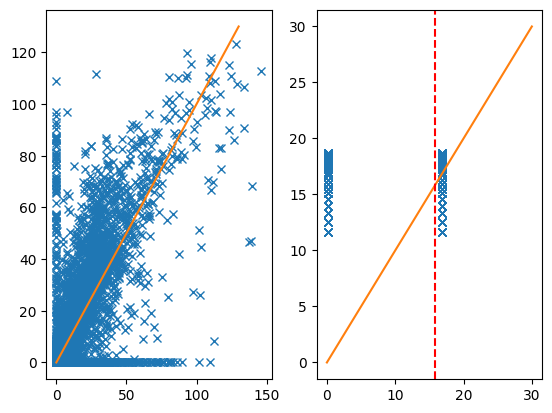

8236.887497894026
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.716  0.413E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     2  -1.291  0.459E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     3  -1.681  0.481E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     4  -1.958  0.285E+00    32060    99.26  0.388   [Radiance 0.660 micron]
     5  -2.358  0.155E+00    32641   101.92  0.398   [Radiance 0.660 micron]
     6  -2.305  0.790E-01    35753   114.09  0.446   [Radiance 0.660 micron]
     7  -2.360  0.592E-01    38757   124.16  0.485   [Radiance 0.660 micron]
     8  -2.495  0.487E-01    41678   132.51  0.518   [Radiance 0.660 micron]
     9  -2.560  0.392E-01    46058   143.12  0.559   [Radiance 0.660 micron]
    10  -2.651  0.332E-01    50789   152.63  0.596   [Radiance 0.660 micron]
    11  -2.750  0.300E-01    54403   158.81  0.620   [Radiance 0.660 micron]
    12  -3.068  0.300E-01    54557   159.04  0.621   [Radianc

<Figure size 640x480 with 0 Axes>

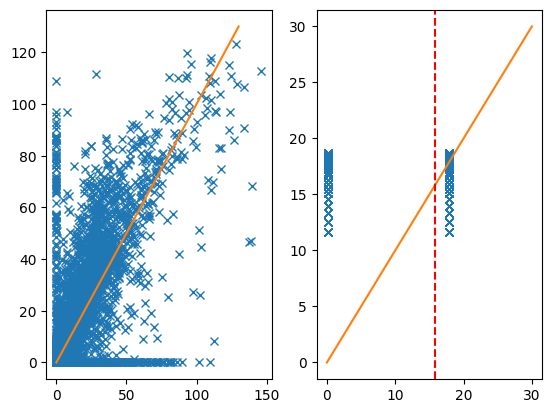

8763.32812740794
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.715  0.412E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     2  -1.291  0.458E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     3  -1.681  0.480E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     4  -1.959  0.284E+00    32060    99.26  0.388   [Radiance 0.660 micron]
     5  -2.360  0.155E+00    32633   101.88  0.398   [Radiance 0.660 micron]
     6  -2.305  0.788E-01    35726   114.01  0.445   [Radiance 0.660 micron]
     7  -2.360  0.591E-01    38716   124.03  0.484   [Radiance 0.660 micron]
     8  -2.496  0.487E-01    41609   132.31  0.517   [Radiance 0.660 micron]
     9  -2.558  0.392E-01    45999   143.00  0.559   [Radiance 0.660 micron]
    10  -2.652  0.332E-01    50585   152.26  0.595   [Radiance 0.660 micron]
    11  -2.748  0.300E-01    54199   158.48  0.619   [Radiance 0.660 micron]
    12  -3.070  0.300E-01    54373   158.76  0.620   [Radiance

<Figure size 640x480 with 0 Axes>

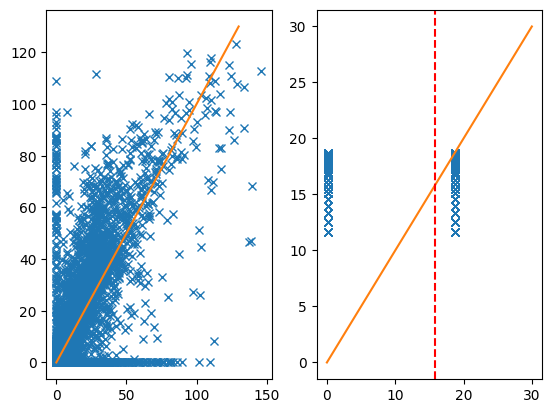

9277.035000072086
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.715  0.412E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     2  -1.291  0.457E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     3  -1.682  0.480E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     4  -1.959  0.283E+00    32060    99.26  0.388   [Radiance 0.660 micron]
     5  -2.362  0.154E+00    32626   101.85  0.398   [Radiance 0.660 micron]
     6  -2.305  0.786E-01    35719   113.98  0.445   [Radiance 0.660 micron]
     7  -2.361  0.590E-01    38663   123.87  0.484   [Radiance 0.660 micron]
     8  -2.497  0.486E-01    41576   132.23  0.517   [Radiance 0.660 micron]
     9  -2.561  0.391E-01    45919   142.83  0.558   [Radiance 0.660 micron]
    10  -2.647  0.331E-01    50559   152.22  0.595   [Radiance 0.660 micron]
    11  -2.754  0.300E-01    54019   158.20  0.618   [Radiance 0.660 micron]
    12  -3.073  0.300E-01    54168   158.44  0.619   [Radianc

<Figure size 640x480 with 0 Axes>

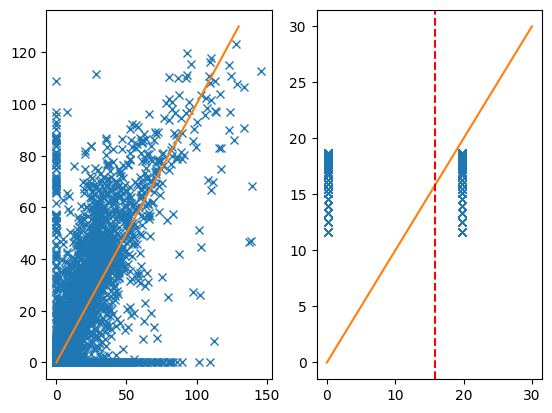

9770.681137705098


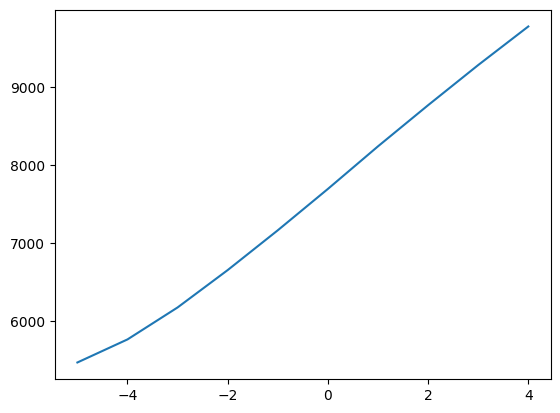

In [9]:
def get_loss_uniform(reff_diff):
    # We are using the ground_truth rte_grid.
    grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, optical_properties
    )

    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
        density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        reff=(None, at3d.transforms.StateToGridUniform(mask=carved_volume.mask.data)))
    )
    # now we form state_gen which updates the solvers with an input_state.

    state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                            unknown_scatterers, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    # get bounds automatically.
    min_bounds, max_bounds = state_gen.transform_bounds()
    # transform initial physical state to abstract state. 
    initial_gridded_extinction = solvers_reconstruct[.66].medium['cloud'].density.data
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    initial_gridded_reff = solvers[0.66].medium['cloud'].reff.data*0 + solvers[0.66].medium['cloud'].reff.data.ravel().mean() + reff_diff
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))
    objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
        state_gen.project_gradient_to_state,
            parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bounds, max_bounds=max_bounds)
    # solvers_reconstruct[0.66].medium['cloud'].reff.data = solvers[0.66].medium['cloud'].reff.data + reff_diff
    return objective_function(x0)[0]
losses = []
for i in range(-5, 5):
    losses.append(get_loss_uniform(i))
    plot(None)
    print(losses[i+5])
py.plot(range(-5, 5),losses)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.714  0.409E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     2  -1.290  0.454E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     3  -1.683  0.477E+00    31968    98.82  0.386   [Radiance 0.660 micron]
     4  -1.963  0.289E+00    32052    99.22  0.388   [Radiance 0.660 micron]
     5  -2.369  0.153E+00    32620   101.82  0.398   [Radiance 0.660 micron]
     6  -2.306  0.779E-01    35663   113.78  0.444   [Radiance 0.660 micron]
     7  -2.361  0.586E-01    38549   123.55  0.483   [Radiance 0.660 micron]
     8  -2.501  0.485E-01    41401   131.76  0.515   [Radiance 0.660 micron]
     9  -2.556  0.389E-01    45736   142.45  0.556   [Radiance 0.660 micron]
    10  -2.663  0.332E-01    49986   151.21  0.591   [Radiance 0.660 micron]
    11  -2.764  0.300E-01    53389   157.22  0.614   [Radiance 0.660 micron]
    12  -3.077  0.300E-01    53544   157.44  0.615   [Radiance 0.660 micron]
  


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28351      1     11    745     0 10358   5.146D+01   1.205D+04
  F =   12048.452909336329     

ABNORMAL_TERMINATION_IN_LNSRCH                              
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.719  0.421E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     2  -1.293  0.467E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     3  -1.675  0.491E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     4  -1.947  0.297E+00    32060   154.03  0.602   [Radiance 0.660 micron]
     5  -2.341  0.159E+00    32686   155.

<Figure size 640x480 with 0 Axes>

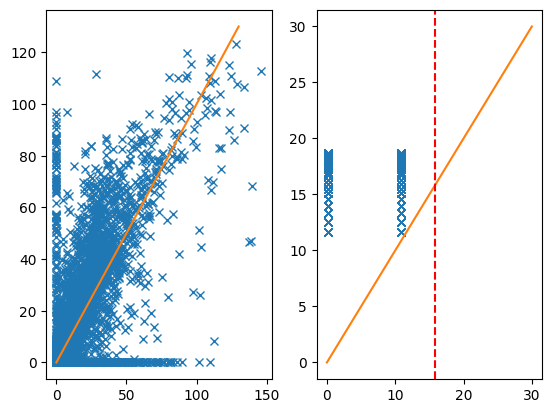

5470.288485700482
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.719  0.420E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     2  -1.293  0.466E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     3  -1.676  0.489E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     4  -1.949  0.294E+00    32060   154.03  0.602   [Radiance 0.660 micron]
     5  -2.345  0.158E+00    32683   155.83  0.609   [Radiance 0.660 micron]
     6  -2.293  0.808E-01    35937   163.95  0.640   [Radiance 0.660 micron]
     7  -2.367  0.605E-01    38979   170.43  0.666   [Radiance 0.660 micron]
     8  -2.481  0.491E-01    42235   176.27  0.689   [Radiance 0.660 micron]
     9  -2.556  0.399E-01    46721   183.09  0.715   [Radiance 0.660 micron]
    10  -2.640  0.336E-01    51798   189.49  0.740   [Radiance 0.660 micron]
    11  -2.735  0.300E-01    56046   193.96  0.758   [Radiance 0.660 micron]
    12  -3.072  0.300E-01    56186   194.06  0.758   [Radianc

<Figure size 640x480 with 0 Axes>

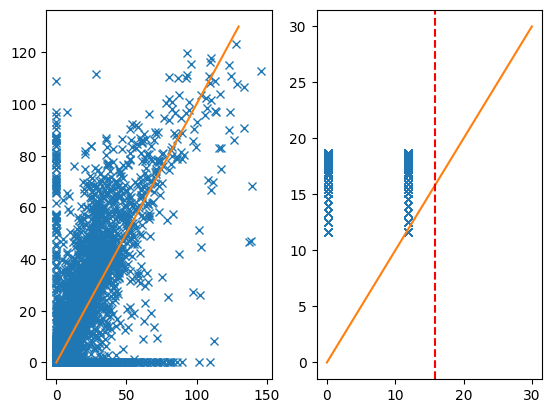

5765.807484784723
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.718  0.418E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     2  -1.292  0.464E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     3  -1.678  0.488E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     4  -1.951  0.292E+00    32060   154.03  0.602   [Radiance 0.660 micron]
     5  -2.348  0.157E+00    32678   155.81  0.609   [Radiance 0.660 micron]
     6  -2.295  0.804E-01    35900   163.86  0.640   [Radiance 0.660 micron]
     7  -2.365  0.603E-01    38899   170.26  0.665   [Radiance 0.660 micron]
     8  -2.486  0.490E-01    42086   176.06  0.688   [Radiance 0.660 micron]
     9  -2.552  0.396E-01    46585   182.93  0.715   [Radiance 0.660 micron]
    10  -2.641  0.336E-01    51482   189.16  0.739   [Radiance 0.660 micron]
    11  -2.739  0.300E-01    55571   193.51  0.756   [Radiance 0.660 micron]
    12  -3.070  0.300E-01    55730   193.63  0.756   [Radianc

<Figure size 640x480 with 0 Axes>

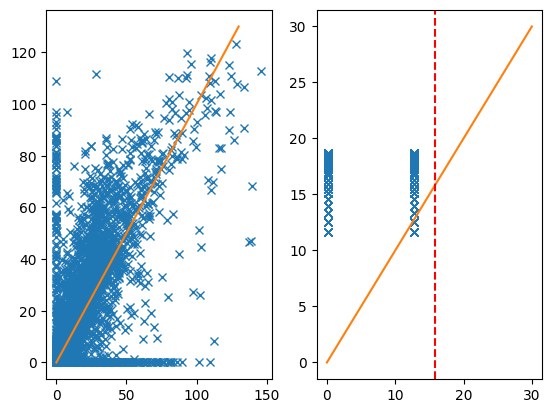

6175.020199477193
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.717  0.417E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     2  -1.292  0.463E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     3  -1.678  0.486E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     4  -1.953  0.290E+00    32060   154.03  0.602   [Radiance 0.660 micron]
     5  -2.350  0.157E+00    32668   155.78  0.609   [Radiance 0.660 micron]
     6  -2.297  0.800E-01    35853   163.75  0.640   [Radiance 0.660 micron]
     7  -2.365  0.600E-01    38859   170.17  0.665   [Radiance 0.660 micron]
     8  -2.490  0.489E-01    41980   175.89  0.687   [Radiance 0.660 micron]
     9  -2.552  0.394E-01    46471   182.75  0.714   [Radiance 0.660 micron]
    10  -2.649  0.335E-01    51264   188.91  0.738   [Radiance 0.660 micron]
    11  -2.736  0.300E-01    55324   193.26  0.755   [Radiance 0.660 micron]
    12  -3.072  0.300E-01    55477   193.37  0.755   [Radianc

<Figure size 640x480 with 0 Axes>

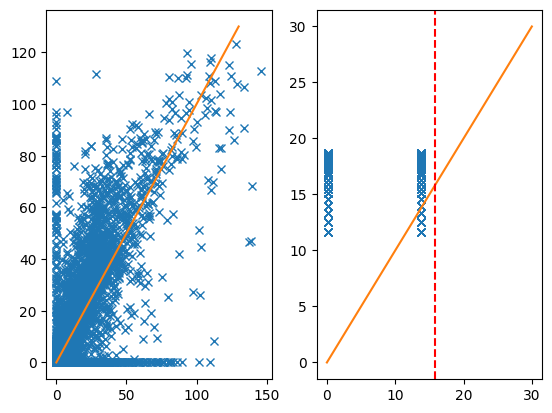

6653.757705012104
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.717  0.416E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     2  -1.292  0.461E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     3  -1.679  0.485E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     4  -1.955  0.289E+00    32060   154.03  0.602   [Radiance 0.660 micron]
     5  -2.353  0.156E+00    32661   155.77  0.608   [Radiance 0.660 micron]
     6  -2.297  0.797E-01    35825   163.68  0.639   [Radiance 0.660 micron]
     7  -2.367  0.599E-01    38810   170.08  0.664   [Radiance 0.660 micron]
     8  -2.490  0.487E-01    41940   175.80  0.687   [Radiance 0.660 micron]
     9  -2.559  0.394E-01    46369   182.62  0.713   [Radiance 0.660 micron]
    10  -2.644  0.333E-01    51239   188.86  0.738   [Radiance 0.660 micron]
    11  -2.749  0.300E-01    55014   192.96  0.754   [Radiance 0.660 micron]
    12  -3.074  0.300E-01    55166   193.09  0.754   [Radianc

<Figure size 640x480 with 0 Axes>

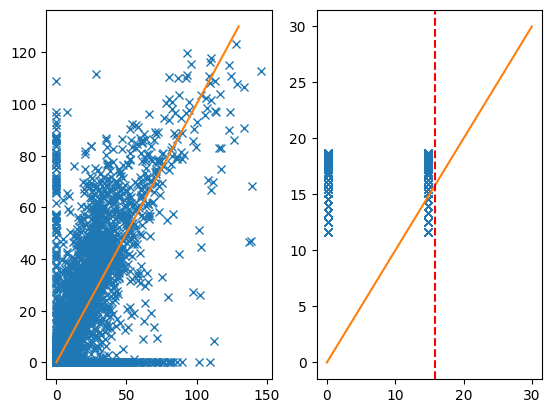

7162.38478696317
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.717  0.415E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     2  -1.291  0.460E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     3  -1.680  0.483E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     4  -1.956  0.287E+00    32060   154.03  0.602   [Radiance 0.660 micron]
     5  -2.355  0.156E+00    32649   155.74  0.608   [Radiance 0.660 micron]
     6  -2.302  0.795E-01    35788   163.59  0.639   [Radiance 0.660 micron]
     7  -2.363  0.595E-01    38803   170.06  0.664   [Radiance 0.660 micron]
     8  -2.492  0.488E-01    41827   175.61  0.686   [Radiance 0.660 micron]
     9  -2.560  0.393E-01    46275   182.50  0.713   [Radiance 0.660 micron]
    10  -2.645  0.332E-01    51091   188.66  0.737   [Radiance 0.660 micron]
    11  -2.750  0.300E-01    54825   192.76  0.753   [Radiance 0.660 micron]
    12  -3.074  0.300E-01    54990   192.91  0.754   [Radiance

<Figure size 640x480 with 0 Axes>

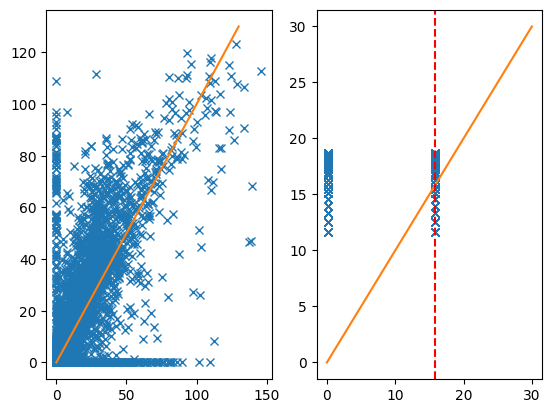

7691.946138883783
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.716  0.414E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     2  -1.291  0.459E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     3  -1.680  0.482E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     4  -1.957  0.286E+00    32060   154.03  0.602   [Radiance 0.660 micron]
     5  -2.357  0.155E+00    32648   155.74  0.608   [Radiance 0.660 micron]
     6  -2.303  0.792E-01    35768   163.53  0.639   [Radiance 0.660 micron]
     7  -2.364  0.594E-01    38775   170.00  0.664   [Radiance 0.660 micron]
     8  -2.493  0.487E-01    41748   175.48  0.685   [Radiance 0.660 micron]
     9  -2.562  0.392E-01    46127   182.29  0.712   [Radiance 0.660 micron]
    10  -2.643  0.331E-01    51019   188.59  0.737   [Radiance 0.660 micron]
    11  -2.756  0.300E-01    54627   192.54  0.752   [Radiance 0.660 micron]
    12  -3.071  0.300E-01    54782   192.68  0.753   [Radianc

<Figure size 640x480 with 0 Axes>

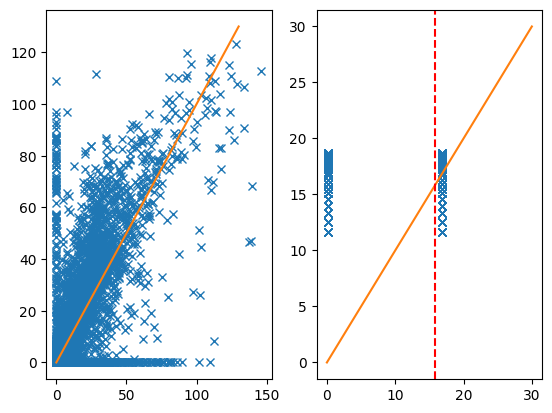

8237.222486269615
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.716  0.413E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     2  -1.291  0.459E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     3  -1.681  0.481E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     4  -1.958  0.285E+00    32060   154.03  0.602   [Radiance 0.660 micron]
     5  -2.358  0.155E+00    32641   155.73  0.608   [Radiance 0.660 micron]
     6  -2.305  0.790E-01    35753   163.50  0.639   [Radiance 0.660 micron]
     7  -2.363  0.592E-01    38758   169.99  0.664   [Radiance 0.660 micron]
     8  -2.494  0.486E-01    41698   175.38  0.685   [Radiance 0.660 micron]
     9  -2.562  0.392E-01    46065   182.21  0.712   [Radiance 0.660 micron]
    10  -2.650  0.331E-01    50845   188.41  0.736   [Radiance 0.660 micron]
    11  -2.753  0.300E-01    54409   192.34  0.751   [Radiance 0.660 micron]
    12  -3.071  0.300E-01    54561   192.48  0.752   [Radianc

<Figure size 640x480 with 0 Axes>

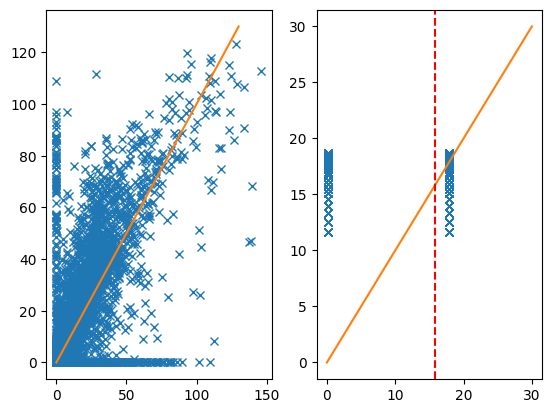

8761.501903398013
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.715  0.412E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     2  -1.291  0.458E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     3  -1.681  0.480E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     4  -1.959  0.284E+00    32060   154.03  0.602   [Radiance 0.660 micron]
     5  -2.360  0.155E+00    32631   155.70  0.608   [Radiance 0.660 micron]
     6  -2.305  0.788E-01    35730   163.44  0.638   [Radiance 0.660 micron]
     7  -2.362  0.591E-01    38716   169.90  0.664   [Radiance 0.660 micron]
     8  -2.496  0.486E-01    41669   175.32  0.685   [Radiance 0.660 micron]
     9  -2.561  0.391E-01    46030   182.17  0.712   [Radiance 0.660 micron]
    10  -2.654  0.331E-01    50695   188.26  0.735   [Radiance 0.660 micron]
    11  -2.753  0.300E-01    54209   192.13  0.750   [Radiance 0.660 micron]
    12  -3.074  0.300E-01    54375   192.30  0.751   [Radianc

<Figure size 640x480 with 0 Axes>

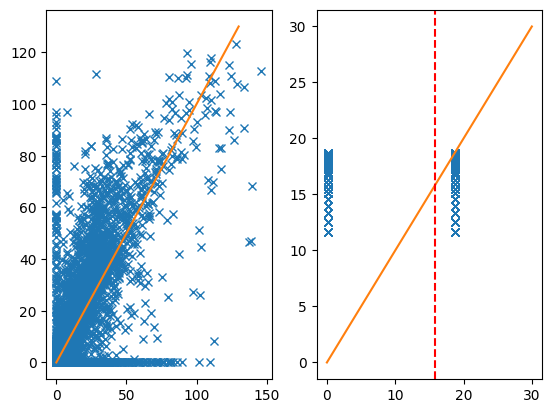

9275.785082875931
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.715  0.412E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     2  -1.290  0.457E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     3  -1.682  0.480E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     4  -1.959  0.283E+00    32060   154.03  0.602   [Radiance 0.660 micron]
     5  -2.362  0.154E+00    32626   155.68  0.608   [Radiance 0.660 micron]
     6  -2.305  0.786E-01    35719   163.42  0.638   [Radiance 0.660 micron]
     7  -2.363  0.590E-01    38663   169.80  0.663   [Radiance 0.660 micron]
     8  -2.497  0.485E-01    41610   175.22  0.684   [Radiance 0.660 micron]
     9  -2.562  0.391E-01    45950   182.07  0.711   [Radiance 0.660 micron]
    10  -2.649  0.331E-01    50593   188.12  0.735   [Radiance 0.660 micron]
    11  -2.756  0.300E-01    54034   191.97  0.750   [Radiance 0.660 micron]
    12  -3.075  0.300E-01    54179   192.11  0.750   [Radianc

<Figure size 640x480 with 0 Axes>

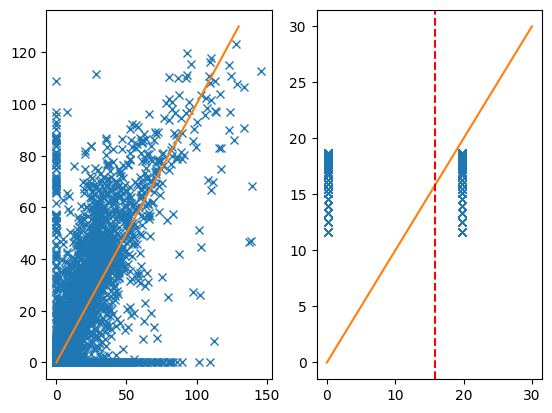

9770.7419636524


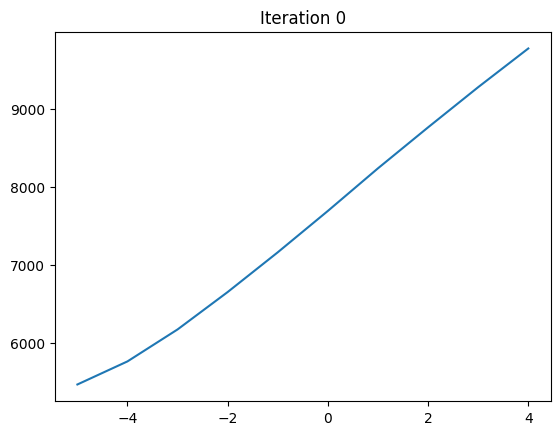

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.714  0.409E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     2  -1.290  0.454E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     3  -1.683  0.477E+00    31968   153.74  0.601   [Radiance 0.660 micron]
     4  -1.963  0.289E+00    32052   154.00  0.602   [Radiance 0.660 micron]
     5  -2.369  0.153E+00    32620   155.66  0.608   [Radiance 0.660 micron]
     6  -2.306  0.779E-01    35663   163.29  0.638   [Radiance 0.660 micron]
     7  -2.363  0.586E-01    38548   169.59  0.662   [Radiance 0.660 micron]
     8  -2.501  0.484E-01    41427   174.91  0.683   [Radiance 0.660 micron]
     9  -2.556  0.388E-01    45748   181.79  0.710   [Radiance 0.660 micron]
    10  -2.664  0.331E-01    50003   187.48  0.732   [Radiance 0.660 micron]
    11  -2.766  0.300E-01    53395   191.33  0.747   [Radiance 0.660 micron]
    12  -3.079  0.300E-01    53549   191.46  0.748   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

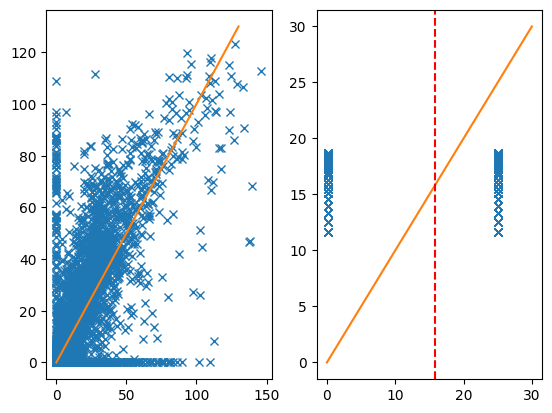


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28351      1      2   2189     0 11801   2.628D+00   9.937D+03
  F =   9937.2904496975916     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.751  0.425E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     2  -1.329  0.471E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     3  -1.710  0.495E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     4  -1.980  0.282E+00    32087   137.29  0.536   [Radiance 0.660 micron]
     5  -2.362  0.150E+00    32774   139.

<Figure size 640x480 with 0 Axes>

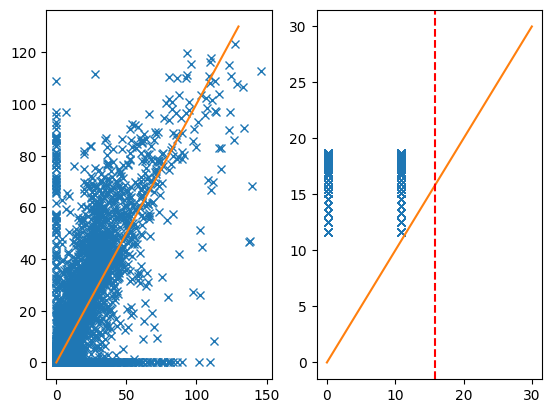

5446.504071421239
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.750  0.423E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     2  -1.328  0.469E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     3  -1.711  0.493E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     4  -1.982  0.281E+00    32083   137.28  0.536   [Radiance 0.660 micron]
     5  -2.365  0.150E+00    32766   139.55  0.545   [Radiance 0.660 micron]
     6  -2.323  0.773E-01    36350   149.68  0.585   [Radiance 0.660 micron]
     7  -2.404  0.577E-01    39569   157.38  0.615   [Radiance 0.660 micron]
     8  -2.502  0.463E-01    43400   164.96  0.644   [Radiance 0.660 micron]
     9  -2.584  0.380E-01    48000   172.75  0.675   [Radiance 0.660 micron]
    10  -2.666  0.320E-01    53530   180.32  0.704   [Radiance 0.660 micron]
    11  -2.828  0.300E-01    56075   183.21  0.716   [Radiance 0.660 micron]
    12  -3.122  0.300E-01    56184   183.32  0.716   [Radianc

<Figure size 640x480 with 0 Axes>

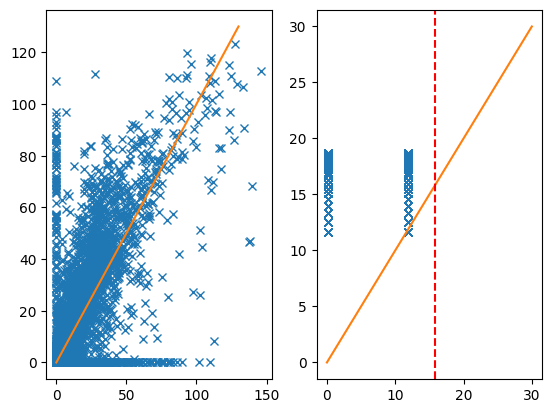

5429.599015201971
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.749  0.421E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     2  -1.327  0.467E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     3  -1.712  0.491E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     4  -1.984  0.280E+00    32083   137.28  0.536   [Radiance 0.660 micron]
     5  -2.368  0.149E+00    32758   139.53  0.545   [Radiance 0.660 micron]
     6  -2.325  0.769E-01    36303   149.56  0.584   [Radiance 0.660 micron]
     7  -2.404  0.574E-01    39524   157.29  0.614   [Radiance 0.660 micron]
     8  -2.503  0.462E-01    43276   164.75  0.644   [Radiance 0.660 micron]
     9  -2.587  0.379E-01    47819   172.49  0.674   [Radiance 0.660 micron]
    10  -2.661  0.318E-01    53320   180.06  0.703   [Radiance 0.660 micron]
    11  -2.846  0.300E-01    55620   182.68  0.714   [Radiance 0.660 micron]
    12  -3.124  0.300E-01    55749   182.79  0.714   [Radianc

<Figure size 640x480 with 0 Axes>

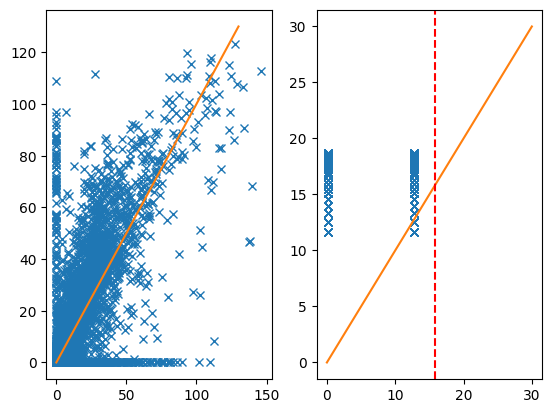

5575.243390078027
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.748  0.420E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     2  -1.327  0.466E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     3  -1.712  0.489E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     4  -1.985  0.280E+00    32082   137.27  0.536   [Radiance 0.660 micron]
     5  -2.371  0.148E+00    32758   139.53  0.545   [Radiance 0.660 micron]
     6  -2.326  0.767E-01    36286   149.50  0.584   [Radiance 0.660 micron]
     7  -2.407  0.572E-01    39468   157.18  0.614   [Radiance 0.660 micron]
     8  -2.501  0.460E-01    43197   164.64  0.643   [Radiance 0.660 micron]
     9  -2.590  0.379E-01    47615   172.19  0.673   [Radiance 0.660 micron]
    10  -2.665  0.317E-01    53068   179.79  0.702   [Radiance 0.660 micron]
    11  -2.855  0.300E-01    55257   182.35  0.712   [Radiance 0.660 micron]
    12  -3.123  0.300E-01    55361   182.45  0.713   [Radianc

<Figure size 640x480 with 0 Axes>

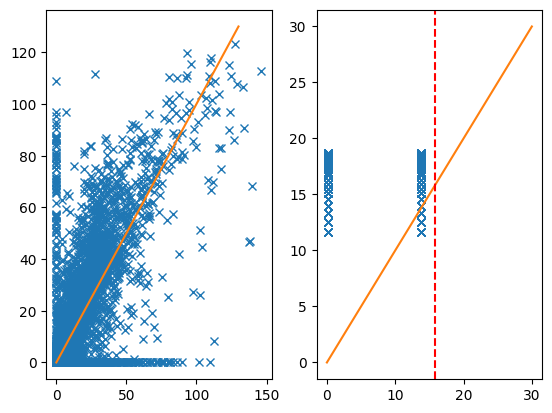

5823.442410950851
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.747  0.419E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     2  -1.326  0.465E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     3  -1.713  0.488E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     4  -1.986  0.280E+00    32080   137.27  0.536   [Radiance 0.660 micron]
     5  -2.374  0.148E+00    32747   139.49  0.545   [Radiance 0.660 micron]
     6  -2.329  0.763E-01    36256   149.44  0.584   [Radiance 0.660 micron]
     7  -2.406  0.570E-01    39421   157.08  0.614   [Radiance 0.660 micron]
     8  -2.503  0.460E-01    43037   164.34  0.642   [Radiance 0.660 micron]
     9  -2.589  0.378E-01    47559   172.10  0.672   [Radiance 0.660 micron]
    10  -2.666  0.317E-01    52829   179.45  0.701   [Radiance 0.660 micron]
    11  -2.863  0.300E-01    54999   182.06  0.711   [Radiance 0.660 micron]
    12  -3.132  0.300E-01    55096   182.15  0.712   [Radianc

<Figure size 640x480 with 0 Axes>

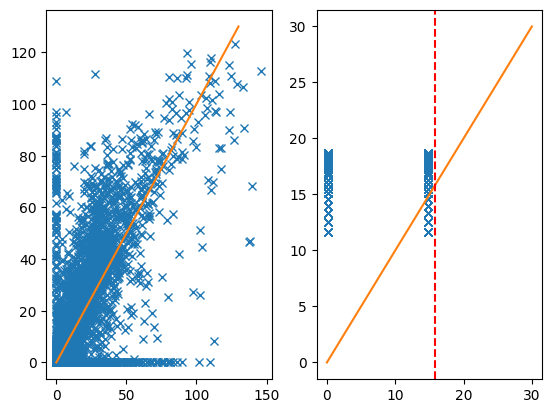

6138.502993113314
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.746  0.418E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     2  -1.325  0.464E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     3  -1.713  0.487E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     4  -1.988  0.279E+00    32077   137.25  0.536   [Radiance 0.660 micron]
     5  -2.376  0.148E+00    32731   139.44  0.545   [Radiance 0.660 micron]
     6  -2.330  0.761E-01    36220   149.34  0.583   [Radiance 0.660 micron]
     7  -2.404  0.568E-01    39397   157.03  0.613   [Radiance 0.660 micron]
     8  -2.505  0.459E-01    42926   164.14  0.641   [Radiance 0.660 micron]
     9  -2.593  0.377E-01    47440   171.91  0.672   [Radiance 0.660 micron]
    10  -2.656  0.316E-01    52783   179.41  0.701   [Radiance 0.660 micron]
    11  -2.866  0.300E-01    54817   181.86  0.710   [Radiance 0.660 micron]
    12  -3.135  0.300E-01    54921   181.96  0.711   [Radianc

<Figure size 640x480 with 0 Axes>

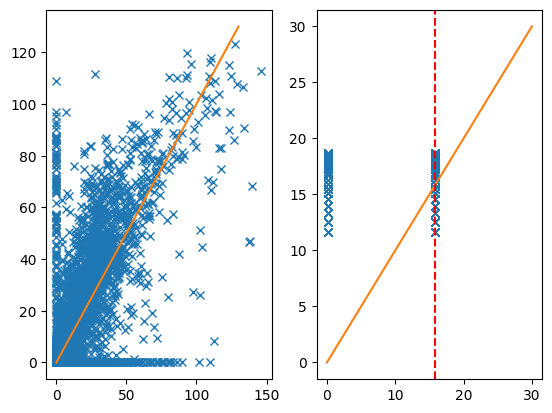

6498.715559201973
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.746  0.417E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     2  -1.325  0.463E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     3  -1.713  0.486E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     4  -1.989  0.279E+00    32075   137.25  0.536   [Radiance 0.660 micron]
     5  -2.378  0.148E+00    32728   139.43  0.545   [Radiance 0.660 micron]
     6  -2.330  0.758E-01    36202   149.28  0.583   [Radiance 0.660 micron]
     7  -2.404  0.567E-01    39366   156.96  0.613   [Radiance 0.660 micron]
     8  -2.508  0.459E-01    42832   163.95  0.640   [Radiance 0.660 micron]
     9  -2.595  0.376E-01    47345   171.77  0.671   [Radiance 0.660 micron]
    10  -2.652  0.315E-01    52706   179.34  0.701   [Radiance 0.660 micron]
    11  -2.864  0.300E-01    54618   181.63  0.709   [Radiance 0.660 micron]
    12  -3.139  0.300E-01    54712   181.72  0.710   [Radianc

<Figure size 640x480 with 0 Axes>

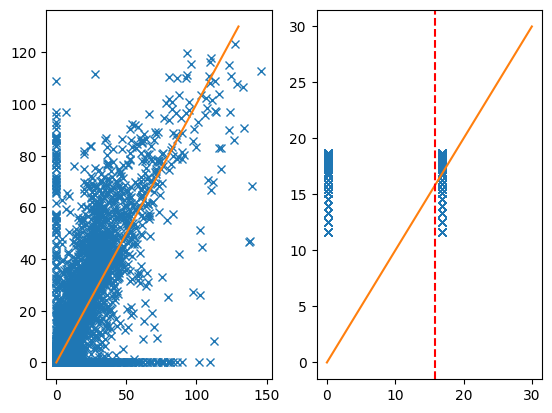

6888.22977974387
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.745  0.416E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     2  -1.324  0.462E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     3  -1.714  0.485E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     4  -1.989  0.279E+00    32073   137.24  0.536   [Radiance 0.660 micron]
     5  -2.379  0.147E+00    32728   139.43  0.545   [Radiance 0.660 micron]
     6  -2.331  0.757E-01    36174   149.20  0.583   [Radiance 0.660 micron]
     7  -2.405  0.566E-01    39331   156.90  0.613   [Radiance 0.660 micron]
     8  -2.509  0.458E-01    42755   163.80  0.640   [Radiance 0.660 micron]
     9  -2.595  0.375E-01    47274   171.67  0.671   [Radiance 0.660 micron]
    10  -2.655  0.314E-01    52585   179.19  0.700   [Radiance 0.660 micron]
    11  -2.866  0.300E-01    54396   181.38  0.709   [Radiance 0.660 micron]
    12  -3.142  0.300E-01    54487   181.47  0.709   [Radiance

<Figure size 640x480 with 0 Axes>

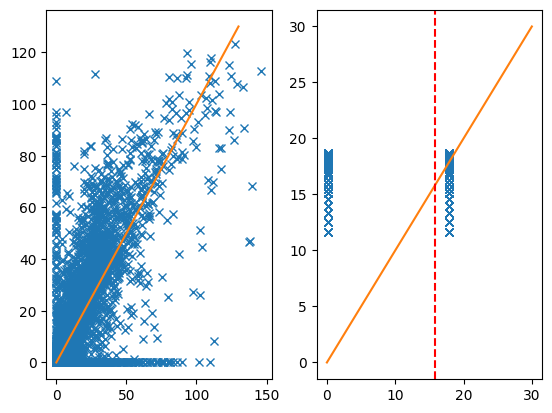

7284.4291268539655
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.745  0.415E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     2  -1.324  0.461E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     3  -1.714  0.484E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     4  -1.990  0.278E+00    32069   137.23  0.536   [Radiance 0.660 micron]
     5  -2.382  0.147E+00    32726   139.42  0.545   [Radiance 0.660 micron]
     6  -2.331  0.754E-01    36161   149.18  0.583   [Radiance 0.660 micron]
     7  -2.405  0.565E-01    39319   156.87  0.613   [Radiance 0.660 micron]
     8  -2.510  0.457E-01    42707   163.71  0.639   [Radiance 0.660 micron]
     9  -2.595  0.375E-01    47185   171.51  0.670   [Radiance 0.660 micron]
    10  -2.654  0.314E-01    52436   179.00  0.699   [Radiance 0.660 micron]
    11  -2.867  0.300E-01    54198   181.13  0.708   [Radiance 0.660 micron]
    12  -3.134  0.300E-01    54297   181.23  0.708   [Radian

<Figure size 640x480 with 0 Axes>

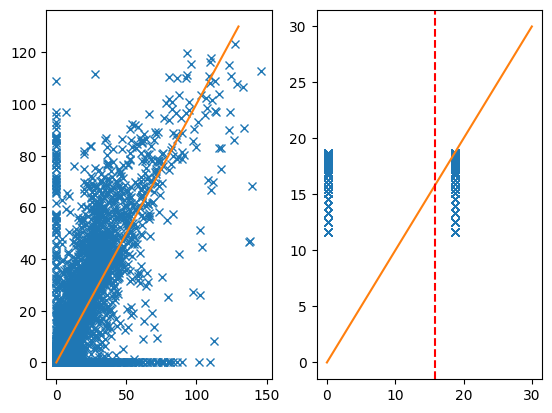

7676.757534846348
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.744  0.415E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     2  -1.324  0.460E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     3  -1.714  0.483E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     4  -1.991  0.277E+00    32069   137.23  0.536   [Radiance 0.660 micron]
     5  -2.383  0.147E+00    32724   139.42  0.545   [Radiance 0.660 micron]
     6  -2.332  0.753E-01    36129   149.12  0.583   [Radiance 0.660 micron]
     7  -2.405  0.564E-01    39276   156.75  0.612   [Radiance 0.660 micron]
     8  -2.512  0.457E-01    42654   163.59  0.639   [Radiance 0.660 micron]
     9  -2.596  0.374E-01    47111   171.41  0.670   [Radiance 0.660 micron]
    10  -2.654  0.314E-01    52339   178.86  0.699   [Radiance 0.660 micron]
    11  -2.871  0.300E-01    54047   180.95  0.707   [Radiance 0.660 micron]
    12  -3.138  0.300E-01    54141   181.05  0.707   [Radianc

<Figure size 640x480 with 0 Axes>

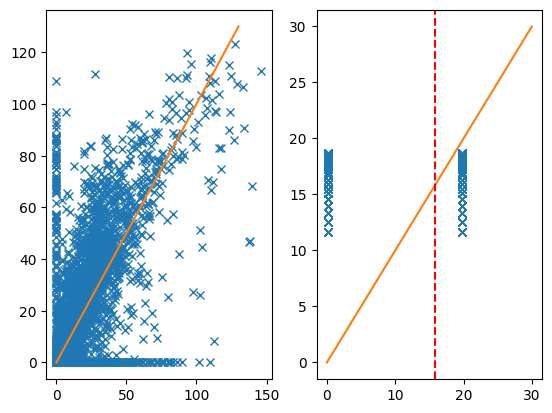

8072.7402596304455


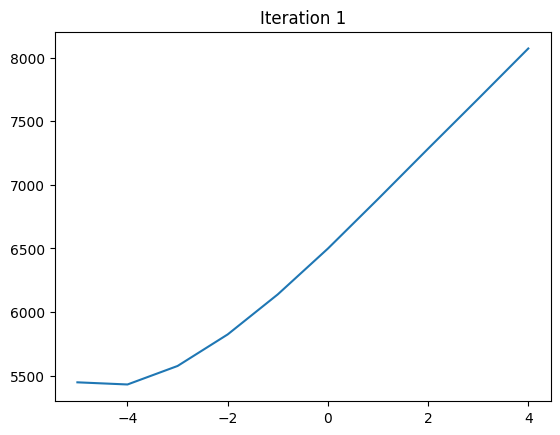

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.742  0.412E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     2  -1.322  0.457E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     3  -1.715  0.480E+00    31968   136.87  0.535   [Radiance 0.660 micron]
     4  -1.994  0.277E+00    32065   137.21  0.536   [Radiance 0.660 micron]
     5  -2.389  0.146E+00    32703   139.35  0.544   [Radiance 0.660 micron]
     6  -2.335  0.747E-01    36066   148.99  0.582   [Radiance 0.660 micron]
     7  -2.402  0.560E-01    39178   156.53  0.611   [Radiance 0.660 micron]
     8  -2.518  0.456E-01    42402   163.17  0.637   [Radiance 0.660 micron]
     9  -2.598  0.372E-01    46810   170.98  0.668   [Radiance 0.660 micron]
    10  -2.656  0.312E-01    51942   178.33  0.697   [Radiance 0.660 micron]
    11  -2.886  0.300E-01    53433   180.25  0.704   [Radiance 0.660 micron]
    12  -3.142  0.300E-01    53534   180.33  0.704   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

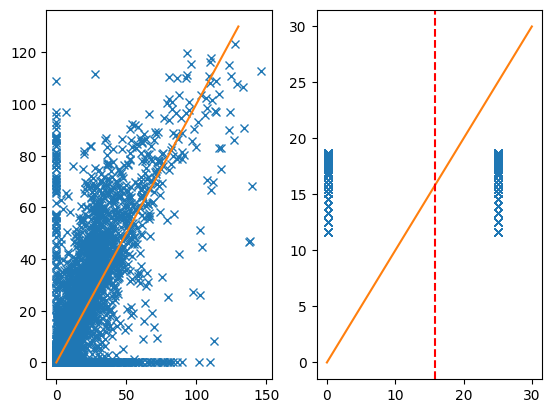


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28351      1      2   1018     0 11468   2.440D+00   9.088D+03
  F =   9087.8510535183723     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.760  0.427E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     2  -1.338  0.474E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     3  -1.717  0.498E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     4  -1.987  0.279E+00    32099   139.90  0.546   [Radiance 0.660 micron]
     5  -2.365  0.149E+00    32803   142.

<Figure size 640x480 with 0 Axes>

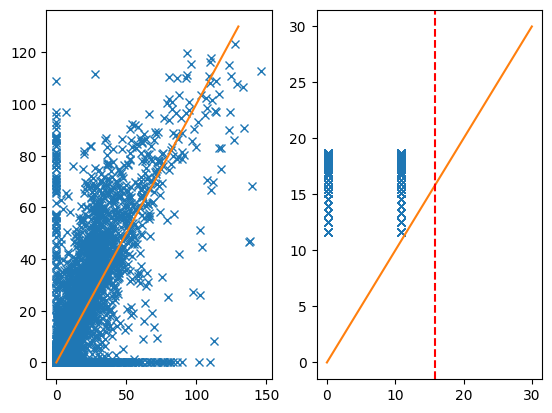

5559.543005317603
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.759  0.426E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     2  -1.337  0.472E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     3  -1.718  0.496E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     4  -1.988  0.277E+00    32099   139.90  0.546   [Radiance 0.660 micron]
     5  -2.368  0.149E+00    32789   142.15  0.555   [Radiance 0.660 micron]
     6  -2.332  0.768E-01    36403   152.23  0.595   [Radiance 0.660 micron]
     7  -2.408  0.571E-01    39724   160.06  0.625   [Radiance 0.660 micron]
     8  -2.511  0.459E-01    43589   167.58  0.655   [Radiance 0.660 micron]
     9  -2.595  0.375E-01    48419   175.52  0.686   [Radiance 0.660 micron]
    10  -2.663  0.314E-01    54205   183.06  0.715   [Radiance 0.660 micron]
    11  -2.874  0.300E-01    56034   185.10  0.723   [Radiance 0.660 micron]
    12  -3.122  0.300E-01    56125   185.19  0.723   [Radianc

<Figure size 640x480 with 0 Axes>

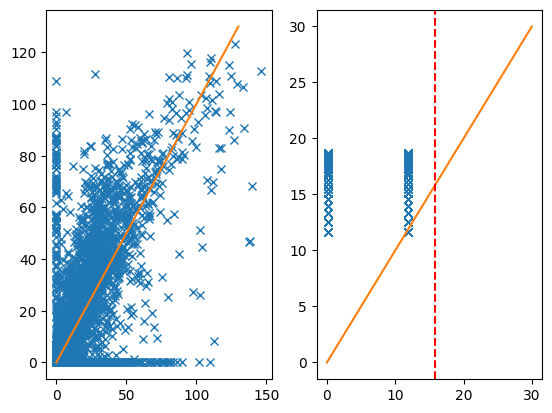

5398.272097858038
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.758  0.424E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     2  -1.336  0.470E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     3  -1.719  0.494E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     4  -1.990  0.278E+00    32092   139.87  0.546   [Radiance 0.660 micron]
     5  -2.371  0.147E+00    32785   142.14  0.555   [Radiance 0.660 micron]
     6  -2.334  0.765E-01    36372   152.17  0.594   [Radiance 0.660 micron]
     7  -2.410  0.568E-01    39651   159.91  0.625   [Radiance 0.660 micron]
     8  -2.513  0.457E-01    43472   167.39  0.654   [Radiance 0.660 micron]
     9  -2.597  0.374E-01    48194   175.17  0.684   [Radiance 0.660 micron]
    10  -2.661  0.313E-01    53980   182.87  0.714   [Radiance 0.660 micron]
    11  -2.871  0.300E-01    55680   184.68  0.721   [Radiance 0.660 micron]
    12  -3.131  0.300E-01    55760   184.74  0.722   [Radianc

<Figure size 640x480 with 0 Axes>

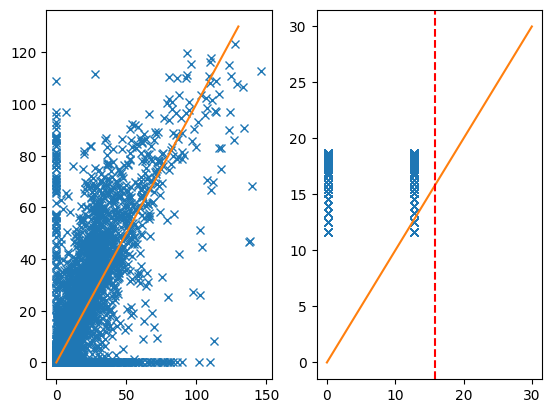

5422.5821338931555
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.757  0.423E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     2  -1.335  0.469E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     3  -1.719  0.492E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     4  -1.991  0.278E+00    32091   139.88  0.546   [Radiance 0.660 micron]
     5  -2.374  0.148E+00    32776   142.11  0.555   [Radiance 0.660 micron]
     6  -2.337  0.762E-01    36339   152.11  0.594   [Radiance 0.660 micron]
     7  -2.410  0.565E-01    39609   159.82  0.624   [Radiance 0.660 micron]
     8  -2.511  0.456E-01    43361   167.19  0.653   [Radiance 0.660 micron]
     9  -2.600  0.374E-01    47992   174.85  0.683   [Radiance 0.660 micron]
    10  -2.657  0.312E-01    53731   182.58  0.713   [Radiance 0.660 micron]
    11  -2.878  0.300E-01    55355   184.37  0.720   [Radiance 0.660 micron]
    12  -3.126  0.300E-01    55437   184.44  0.720   [Radian

<Figure size 640x480 with 0 Axes>

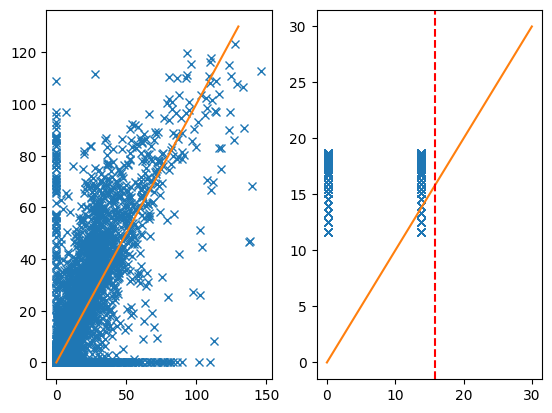

5572.514513118304
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.756  0.421E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     2  -1.334  0.467E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     3  -1.720  0.491E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     4  -1.993  0.278E+00    32090   139.87  0.546   [Radiance 0.660 micron]
     5  -2.376  0.147E+00    32762   142.07  0.555   [Radiance 0.660 micron]
     6  -2.338  0.758E-01    36315   152.04  0.594   [Radiance 0.660 micron]
     7  -2.409  0.563E-01    39566   159.77  0.624   [Radiance 0.660 micron]
     8  -2.515  0.455E-01    43269   167.05  0.653   [Radiance 0.660 micron]
     9  -2.600  0.372E-01    47883   174.70  0.682   [Radiance 0.660 micron]
    10  -2.658  0.312E-01    53506   182.31  0.712   [Radiance 0.660 micron]
    11  -2.883  0.300E-01    55064   184.05  0.719   [Radiance 0.660 micron]
    12  -3.133  0.300E-01    55157   184.14  0.719   [Radianc

<Figure size 640x480 with 0 Axes>

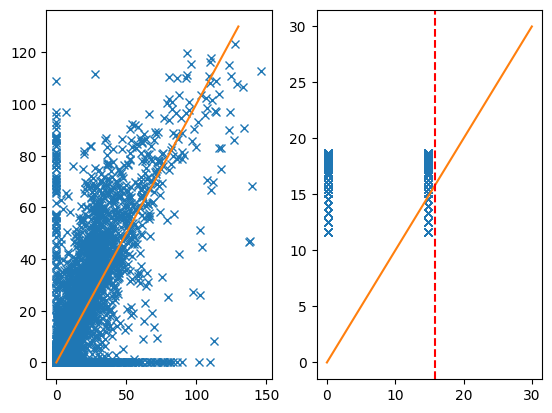

5791.863101502849
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.755  0.420E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     2  -1.334  0.466E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     3  -1.720  0.490E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     4  -1.993  0.276E+00    32090   139.87  0.546   [Radiance 0.660 micron]
     5  -2.377  0.147E+00    32755   142.05  0.555   [Radiance 0.660 micron]
     6  -2.341  0.757E-01    36259   151.90  0.593   [Radiance 0.660 micron]
     7  -2.409  0.561E-01    39539   159.73  0.624   [Radiance 0.660 micron]
     8  -2.516  0.455E-01    43180   166.88  0.652   [Radiance 0.660 micron]
     9  -2.600  0.372E-01    47737   174.51  0.682   [Radiance 0.660 micron]
    10  -2.659  0.311E-01    53279   182.06  0.711   [Radiance 0.660 micron]
    11  -2.886  0.300E-01    54872   183.84  0.718   [Radiance 0.660 micron]
    12  -3.133  0.300E-01    54964   183.93  0.718   [Radianc

<Figure size 640x480 with 0 Axes>

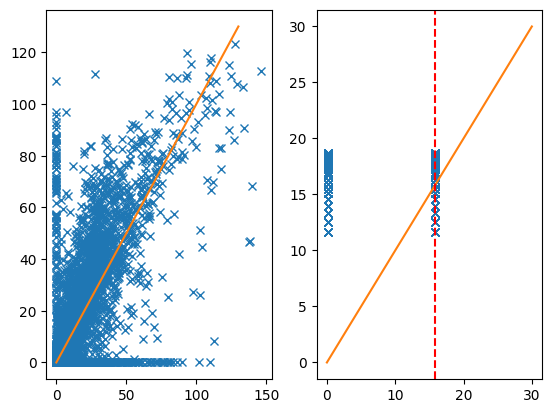

6073.055872075675
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.755  0.419E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     2  -1.333  0.465E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     3  -1.720  0.488E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     4  -1.994  0.277E+00    32079   139.83  0.546   [Radiance 0.660 micron]
     5  -2.382  0.147E+00    32752   142.04  0.555   [Radiance 0.660 micron]
     6  -2.340  0.753E-01    36270   151.95  0.594   [Radiance 0.660 micron]
     7  -2.409  0.560E-01    39494   159.63  0.624   [Radiance 0.660 micron]
     8  -2.517  0.454E-01    43078   166.70  0.651   [Radiance 0.660 micron]
     9  -2.598  0.371E-01    47671   174.42  0.681   [Radiance 0.660 micron]
    10  -2.664  0.312E-01    53048   181.76  0.710   [Radiance 0.660 micron]
    11  -2.884  0.300E-01    54651   183.59  0.717   [Radiance 0.660 micron]
    12  -3.137  0.300E-01    54737   183.67  0.717   [Radianc

<Figure size 640x480 with 0 Axes>

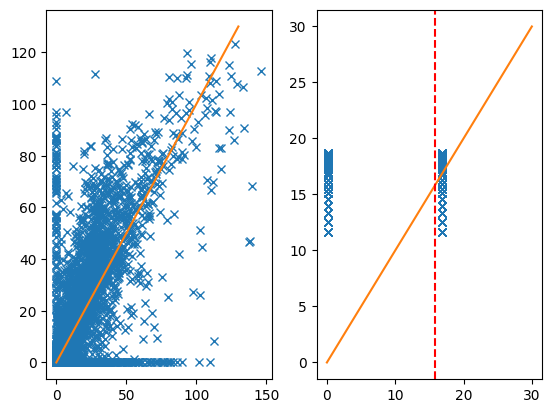

6387.394357362228
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.754  0.419E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     2  -1.333  0.464E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     3  -1.720  0.487E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     4  -1.995  0.276E+00    32079   139.83  0.546   [Radiance 0.660 micron]
     5  -2.384  0.146E+00    32747   142.02  0.555   [Radiance 0.660 micron]
     6  -2.342  0.751E-01    36232   151.84  0.593   [Radiance 0.660 micron]
     7  -2.410  0.559E-01    39472   159.58  0.623   [Radiance 0.660 micron]
     8  -2.517  0.453E-01    42990   166.55  0.651   [Radiance 0.660 micron]
     9  -2.602  0.371E-01    47565   174.28  0.681   [Radiance 0.660 micron]
    10  -2.662  0.310E-01    53006   181.73  0.710   [Radiance 0.660 micron]
    11  -2.892  0.300E-01    54446   183.39  0.716   [Radiance 0.660 micron]
    12  -3.144  0.300E-01    54535   183.47  0.717   [Radianc

<Figure size 640x480 with 0 Axes>

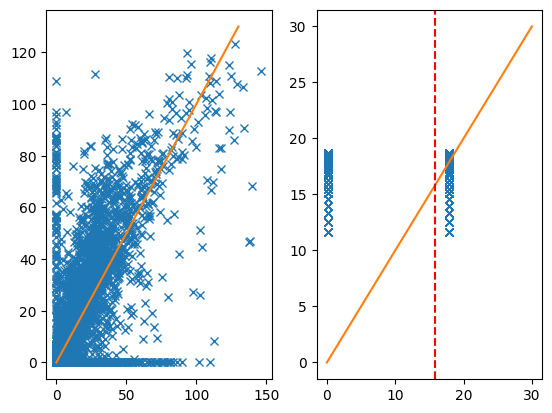

6718.682811227107
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.753  0.418E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     2  -1.332  0.464E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     3  -1.721  0.487E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     4  -1.996  0.276E+00    32077   139.83  0.546   [Radiance 0.660 micron]
     5  -2.386  0.146E+00    32743   142.01  0.555   [Radiance 0.660 micron]
     6  -2.342  0.749E-01    36229   151.83  0.593   [Radiance 0.660 micron]
     7  -2.410  0.558E-01    39442   159.52  0.623   [Radiance 0.660 micron]
     8  -2.519  0.453E-01    42945   166.47  0.650   [Radiance 0.660 micron]
     9  -2.603  0.370E-01    47534   174.25  0.681   [Radiance 0.660 micron]
    10  -2.667  0.310E-01    52854   181.57  0.709   [Radiance 0.660 micron]
    11  -2.898  0.300E-01    54236   183.13  0.715   [Radiance 0.660 micron]
    12  -3.150  0.300E-01    54319   183.21  0.716   [Radianc

<Figure size 640x480 with 0 Axes>

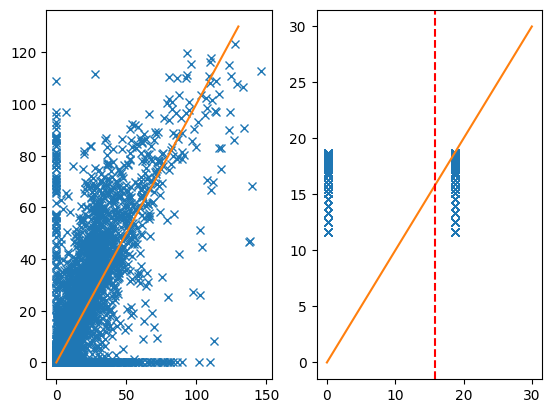

7065.81028524823
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.753  0.417E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     2  -1.332  0.463E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     3  -1.721  0.486E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     4  -1.996  0.276E+00    32077   139.83  0.546   [Radiance 0.660 micron]
     5  -2.387  0.146E+00    32728   141.96  0.555   [Radiance 0.660 micron]
     6  -2.343  0.748E-01    36195   151.74  0.593   [Radiance 0.660 micron]
     7  -2.409  0.557E-01    39419   159.46  0.623   [Radiance 0.660 micron]
     8  -2.520  0.453E-01    42824   166.23  0.649   [Radiance 0.660 micron]
     9  -2.603  0.369E-01    47461   174.13  0.680   [Radiance 0.660 micron]
    10  -2.667  0.310E-01    52752   181.45  0.709   [Radiance 0.660 micron]
    11  -2.901  0.300E-01    54092   182.98  0.715   [Radiance 0.660 micron]
    12  -3.153  0.300E-01    54179   183.07  0.715   [Radiance

<Figure size 640x480 with 0 Axes>

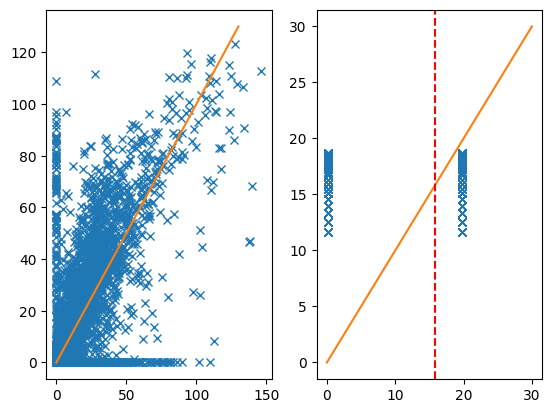

7405.683256229702


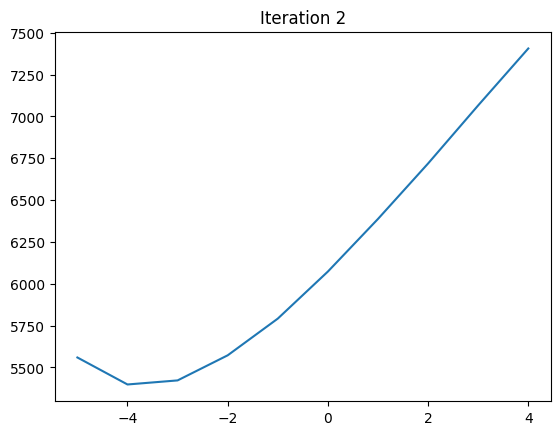

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.751  0.414E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     2  -1.330  0.460E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     3  -1.722  0.482E+00    31968   139.44  0.545   [Radiance 0.660 micron]
     4  -1.999  0.275E+00    32069   139.80  0.546   [Radiance 0.660 micron]
     5  -2.393  0.145E+00    32718   141.93  0.554   [Radiance 0.660 micron]
     6  -2.343  0.742E-01    36125   151.59  0.592   [Radiance 0.660 micron]
     7  -2.406  0.554E-01    39339   159.26  0.622   [Radiance 0.660 micron]
     8  -2.529  0.453E-01    42533   165.70  0.647   [Radiance 0.660 micron]
     9  -2.603  0.367E-01    47216   173.80  0.679   [Radiance 0.660 micron]
    10  -2.670  0.309E-01    52342   180.92  0.707   [Radiance 0.660 micron]
    11  -2.907  0.300E-01    53480   182.32  0.712   [Radiance 0.660 micron]
    12  -3.157  0.300E-01    53554   182.38  0.712   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

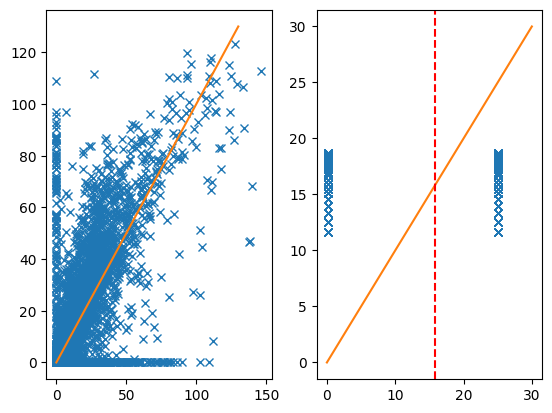


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28351      1      2   1506     0 12692   2.216D+00   8.518D+03
  F =   8518.1019033398425     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.757  0.428E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     2  -1.331  0.474E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     3  -1.711  0.498E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     4  -1.980  0.283E+00    32085   130.43  0.509   [Radiance 0.660 micron]
     5  -2.362  0.151E+00    32782   132.

<Figure size 640x480 with 0 Axes>

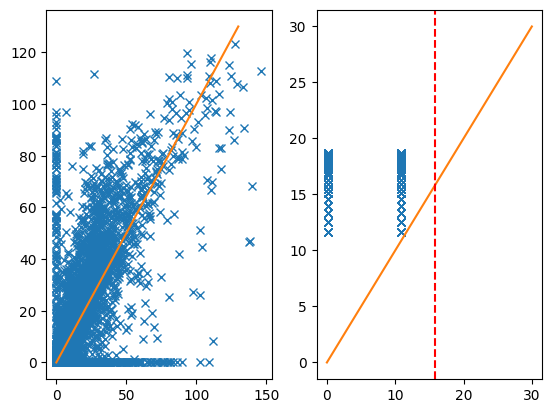

5695.535587080702
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.756  0.426E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     2  -1.330  0.472E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     3  -1.712  0.496E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     4  -1.982  0.282E+00    32080   130.41  0.509   [Radiance 0.660 micron]
     5  -2.365  0.150E+00    32776   132.87  0.519   [Radiance 0.660 micron]
     6  -2.331  0.775E-01    36320   143.63  0.561   [Radiance 0.660 micron]
     7  -2.402  0.573E-01    39665   152.21  0.595   [Radiance 0.660 micron]
     8  -2.514  0.463E-01    43460   160.17  0.626   [Radiance 0.660 micron]
     9  -2.586  0.376E-01    48382   168.97  0.660   [Radiance 0.660 micron]
    10  -2.661  0.317E-01    53898   176.79  0.691   [Radiance 0.660 micron]
    11  -2.847  0.300E-01    56086   179.35  0.701   [Radiance 0.660 micron]
    12  -3.107  0.300E-01    56179   179.45  0.701   [Radianc

<Figure size 640x480 with 0 Axes>

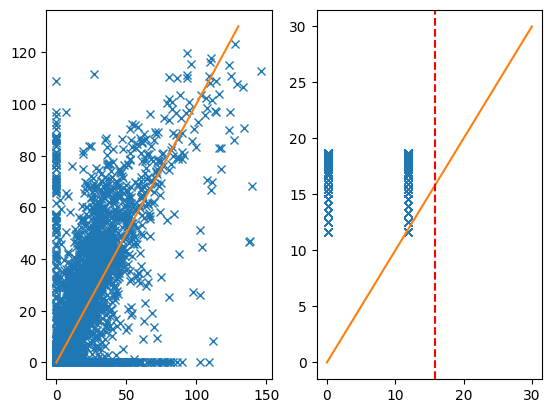

5431.999584024607
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.754  0.424E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     2  -1.330  0.470E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     3  -1.712  0.494E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     4  -1.983  0.281E+00    32079   130.41  0.509   [Radiance 0.660 micron]
     5  -2.368  0.150E+00    32768   132.84  0.519   [Radiance 0.660 micron]
     6  -2.333  0.771E-01    36278   143.52  0.561   [Radiance 0.660 micron]
     7  -2.404  0.571E-01    39593   152.06  0.594   [Radiance 0.660 micron]
     8  -2.511  0.461E-01    43318   159.90  0.625   [Radiance 0.660 micron]
     9  -2.587  0.376E-01    48091   168.49  0.658   [Radiance 0.660 micron]
    10  -2.662  0.317E-01    53499   176.31  0.689   [Radiance 0.660 micron]
    11  -2.851  0.300E-01    55657   178.86  0.699   [Radiance 0.660 micron]
    12  -3.114  0.300E-01    55753   178.94  0.699   [Radianc

<Figure size 640x480 with 0 Axes>

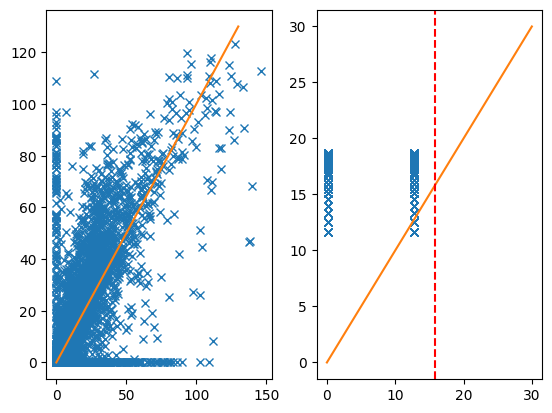

5372.262218624398
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.753  0.423E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     2  -1.329  0.469E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     3  -1.713  0.493E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     4  -1.985  0.279E+00    32079   130.41  0.509   [Radiance 0.660 micron]
     5  -2.370  0.149E+00    32756   132.80  0.519   [Radiance 0.660 micron]
     6  -2.336  0.768E-01    36250   143.45  0.560   [Radiance 0.660 micron]
     7  -2.404  0.568E-01    39583   152.04  0.594   [Radiance 0.660 micron]
     8  -2.512  0.460E-01    43209   159.71  0.624   [Radiance 0.660 micron]
     9  -2.593  0.375E-01    47902   168.21  0.657   [Radiance 0.660 micron]
    10  -2.660  0.315E-01    53403   176.18  0.688   [Radiance 0.660 micron]
    11  -2.865  0.300E-01    55304   178.47  0.697   [Radiance 0.660 micron]
    12  -3.119  0.300E-01    55407   178.58  0.698   [Radianc

<Figure size 640x480 with 0 Axes>

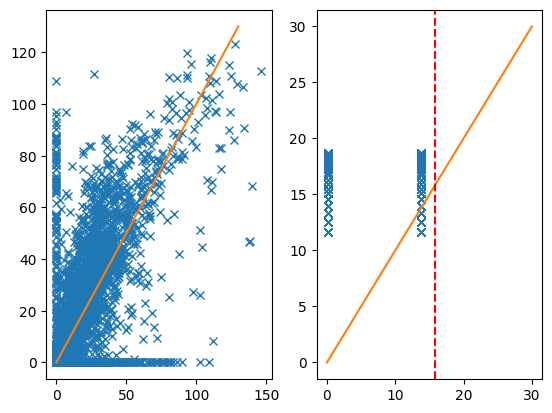

5444.581145017586
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.753  0.422E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     2  -1.328  0.468E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     3  -1.713  0.491E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     4  -1.986  0.280E+00    32077   130.40  0.509   [Radiance 0.660 micron]
     5  -2.374  0.149E+00    32750   132.78  0.519   [Radiance 0.660 micron]
     6  -2.336  0.764E-01    36228   143.39  0.560   [Radiance 0.660 micron]
     7  -2.403  0.567E-01    39531   151.93  0.593   [Radiance 0.660 micron]
     8  -2.515  0.459E-01    43075   159.44  0.623   [Radiance 0.660 micron]
     9  -2.592  0.374E-01    47768   168.01  0.656   [Radiance 0.660 micron]
    10  -2.657  0.315E-01    53189   175.94  0.687   [Radiance 0.660 micron]
    11  -2.865  0.300E-01    55093   178.26  0.696   [Radiance 0.660 micron]
    12  -3.122  0.300E-01    55194   178.36  0.697   [Radianc

<Figure size 640x480 with 0 Axes>

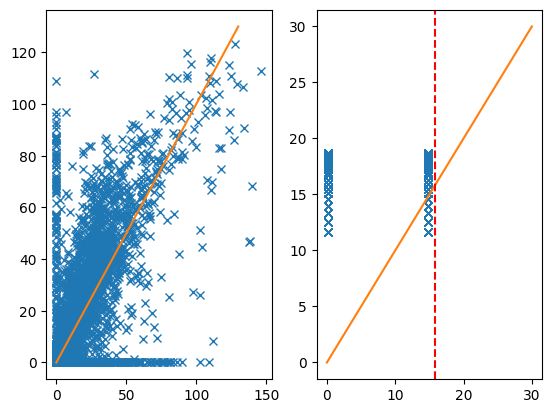

5606.956222155872
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.752  0.421E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     2  -1.328  0.467E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     3  -1.714  0.490E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     4  -1.987  0.279E+00    32077   130.40  0.509   [Radiance 0.660 micron]
     5  -2.376  0.148E+00    32741   132.75  0.519   [Radiance 0.660 micron]
     6  -2.338  0.763E-01    36187   143.28  0.560   [Radiance 0.660 micron]
     7  -2.402  0.565E-01    39496   151.83  0.593   [Radiance 0.660 micron]
     8  -2.515  0.459E-01    42963   159.21  0.622   [Radiance 0.660 micron]
     9  -2.594  0.374E-01    47647   167.80  0.655   [Radiance 0.660 micron]
    10  -2.657  0.314E-01    53036   175.72  0.686   [Radiance 0.660 micron]
    11  -2.865  0.300E-01    54862   178.00  0.695   [Radiance 0.660 micron]
    12  -3.127  0.300E-01    54960   178.08  0.696   [Radianc

<Figure size 640x480 with 0 Axes>

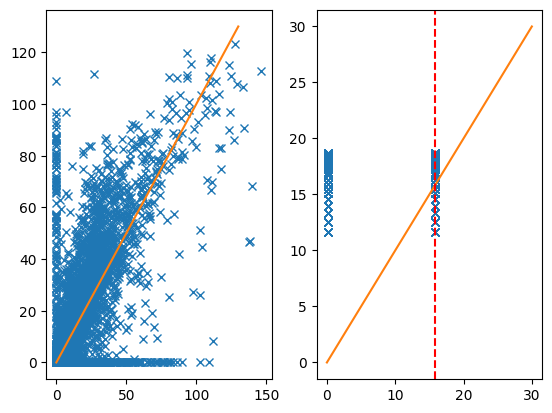

5827.441116339294
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.751  0.420E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     2  -1.327  0.466E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     3  -1.714  0.489E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     4  -1.988  0.280E+00    32076   130.40  0.509   [Radiance 0.660 micron]
     5  -2.378  0.148E+00    32731   132.71  0.518   [Radiance 0.660 micron]
     6  -2.339  0.760E-01    36161   143.20  0.559   [Radiance 0.660 micron]
     7  -2.400  0.563E-01    39478   151.81  0.593   [Radiance 0.660 micron]
     8  -2.515  0.459E-01    42874   159.04  0.621   [Radiance 0.660 micron]
     9  -2.597  0.374E-01    47497   167.57  0.655   [Radiance 0.660 micron]
    10  -2.656  0.313E-01    52922   175.59  0.686   [Radiance 0.660 micron]
    11  -2.872  0.300E-01    54632   177.73  0.694   [Radiance 0.660 micron]
    12  -3.134  0.300E-01    54718   177.80  0.695   [Radianc

<Figure size 640x480 with 0 Axes>

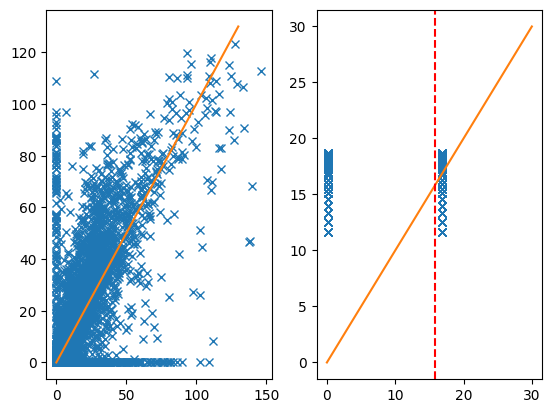

6091.7812493913125
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.751  0.419E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     2  -1.327  0.465E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     3  -1.714  0.488E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     4  -1.989  0.279E+00    32076   130.40  0.509   [Radiance 0.660 micron]
     5  -2.379  0.148E+00    32723   132.68  0.518   [Radiance 0.660 micron]
     6  -2.340  0.758E-01    36135   143.14  0.559   [Radiance 0.660 micron]
     7  -2.399  0.562E-01    39437   151.71  0.593   [Radiance 0.660 micron]
     8  -2.516  0.459E-01    42768   158.81  0.620   [Radiance 0.660 micron]
     9  -2.600  0.373E-01    47391   167.40  0.654   [Radiance 0.660 micron]
    10  -2.660  0.312E-01    52806   175.45  0.685   [Radiance 0.660 micron]
    11  -2.879  0.300E-01    54463   177.54  0.694   [Radiance 0.660 micron]
    12  -3.134  0.300E-01    54557   177.64  0.694   [Radian

<Figure size 640x480 with 0 Axes>

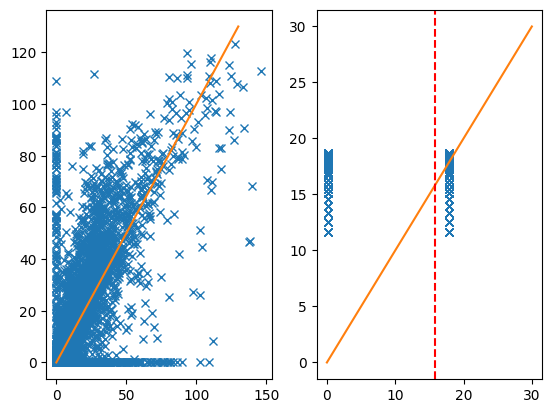

6380.210451141384
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.750  0.418E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     2  -1.326  0.464E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     3  -1.714  0.487E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     4  -1.989  0.278E+00    32076   130.40  0.509   [Radiance 0.660 micron]
     5  -2.380  0.147E+00    32722   132.68  0.518   [Radiance 0.660 micron]
     6  -2.340  0.757E-01    36101   143.04  0.559   [Radiance 0.660 micron]
     7  -2.401  0.561E-01    39404   151.63  0.592   [Radiance 0.660 micron]
     8  -2.515  0.458E-01    42736   158.79  0.620   [Radiance 0.660 micron]
     9  -2.599  0.373E-01    47299   167.23  0.653   [Radiance 0.660 micron]
    10  -2.660  0.312E-01    52646   175.24  0.685   [Radiance 0.660 micron]
    11  -2.886  0.300E-01    54250   177.27  0.692   [Radiance 0.660 micron]
    12  -3.135  0.300E-01    54342   177.35  0.693   [Radianc

<Figure size 640x480 with 0 Axes>

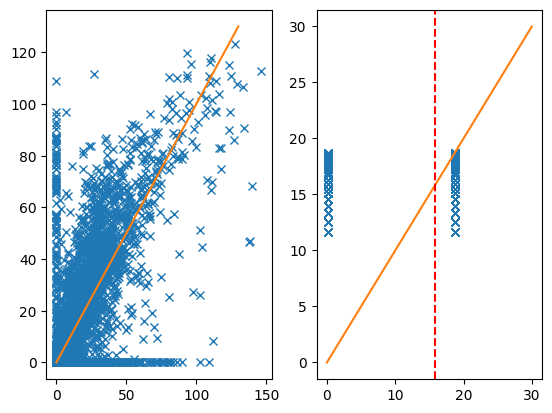

6680.324828438725
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.750  0.417E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     2  -1.326  0.463E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     3  -1.715  0.486E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     4  -1.990  0.277E+00    32076   130.40  0.509   [Radiance 0.660 micron]
     5  -2.382  0.147E+00    32716   132.66  0.518   [Radiance 0.660 micron]
     6  -2.341  0.755E-01    36082   142.98  0.559   [Radiance 0.660 micron]
     7  -2.401  0.561E-01    39376   151.56  0.592   [Radiance 0.660 micron]
     8  -2.517  0.458E-01    42649   158.59  0.619   [Radiance 0.660 micron]
     9  -2.599  0.372E-01    47218   167.10  0.653   [Radiance 0.660 micron]
    10  -2.674  0.312E-01    52539   175.11  0.684   [Radiance 0.660 micron]
    11  -2.868  0.300E-01    54035   177.01  0.691   [Radiance 0.660 micron]
    12  -3.136  0.300E-01    54121   177.08  0.692   [Radianc

<Figure size 640x480 with 0 Axes>

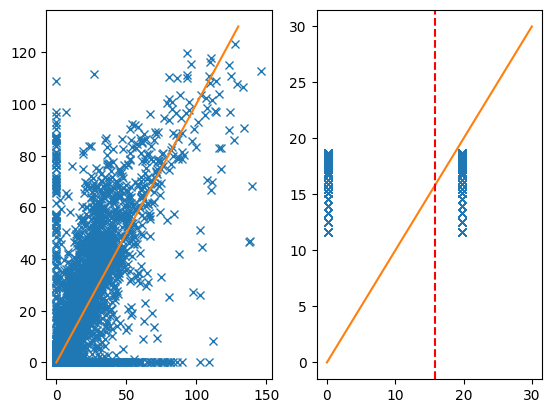

6976.66483907405


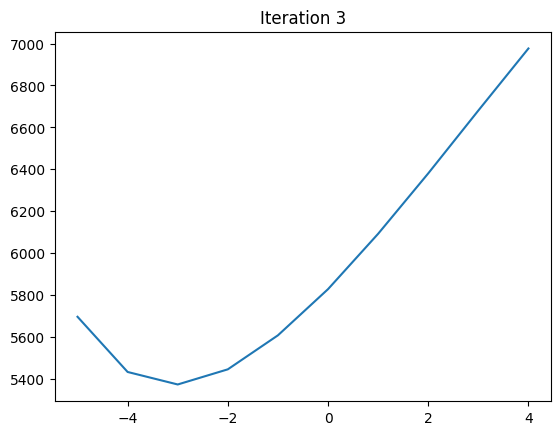

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.748  0.415E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     2  -1.324  0.460E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     3  -1.715  0.483E+00    31968   129.98  0.508   [Radiance 0.660 micron]
     4  -1.993  0.277E+00    32067   130.36  0.509   [Radiance 0.660 micron]
     5  -2.387  0.147E+00    32704   132.62  0.518   [Radiance 0.660 micron]
     6  -2.342  0.749E-01    36030   142.84  0.558   [Radiance 0.660 micron]
     7  -2.402  0.557E-01    39237   151.21  0.591   [Radiance 0.660 micron]
     8  -2.519  0.456E-01    42432   158.23  0.618   [Radiance 0.660 micron]
     9  -2.602  0.371E-01    46875   166.55  0.651   [Radiance 0.660 micron]
    10  -2.678  0.311E-01    52098   174.47  0.682   [Radiance 0.660 micron]
    11  -2.877  0.300E-01    53444   176.32  0.689   [Radiance 0.660 micron]
    12  -3.140  0.300E-01    53541   176.39  0.689   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

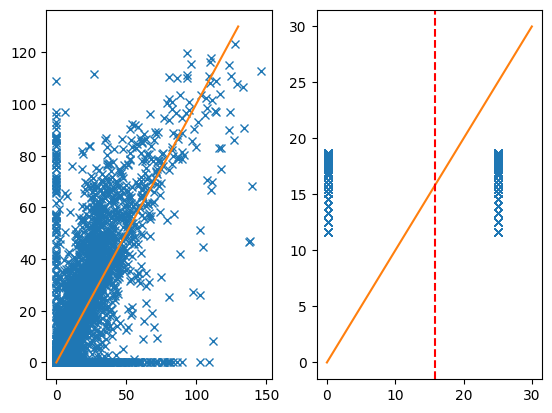


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28351      1      2   1114     0 13254   1.955D+00   8.117D+03
  F =   8116.9740598550252     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.754  0.428E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     2  -1.326  0.474E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     3  -1.705  0.499E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     4  -1.974  0.285E+00    32080   126.09  0.493   [Radiance 0.660 micron]
     5  -2.356  0.152E+00    32772   128.

<Figure size 640x480 with 0 Axes>

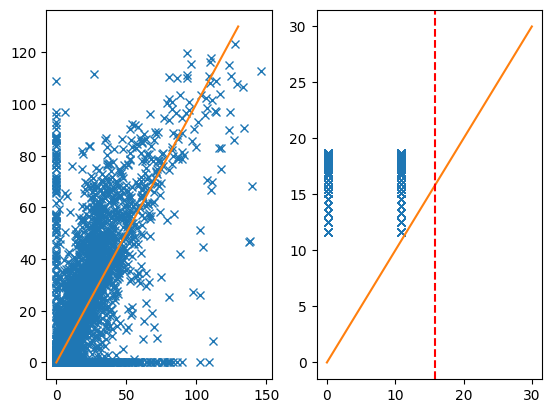

5841.816990585645
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.753  0.426E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     2  -1.325  0.472E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     3  -1.706  0.496E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     4  -1.976  0.284E+00    32079   126.08  0.493   [Radiance 0.660 micron]
     5  -2.360  0.151E+00    32769   128.61  0.502   [Radiance 0.660 micron]
     6  -2.328  0.782E-01    36244   139.59  0.545   [Radiance 0.660 micron]
     7  -2.398  0.578E-01    39571   148.48  0.580   [Radiance 0.660 micron]
     8  -2.509  0.466E-01    43306   156.69  0.612   [Radiance 0.660 micron]
     9  -2.583  0.379E-01    48224   165.86  0.648   [Radiance 0.660 micron]
    10  -2.659  0.319E-01    53692   173.94  0.679   [Radiance 0.660 micron]
    11  -2.830  0.300E-01    56074   176.93  0.691   [Radiance 0.660 micron]
    12  -3.094  0.300E-01    56169   177.04  0.692   [Radianc

<Figure size 640x480 with 0 Axes>

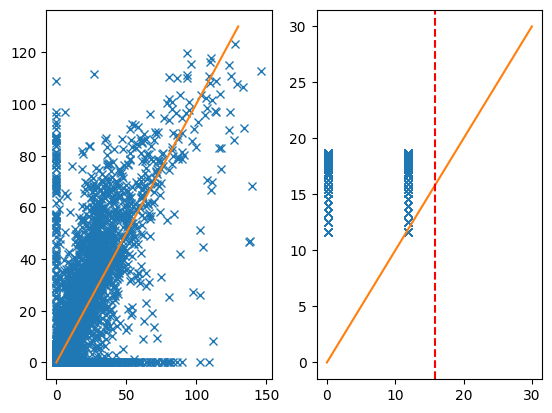

5498.525844377906
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.752  0.424E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     2  -1.325  0.471E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     3  -1.707  0.495E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     4  -1.978  0.283E+00    32077   126.07  0.492   [Radiance 0.660 micron]
     5  -2.363  0.151E+00    32751   128.54  0.502   [Radiance 0.660 micron]
     6  -2.333  0.777E-01    36209   139.51  0.545   [Radiance 0.660 micron]
     7  -2.398  0.573E-01    39558   148.42  0.580   [Radiance 0.660 micron]
     8  -2.512  0.464E-01    43181   156.44  0.611   [Radiance 0.660 micron]
     9  -2.581  0.377E-01    48049   165.57  0.647   [Radiance 0.660 micron]
    10  -2.667  0.319E-01    53290   173.44  0.677   [Radiance 0.660 micron]
    11  -2.832  0.300E-01    55640   176.40  0.689   [Radiance 0.660 micron]
    12  -3.095  0.300E-01    55748   176.52  0.690   [Radianc

<Figure size 640x480 with 0 Axes>

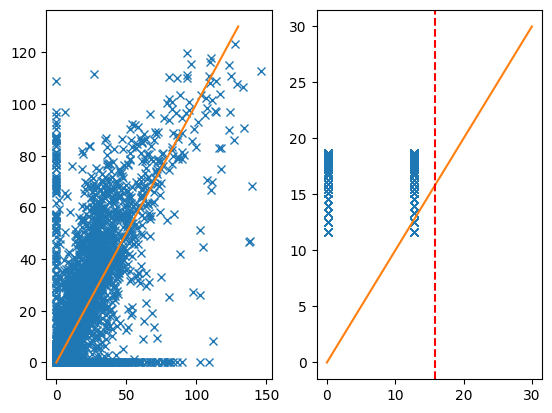

5370.592090849011
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.751  0.423E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     2  -1.324  0.469E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     3  -1.708  0.493E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     4  -1.979  0.284E+00    32076   126.07  0.492   [Radiance 0.660 micron]
     5  -2.366  0.150E+00    32742   128.51  0.502   [Radiance 0.660 micron]
     6  -2.334  0.774E-01    36151   139.35  0.544   [Radiance 0.660 micron]
     7  -2.399  0.572E-01    39524   148.36  0.580   [Radiance 0.660 micron]
     8  -2.513  0.463E-01    43073   156.20  0.610   [Radiance 0.660 micron]
     9  -2.583  0.376E-01    47879   165.27  0.646   [Radiance 0.660 micron]
    10  -2.669  0.318E-01    53069   173.16  0.676   [Radiance 0.660 micron]
    11  -2.837  0.300E-01    55307   176.04  0.688   [Radiance 0.660 micron]
    12  -3.105  0.300E-01    55413   176.15  0.688   [Radianc

<Figure size 640x480 with 0 Axes>

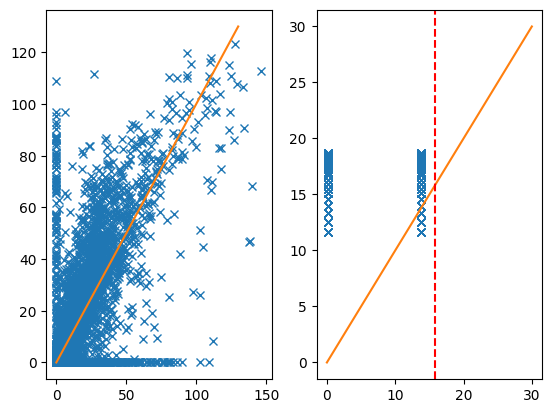

5379.282012305693
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.750  0.422E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     2  -1.323  0.468E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     3  -1.708  0.492E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     4  -1.981  0.282E+00    32076   126.07  0.492   [Radiance 0.660 micron]
     5  -2.369  0.150E+00    32736   128.49  0.502   [Radiance 0.660 micron]
     6  -2.334  0.771E-01    36122   139.26  0.544   [Radiance 0.660 micron]
     7  -2.398  0.570E-01    39465   148.23  0.579   [Radiance 0.660 micron]
     8  -2.514  0.463E-01    42936   155.91  0.609   [Radiance 0.660 micron]
     9  -2.587  0.376E-01    47709   165.01  0.645   [Radiance 0.660 micron]
    10  -2.659  0.317E-01    52969   173.06  0.676   [Radiance 0.660 micron]
    11  -2.844  0.300E-01    55067   175.76  0.687   [Radiance 0.660 micron]
    12  -3.109  0.300E-01    55163   175.83  0.687   [Radianc

<Figure size 640x480 with 0 Axes>

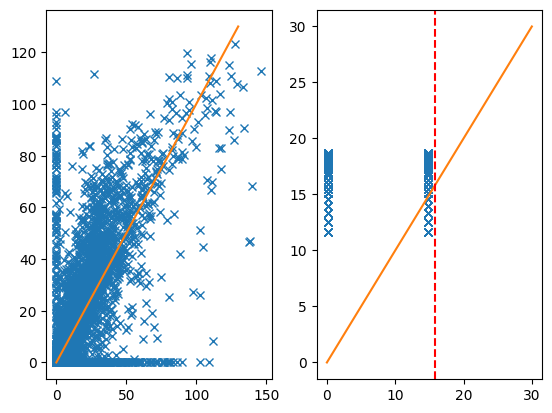

5487.93653540159
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.749  0.421E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     2  -1.323  0.467E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     3  -1.708  0.490E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     4  -1.982  0.281E+00    32076   126.07  0.492   [Radiance 0.660 micron]
     5  -2.371  0.150E+00    32727   128.45  0.502   [Radiance 0.660 micron]
     6  -2.336  0.769E-01    36090   139.16  0.544   [Radiance 0.660 micron]
     7  -2.397  0.568E-01    39434   148.15  0.579   [Radiance 0.660 micron]
     8  -2.515  0.463E-01    42832   155.67  0.608   [Radiance 0.660 micron]
     9  -2.589  0.375E-01    47576   164.79  0.644   [Radiance 0.660 micron]
    10  -2.671  0.316E-01    52821   172.87  0.675   [Radiance 0.660 micron]
    11  -2.831  0.300E-01    54826   175.45  0.685   [Radiance 0.660 micron]
    12  -3.111  0.300E-01    54923   175.54  0.686   [Radiance

<Figure size 640x480 with 0 Axes>

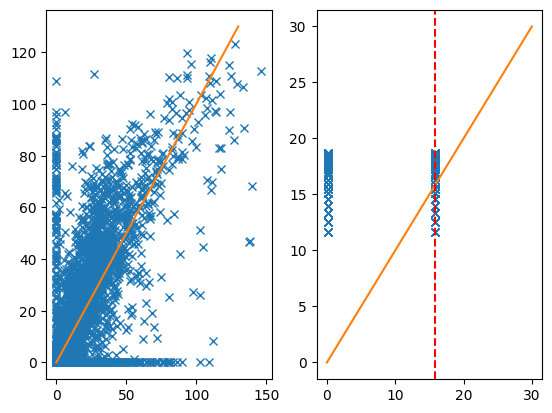

5664.5864824266955
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.748  0.420E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     2  -1.322  0.466E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     3  -1.709  0.489E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     4  -1.982  0.280E+00    32076   126.07  0.492   [Radiance 0.660 micron]
     5  -2.373  0.150E+00    32719   128.43  0.502   [Radiance 0.660 micron]
     6  -2.336  0.767E-01    36071   139.10  0.543   [Radiance 0.660 micron]
     7  -2.397  0.567E-01    39387   148.03  0.578   [Radiance 0.660 micron]
     8  -2.515  0.462E-01    42740   155.53  0.608   [Radiance 0.660 micron]
     9  -2.592  0.375E-01    47429   164.55  0.643   [Radiance 0.660 micron]
    10  -2.669  0.315E-01    52733   172.74  0.675   [Radiance 0.660 micron]
    11  -2.838  0.300E-01    54612   175.18  0.684   [Radiance 0.660 micron]
    12  -3.120  0.300E-01    54717   175.28  0.685   [Radian

<Figure size 640x480 with 0 Axes>

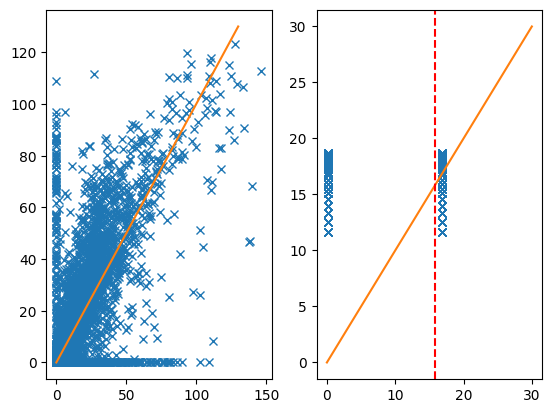

5887.856158755135
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.748  0.419E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     2  -1.322  0.465E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     3  -1.709  0.488E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     4  -1.983  0.278E+00    32076   126.07  0.492   [Radiance 0.660 micron]
     5  -2.374  0.149E+00    32714   128.42  0.502   [Radiance 0.660 micron]
     6  -2.338  0.765E-01    36036   138.98  0.543   [Radiance 0.660 micron]
     7  -2.397  0.566E-01    39354   147.95  0.578   [Radiance 0.660 micron]
     8  -2.515  0.461E-01    42645   155.35  0.607   [Radiance 0.660 micron]
     9  -2.593  0.375E-01    47348   164.41  0.642   [Radiance 0.660 micron]
    10  -2.671  0.315E-01    52563   172.54  0.674   [Radiance 0.660 micron]
    11  -2.841  0.300E-01    54442   174.98  0.684   [Radiance 0.660 micron]
    12  -3.118  0.300E-01    54547   175.07  0.684   [Radianc

<Figure size 640x480 with 0 Axes>

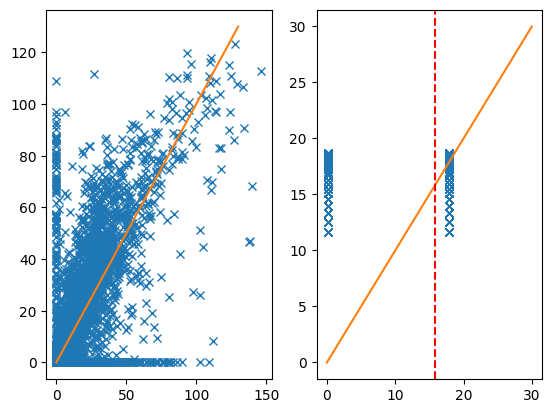

6140.929471679899
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.747  0.418E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     2  -1.322  0.464E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     3  -1.709  0.487E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     4  -1.984  0.281E+00    32073   126.06  0.492   [Radiance 0.660 micron]
     5  -2.375  0.149E+00    32714   128.42  0.502   [Radiance 0.660 micron]
     6  -2.339  0.764E-01    36021   138.94  0.543   [Radiance 0.660 micron]
     7  -2.397  0.565E-01    39308   147.83  0.577   [Radiance 0.660 micron]
     8  -2.516  0.461E-01    42560   155.19  0.606   [Radiance 0.660 micron]
     9  -2.591  0.374E-01    47229   164.21  0.641   [Radiance 0.660 micron]
    10  -2.674  0.315E-01    52346   172.22  0.673   [Radiance 0.660 micron]
    11  -2.845  0.300E-01    54265   174.78  0.683   [Radiance 0.660 micron]
    12  -3.113  0.300E-01    54375   174.86  0.683   [Radianc

<Figure size 640x480 with 0 Axes>

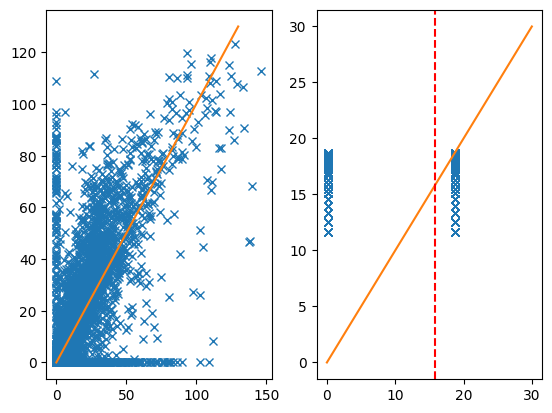

6412.136769032183
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.747  0.417E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     2  -1.321  0.463E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     3  -1.710  0.486E+00    31968   125.64  0.491   [Radiance 0.660 micron]
     4  -1.985  0.281E+00    32071   126.05  0.492   [Radiance 0.660 micron]
     5  -2.377  0.149E+00    32707   128.39  0.502   [Radiance 0.660 micron]
     6  -2.338  0.762E-01    35992   138.85  0.542   [Radiance 0.660 micron]
     7  -2.398  0.564E-01    39266   147.71  0.577   [Radiance 0.660 micron]
     8  -2.515  0.460E-01    42508   155.06  0.606   [Radiance 0.660 micron]
     9  -2.593  0.374E-01    47134   164.04  0.641   [Radiance 0.660 micron]
    10  -2.676  0.315E-01    52214   172.07  0.672   [Radiance 0.660 micron]
    11  -2.844  0.300E-01    54071   174.52  0.682   [Radiance 0.660 micron]
    12  -3.115  0.300E-01    54181   174.59  0.682   [Radianc

<Figure size 640x480 with 0 Axes>

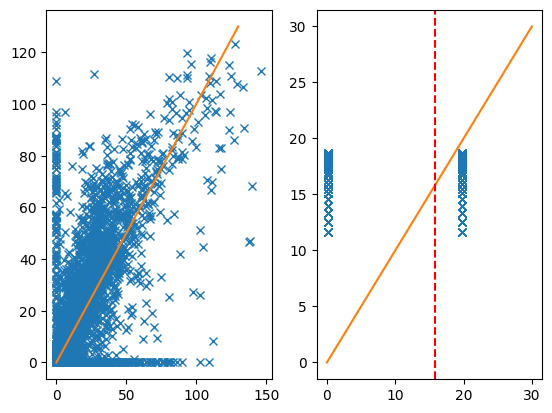

6691.317048536574


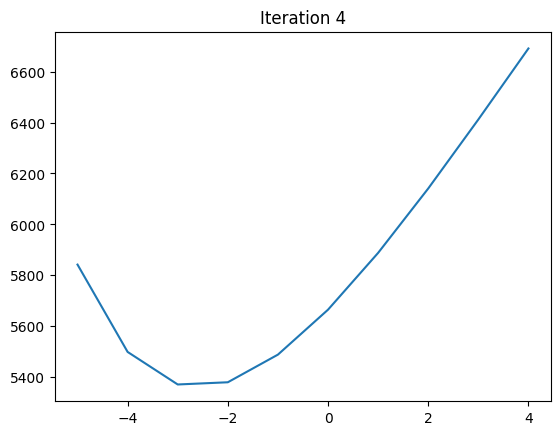

In [10]:
saved = solvers_reconstruct
def retrieve_25():
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
        density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        reff=(None, at3d.transforms.StateToGridUniform(mask=carved_volume.mask.data)))
    )
    # now we form state_gen which updates the solvers with an input_state.

    state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                            unknown_scatterers, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    # get bounds automatically.
    min_bounds, max_bounds = state_gen.transform_bounds()
    # transform initial physical state to abstract state. 
    initial_gridded_extinction = solvers_reconstruct[0.66].medium['cloud'].density.data
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    initial_gridded_reff = solvers[0.66].medium['cloud'].reff.data*0 + 25
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))
    objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
        state_gen.project_gradient_to_state,
            parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bounds, max_bounds=max_bounds)
    optimizer = at3d.optimize.Optimizer(objective_function,callback_fn=callback, options={'maxiter': 100, 'maxls': 10, 'disp': True, 'gtol': 1e-16, 'ftol': 1e-8})
    warnings.filterwarnings('ignore')
    optimizer._options['maxiter'] = 1
    result = optimizer.minimize(x0)
for j in range(5):
    retrieve_25()
    losses = []
    for i in range(-5, 5):
        losses.append(get_loss_uniform(i))
        plot(None)
        print(losses[i+5])
    py.plot(range(-5, 5),losses)
    py.title("Iteration " + str(j))
    py.show()